In [540]:
import glob
import json
import logging
import os
import re
import warnings
from pathlib import Path
from typing import List
from typing import Union, Tuple

import pandas as pd
from matplotlib import pyplot as plt
from numpy import ndarray
from pandas import DataFrame
from scipy.stats import chi2_contingency, variation
from tabulate import tabulate

In [541]:
DEBUGGING: bool = False

if DEBUGGING:
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                        level=logging.DEBUG)
    warnings.filterwarnings("default")
else:
    logging.disable(logging.CRITICAL)
    warnings.filterwarnings("ignore")

In [542]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

In [543]:
def load_json_data(file_path: str) -> pd.DataFrame:
    assert os.path.isfile(file_path), f"File path {file_path} does not exist."

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Ensure that all items have the same structure
    assert all(isinstance(item, dict) for item in
               data), "Items in JSON file are not dictionaries."
    keys = list(data[0].keys())
    assert all(set(keys) == set(item.keys()) for item in
               data), "Not all items in JSON file have the same keys."

    # Convert JSON to DataFrame
    df = pd.DataFrame(data)
    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                        col)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    kendal_tau = df[col1].corr(df[col2], method='kendall')
    spearman = df[col1].corr(df[col2], method='spearman')
    return correlation, kendal_tau, spearman


def plot_scatter_single_or_multiple(df: pd.DataFrame, x_col: str,
                                    y_cols: List[str]) -> None:
    if x_col not in df.columns:
        raise ValueError(f"X column '{x_col}' does not exist in the dataframe.")

    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError(f"X column '{x_col}' is not numeric.")

    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column '{y_col}' does not exist in the dataframe.")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column '{y_col}' is not numeric.")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(
        f'{plot_sat_name}: {x_col} aka [{plot_desc_data_name}] vs {"multiple Y-columns" if len(y_cols) > 1 else y_cols[0]}')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    correlations = {}
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                correlation, kendal_tau, spearman = calculate_correlation(df,
                                                                          col1,
                                                                          col2)
                correlations[(col1, col2)] = {
                    "pearson": correlation,
                    "spearman": spearman,
                    "kendall": kendal_tau,
                    "chi2": None,
                    "p-value": None
                }
                stats_table = pd.DataFrame()

                stats_col1 = df[col1].describe()
                stats_col2 = df[col2].describe()
                combined_stats = pd.concat([stats_col1, stats_col2], axis=1,
                                           keys=[col1, col2])

                chi2, p, _, _ = chi2_contingency(
                    pd.crosstab(df[col1].dropna(), df[col2].dropna()))
                correlations[(col1, col2)]["chi2"] = chi2
                correlations[(col1, col2)]["p-value"] = p

                stats_table = pd.concat([stats_table, combined_stats], axis=1)
                print(tabulate(stats_table, headers='keys', tablefmt='psql'))
                print(
                    f"Correlation [{col1}] vs [{col2}]: pearson=[{correlation}], spearman=[{spearman}], kendall_tau=[{kendal_tau}]")
            else:
                col_list2.remove(col1)
        plot_scatter_single_or_multiple(df, col1,
                                        [y for y in col_list2 if y != col1])


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                           2014]) -> None:
    df_solar: DataFrame = preprocess_solar_data(solar_data_file)
    df_satellite: DataFrame = preprocess_satellite_data(satellite_data_file,
                                                        years_to_analyze)

    solar_column_names: List[str] = [col for col in df_solar.columns if
                                     not re.match(
                                         r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                         col)]
    satellite_column_names: List[str] = [col for col in df_satellite.columns if
                                         not re.match(
                                             r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                             col)]

    for satellite_column in satellite_column_names:
        column_variation: ndarray = variation(df_satellite[satellite_column])
        if column_variation <= 1e-13:
            logging.warning(
                f"Column '{satellite_column}' is nearly constant, skipping.")
            satellite_column_names.remove(satellite_column)

    df_solar_satellite_merged: DataFrame = merge_dataframes_by_time(df_solar,
                                                                    df_satellite)
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)

In [544]:
def analyze_satellite(sat_name: str):
    global plot_sat_name
    plot_sat_name = sat_name

    observed_solar_cycle_data_path: Path = '../data/swpc_observed_ssn.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    if not sat_csv_data_files:
        logging.error(
            f"No CSV files found for satellite=[{sat_name}]. Path checked=[{observed_solar_cycle_data_path}]")
        return

    for sat_file in sat_csv_data_files:
        try:
            assert os.path.exists(
                sat_file), f"File does not exist: [{sat_file}]"
            logging.debug(f"Processing file: [{sat_file}]")

            global plot_desc_data_name
            plot_desc_data_name = os.path.basename(sat_file)
            plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                         plot_desc_data_name,
                                         flags=re.IGNORECASE)
            assert plot_desc_data_name, f"Failed to extract plot description from filename: {sat_file}"

            process(solar_data_file=observed_solar_cycle_data_path,
                    satellite_data_file=os.path.abspath(sat_file))
        except AssertionError as e:
            logging.error(e)
        except Exception as ex:
            logging.exception(
                f"Unexpected error processing file=[{sat_file}] : {ex}")

+-------+-------------+------------+
|       |     Battery |   swpc_ssn |
|-------+-------------+------------|
| count | 1418        |  1418      |
| mean  |    8.25282  |    60.9464 |
| std   |    0.111554 |    51.2837 |
| min   |    7.4      |     0      |
| 25%   |    8.3      |    14      |
| 50%   |    8.3      |    49      |
| 75%   |    8.3      |    99      |
| max   |    8.4      |   227      |
+-------+-------------+------------+
Correlation [Battery] vs [swpc_ssn]: pearson=[-0.05633533230487771], spearman=[0.009183743692619008], kendall_tau=[0.0051619469492026875]


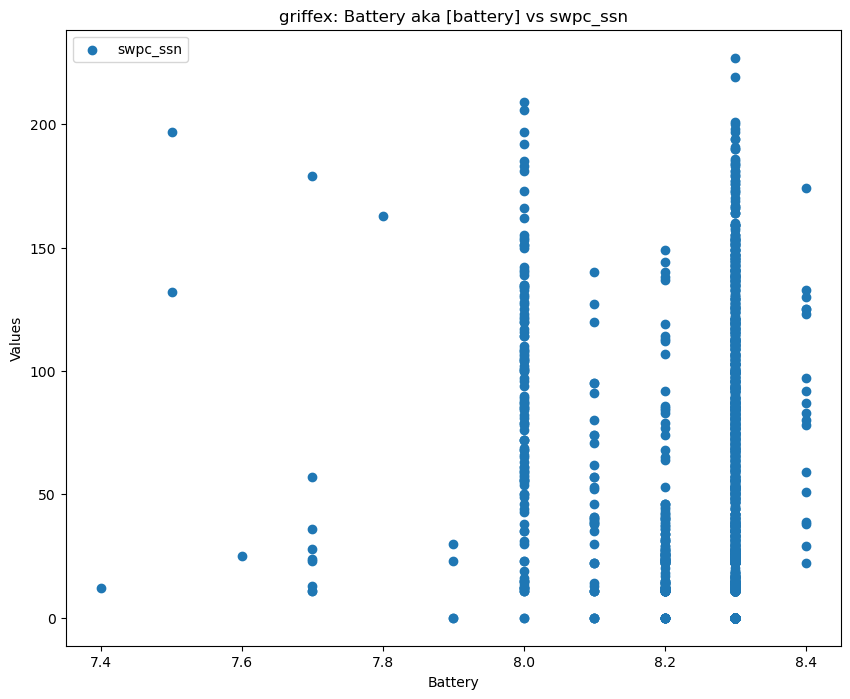

+-------+---------------+------------+
|       |   Battery Bus |   swpc_ssn |
|-------+---------------+------------|
| count |   1418        |  1418      |
| mean  |      0.201327 |    60.9464 |
| std   |      0.274658 |    51.2837 |
| min   |      0.031    |     0      |
| 25%   |      0.033    |    14      |
| 50%   |      0.0555   |    49      |
| 75%   |      0.25     |    99      |
| max   |      1.4      |   227      |
+-------+---------------+------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.13672412903702072], spearman=[0.39612621911017304], kendall_tau=[0.27477822293117526]


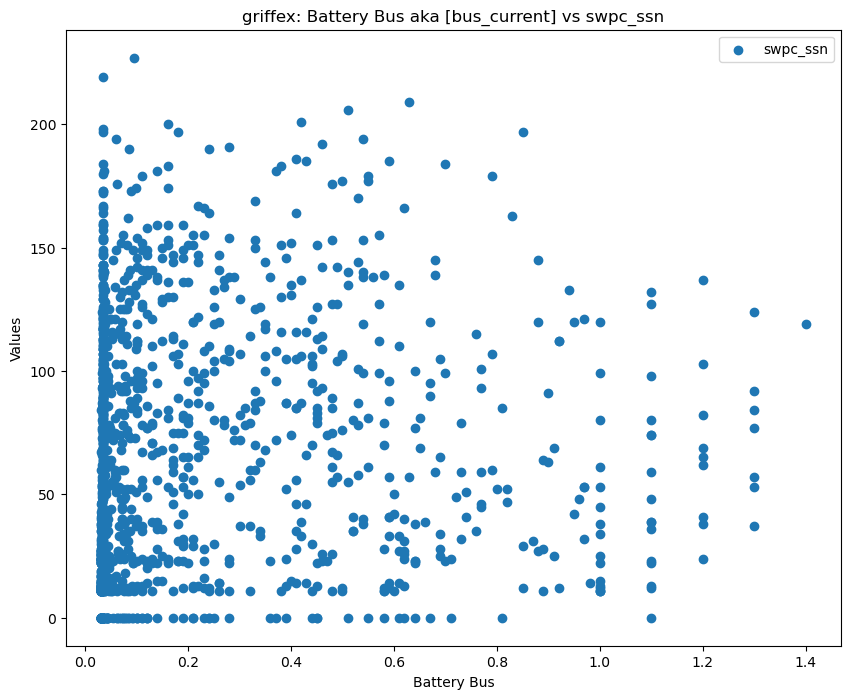

+-------+---------------+------------+
|       |   Battery Bus |   swpc_ssn |
|-------+---------------+------------|
| count |   1418        |  1418      |
| mean  |      8.28188  |    60.9464 |
| std   |      0.116477 |    51.2837 |
| min   |      7.4      |     0      |
| 25%   |      8.3      |    14      |
| 50%   |      8.3      |    49      |
| 75%   |      8.3      |    99      |
| max   |      8.4      |   227      |
+-------+---------------+------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.003239808274962762], spearman=[0.12023594381103614], kendall_tau=[0.09204306050681259]


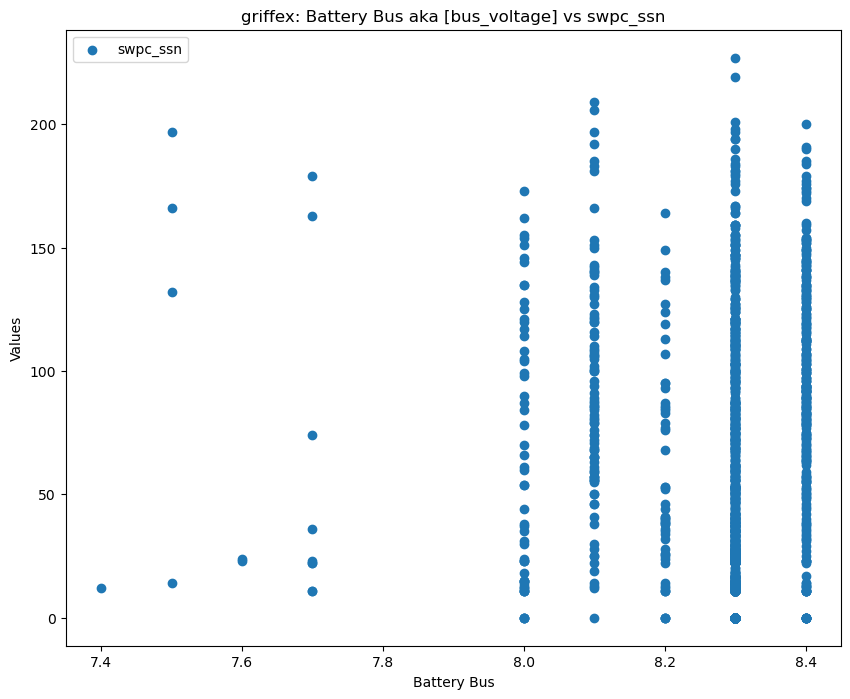

+-------+----------------+------------+
|       |   40379.median |   swpc_ssn |
|-------+----------------+------------|
| count |         1418   |  1418      |
| mean  |       479867   |    60.8505 |
| std   |        32335.5 |    51.2461 |
| min   |       395649   |     0      |
| 25%   |       484053   |    14      |
| 50%   |       493385   |    49      |
| 75%   |       498567   |    99      |
| max   |       499679   |   227      |
+-------+----------------+------------+
Correlation [40379.median] vs [swpc_ssn]: pearson=[0.46315355052211304], spearman=[0.4759659161682569], kendall_tau=[0.32450245018819246]


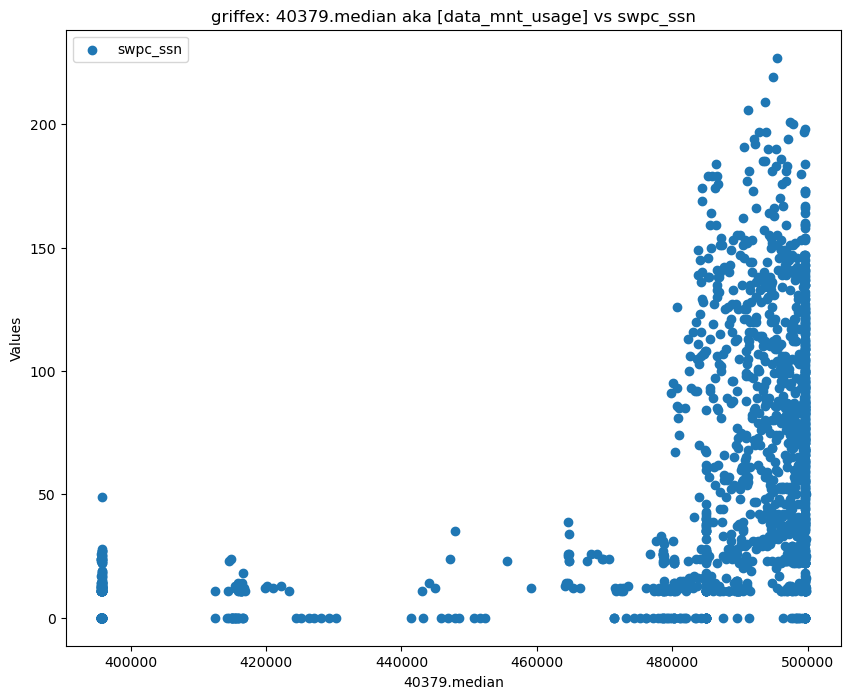

+-------+-----------------+------------+
|       |   40379.freemem |   swpc_ssn |
|-------+-----------------+------------|
| count |      1422       |  1422      |
| mean  |         3.92844 |    60.8629 |
| std   |         2.68321 |    51.2549 |
| min   |         0.18    |     0      |
| 25%   |         0.585   |    14      |
| 50%   |         4.3     |    49      |
| 75%   |         6.7     |    99      |
| max   |        12       |   227      |
+-------+-----------------+------------+
Correlation [40379.freemem] vs [swpc_ssn]: pearson=[-0.2553320454993292], spearman=[-0.28660957028269796], kendall_tau=[-0.19699078323395622]


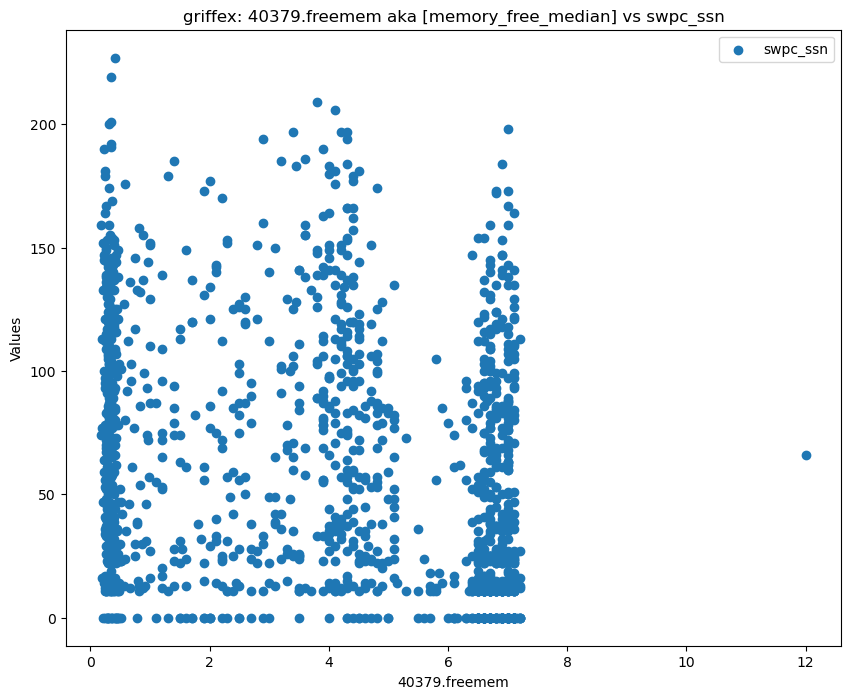

+-------+----------------+------------+
|       |   40379.median |   swpc_ssn |
|-------+----------------+------------|
| count |    1421        |  1421      |
| mean  |       7.91499  |    60.9064 |
| std   |       0.325999 |    51.2468 |
| min   |       7.9      |     0      |
| 25%   |       7.9      |    14      |
| 50%   |       7.9      |    49      |
| 75%   |       7.9      |    99      |
| max   |      15        |   227      |
+-------+----------------+------------+
Correlation [40379.median] vs [swpc_ssn]: pearson=[0.023727671689518597], spearman=[0.027255477433036954], kendall_tau=[0.022511671225207898]


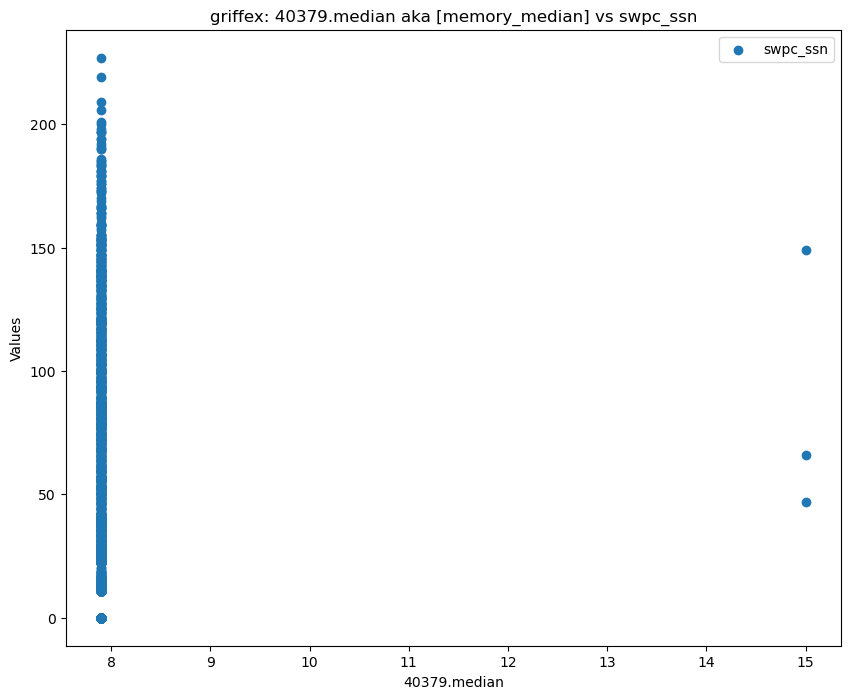

+-------+----------+------------+
|       |   resets |   swpc_ssn |
|-------+----------+------------|
| count | 1421     |  1421      |
| mean  | 1065.66  |    60.9064 |
| std   |  621.888 |    51.2468 |
| min   |    0     |     0      |
| 25%   |  759     |    14      |
| 50%   | 1247     |    49      |
| 75%   | 1547     |    99      |
| max   | 4945     |   227      |
+-------+----------+------------+
Correlation [resets] vs [swpc_ssn]: pearson=[0.17805007116349097], spearman=[0.3894670351522071], kendall_tau=[0.28077806323937066]


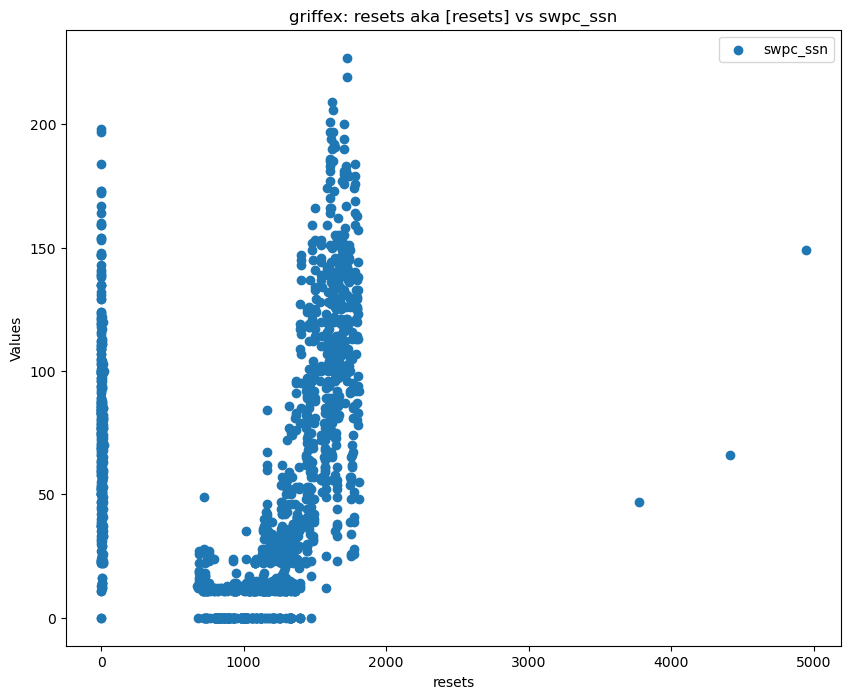

In [545]:
analyze_satellite('griffex')

+-------+---------------------+------------+
|       |   54684.mode_mode V |   swpc_ssn |
|-------+---------------------+------------|
| count |           18        |    18      |
| mean  |           11.4661   |   109      |
| std   |            0.150612 |    34.8037 |
| min   |           11.3      |    33      |
| 25%   |           11.35     |    99.5    |
| 50%   |           11.46     |   106      |
| 75%   |           11.51     |   133.75   |
| max   |           11.91     |   166      |
+-------+---------------------+------------+
Correlation [54684.mode_mode V] vs [swpc_ssn]: pearson=[0.12142101001190515], spearman=[0.35361993001509145], kendall_tau=[0.23057339665182852]


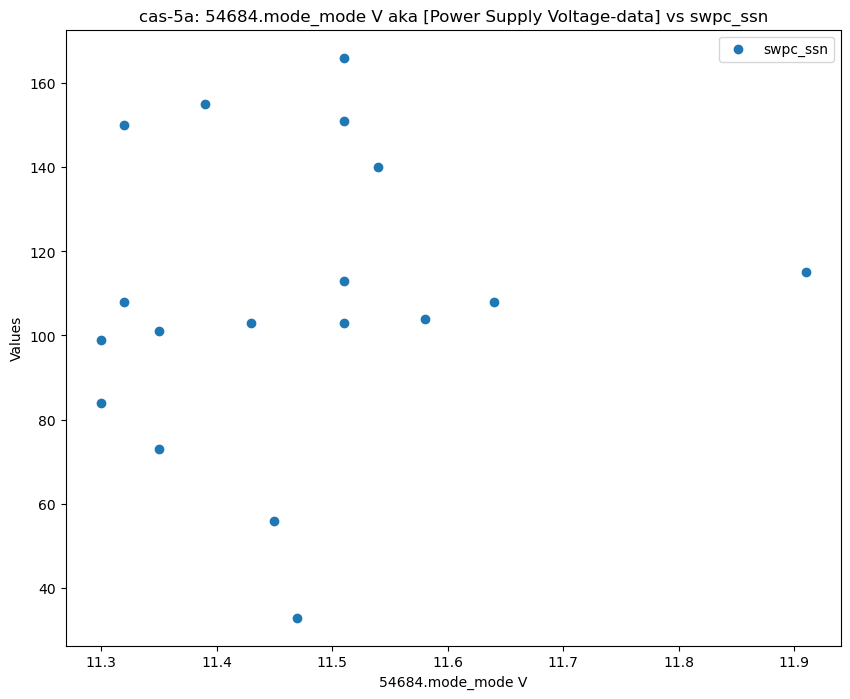

+-------+--------------+------------+
|       |   UHF1 Power |   swpc_ssn |
|-------+--------------+------------|
| count |      114     |   114      |
| mean  |     1407.48  |   117.395  |
| std   |      136.545 |    42.6178 |
| min   |     1092     |    23      |
| 25%   |     1263     |    87.25   |
| 50%   |     1476     |   110.5    |
| 75%   |     1512.25  |   140.75   |
| max   |     1578     |   209      |
+-------+--------------+------------+
Correlation [UHF1 Power] vs [swpc_ssn]: pearson=[-0.15676750343342466], spearman=[-0.1927394646248011], kendall_tau=[-0.13246747181362192]


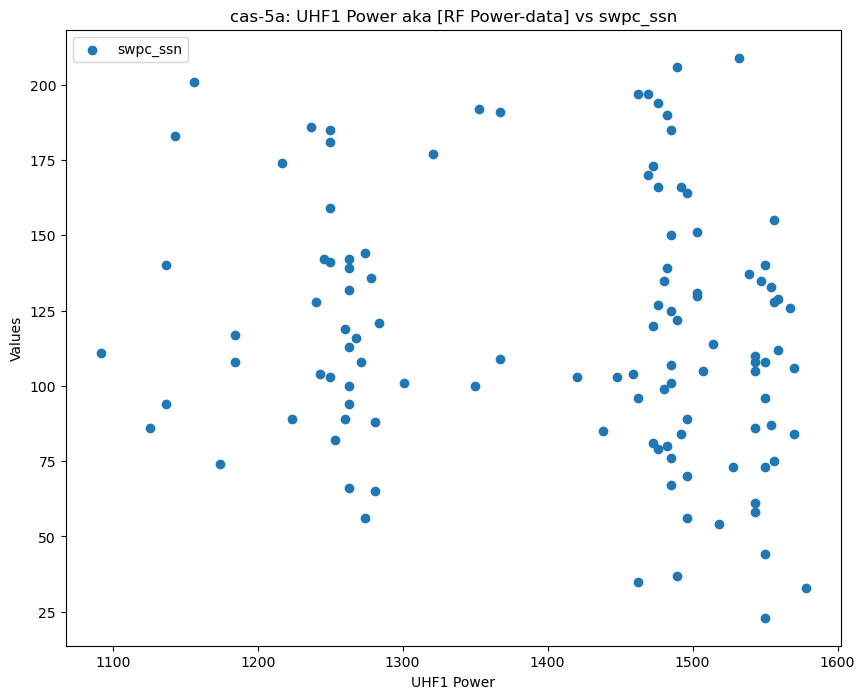

+-------+-----------------------+------------+
|       |   Primary Bus Current |   swpc_ssn |
|-------+-----------------------+------------|
| count |              114      |   114      |
| mean  |               25.0526 |   117.395  |
| std   |              157.189  |    42.6178 |
| min   |                0      |    23      |
| 25%   |                0      |    87.25   |
| 50%   |                0      |   110.5    |
| 75%   |                0      |   140.75   |
| max   |             1195      |   209      |
+-------+-----------------------+------------+
Correlation [Primary Bus Current] vs [swpc_ssn]: pearson=[-0.10212962782413144], spearman=[-0.030105054109296783], kendall_tau=[-0.024528442570878228]


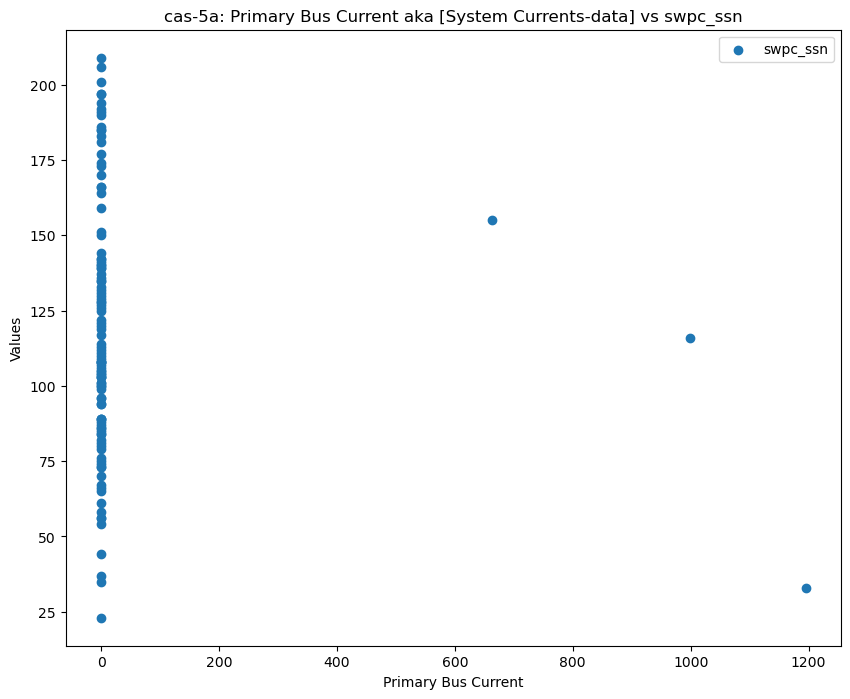

+-------+-----------+------------+
|       |       IHU |   swpc_ssn |
|-------+-----------+------------|
| count | 114       |   114      |
| mean  |  16.5     |   117.395  |
| std   |   2.47197 |    42.6178 |
| min   |  13       |    23      |
| 25%   |  15       |    87.25   |
| 50%   |  16       |   110.5    |
| 75%   |  17       |   140.75   |
| max   |  26       |   209      |
+-------+-----------+------------+
Correlation [IHU] vs [swpc_ssn]: pearson=[0.014742294538607096], spearman=[-0.008542958649201576], kendall_tau=[-0.009403302154266163]


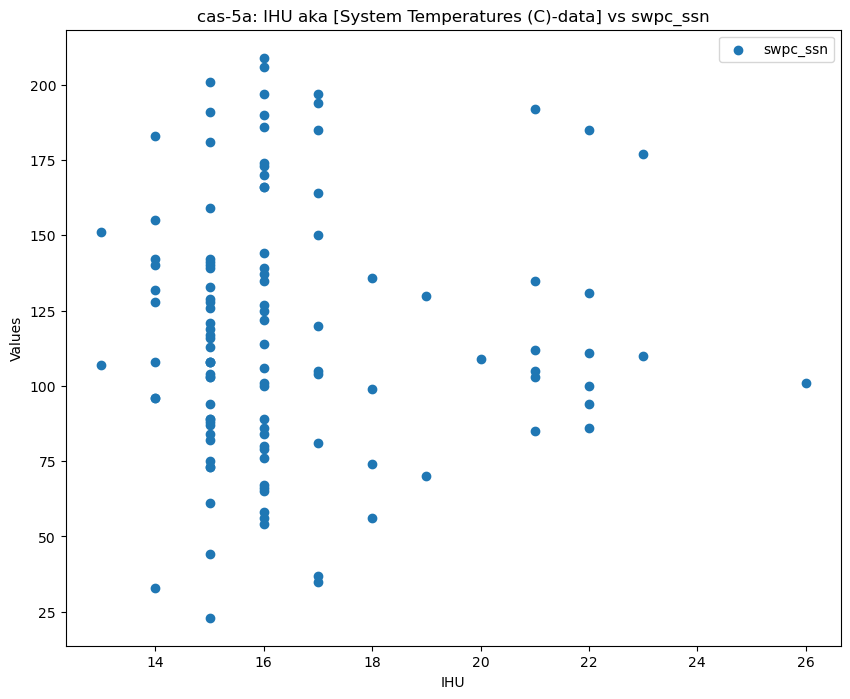

+-------+-----------------------------+------------+
|       |   Total Solar Array Current |   swpc_ssn |
|-------+-----------------------------+------------|
| count |                    114      |   114      |
| mean  |                   2620.46   |   117.395  |
| std   |                     53.9164 |    42.6178 |
| min   |                   2088      |    23      |
| 25%   |                   2627      |    87.25   |
| 50%   |                   2627      |   110.5    |
| 75%   |                   2627      |   140.75   |
| max   |                   2627      |   209      |
+-------+-----------------------------+------------+
Correlation [Total Solar Array Current] vs [swpc_ssn]: pearson=[0.1369086294587559], spearman=[0.040145991592160944], kendall_tau=[0.03247210626412327]


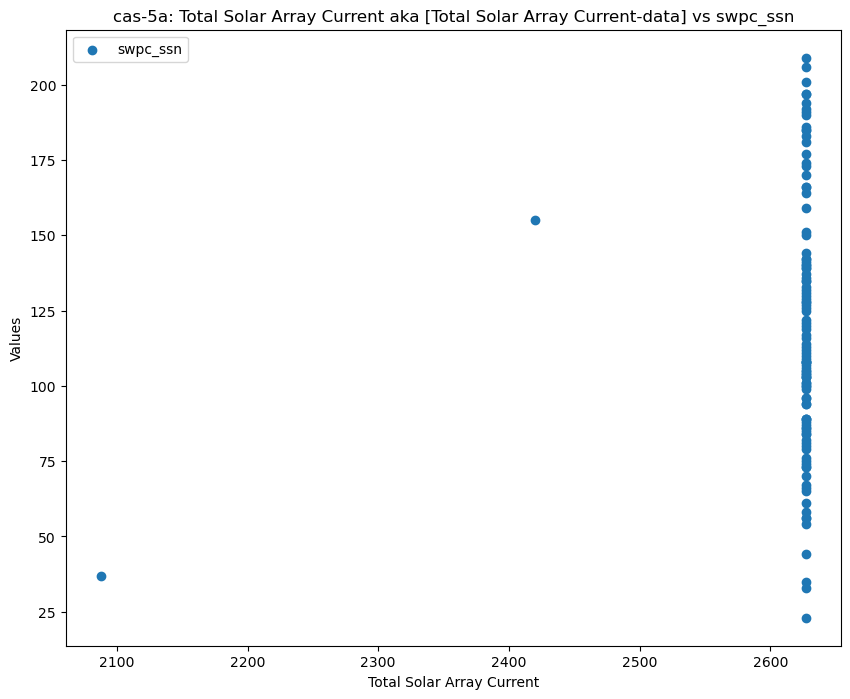

+-------+-----------+------------+
|       |        YY |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |  22.5862  |   117.371  |
| std   |   2.15515 |    42.3202 |
| min   |   0       |    23      |
| 25%   |  23       |    87.75   |
| 50%   |  23       |   110.5    |
| 75%   |  23       |   140.25   |
| max   |  23       |   209      |
+-------+-----------+------------+
Correlation [YY] vs [swpc_ssn]: pearson=[-0.14398357831183856], spearman=[-0.04103790831221357], kendall_tau=[-0.034829311527713486]


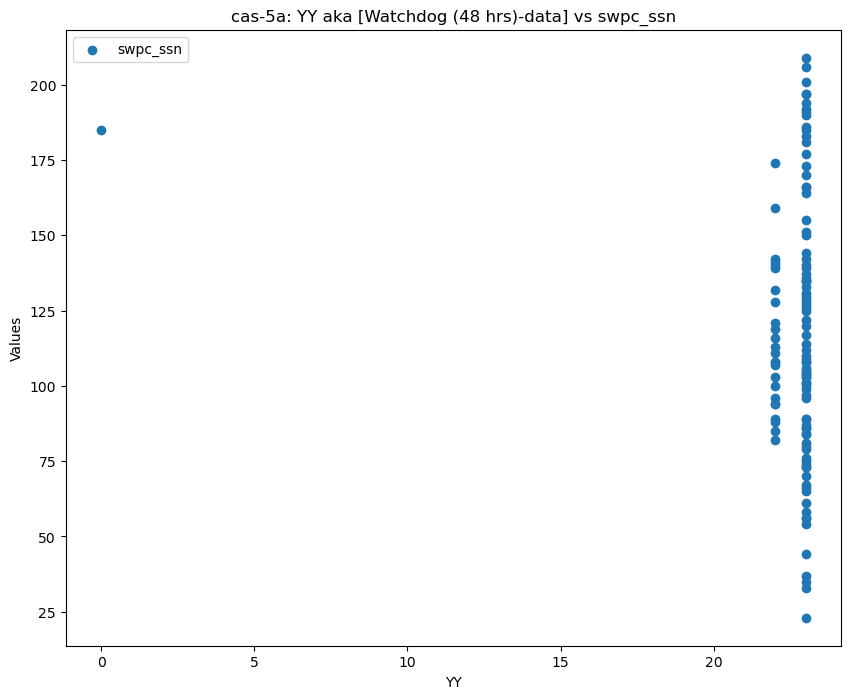

+-------+-----------+------------+
|       |        MM |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |   4.23276 |   117.371  |
| std   |   4.17312 |    42.3202 |
| min   |   0       |    23      |
| 25%   |   1.75    |    87.75   |
| 50%   |   3       |   110.5    |
| 75%   |   4       |   140.25   |
| max   |  12       |   209      |
+-------+-----------+------------+
Correlation [MM] vs [swpc_ssn]: pearson=[-0.10782995308889555], spearman=[-0.24905700060777822], kendall_tau=[-0.18181700146162916]


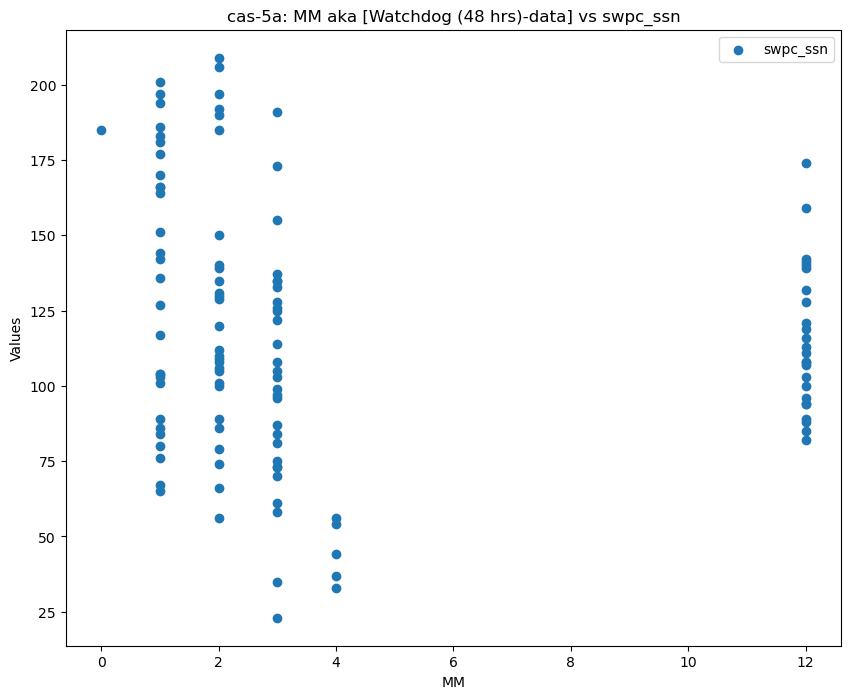

+-------+-----------+------------+
|       |        DD |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |  15.8103  |   117.371  |
| std   |   8.89251 |    42.3202 |
| min   |   0       |    23      |
| 25%   |   9       |    87.75   |
| 50%   |  15       |   110.5    |
| 75%   |  23.25    |   140.25   |
| max   |  31       |   209      |
+-------+-----------+------------+
Correlation [DD] vs [swpc_ssn]: pearson=[-0.1289063012452791], spearman=[-0.14923357517709296], kendall_tau=[-0.11815398003289736]


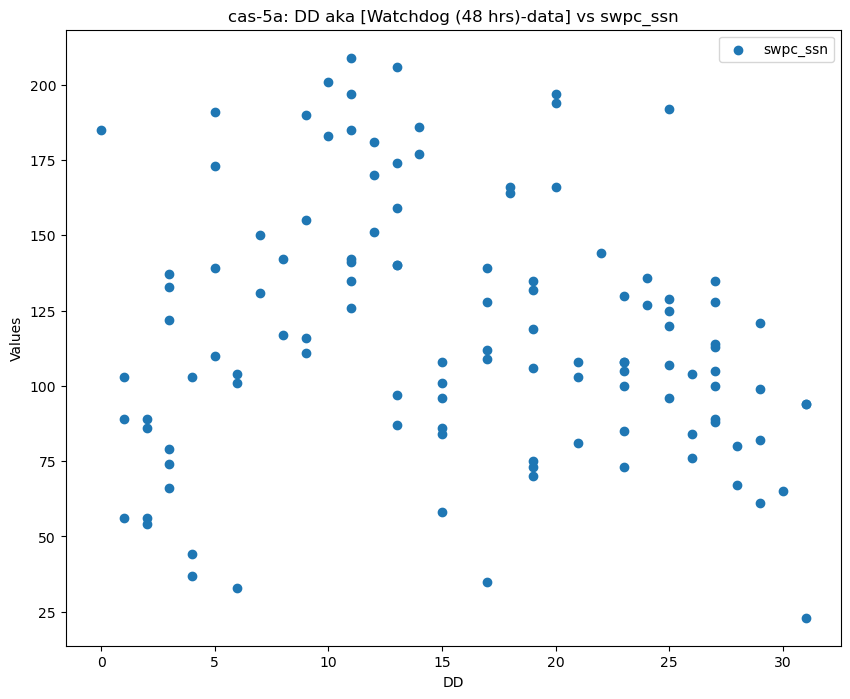

+-------+-----------+------------+
|       |        hh |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |  15.7931  |   117.371  |
| std   |   3.41485 |    42.3202 |
| min   |   0       |    23      |
| 25%   |  11       |    87.75   |
| 50%   |  18       |   110.5    |
| 75%   |  18       |   140.25   |
| max   |  18       |   209      |
+-------+-----------+------------+
Correlation [hh] vs [swpc_ssn]: pearson=[-0.0882762728840715], spearman=[-0.0851267408255598], kendall_tau=[-0.06216459662208153]


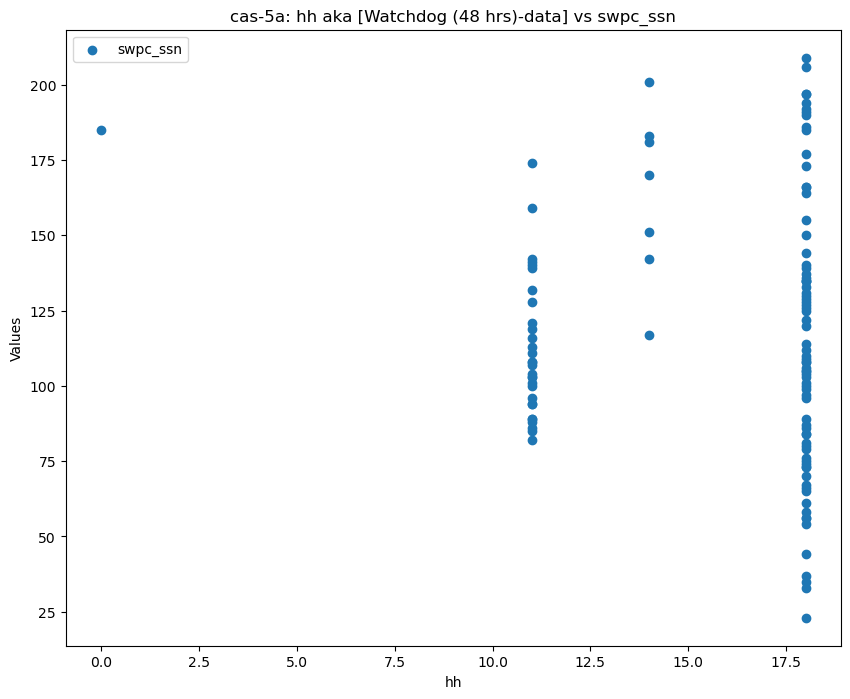

+-------+----------+------------+
|       |       mm |   swpc_ssn |
|-------+----------+------------|
| count | 116      |   116      |
| mean  |  31.9397 |   117.371  |
| std   |  10.855  |    42.3202 |
| min   |   0      |    23      |
| 25%   |  25      |    87.75   |
| 50%   |  26      |   110.5    |
| 75%   |  47      |   140.25   |
| max   |  49      |   209      |
+-------+----------+------------+
Correlation [mm] vs [swpc_ssn]: pearson=[0.03374247709264224], spearman=[-0.07001613606469784], kendall_tau=[-0.0455067390483105]


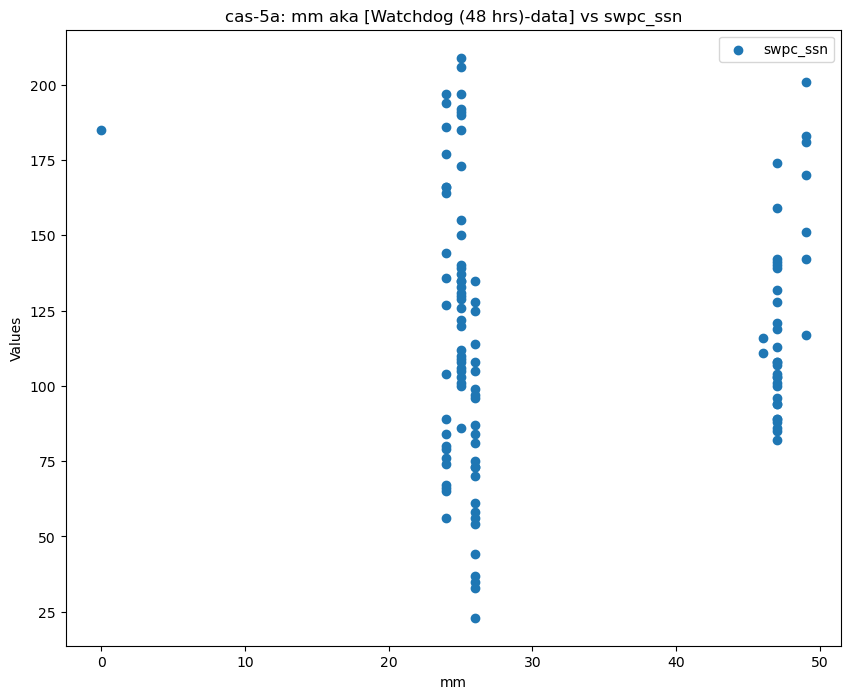

+-------+----------+------------+
|       |       ss |   swpc_ssn |
|-------+----------+------------|
| count | 116      |   116      |
| mean  |  28.1293 |   117.371  |
| std   |  16.4208 |    42.3202 |
| min   |   0      |    23      |
| 25%   |  15      |    87.75   |
| 50%   |  30.5    |   110.5    |
| 75%   |  40      |   140.25   |
| max   |  59      |   209      |
+-------+----------+------------+
Correlation [ss] vs [swpc_ssn]: pearson=[-0.07445892879360048], spearman=[-0.057261542154608706], kendall_tau=[-0.04622082116393414]


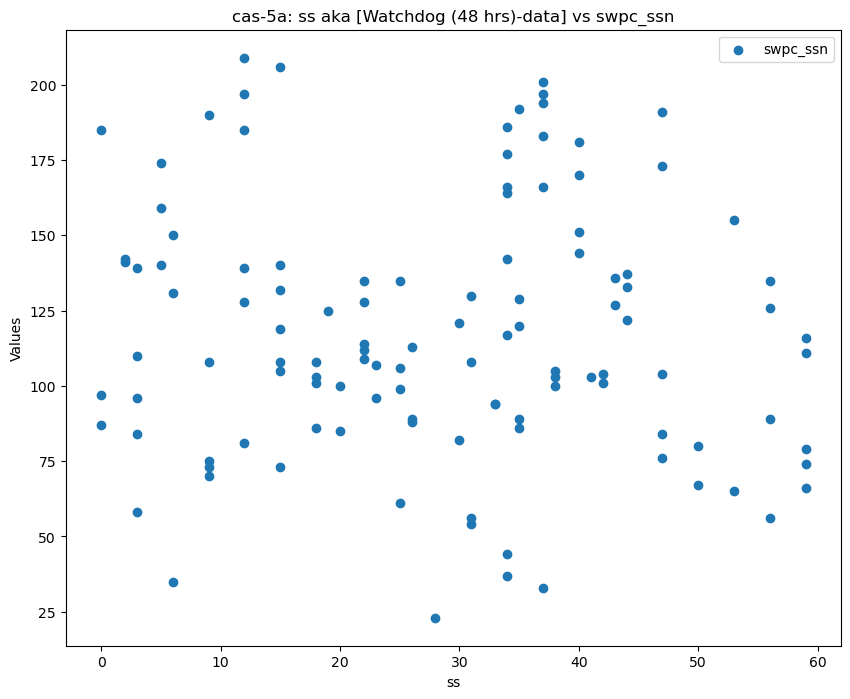

+-------+------------+------------+
|       |    VHF AGC |   swpc_ssn |
|-------+------------+------------|
| count | 114        |   114      |
| mean  |   1.47632  |   117.395  |
| std   |   0.107508 |    42.6178 |
| min   |   1        |    23      |
| 25%   |   1.4      |    87.25   |
| 50%   |   1.4      |   110.5    |
| 75%   |   1.6      |   140.75   |
| max   |   1.6      |   209      |
+-------+------------+------------+
Correlation [VHF AGC] vs [swpc_ssn]: pearson=[0.09824608531088937], spearman=[0.10999702789527843], kendall_tau=[0.09006864929746124]


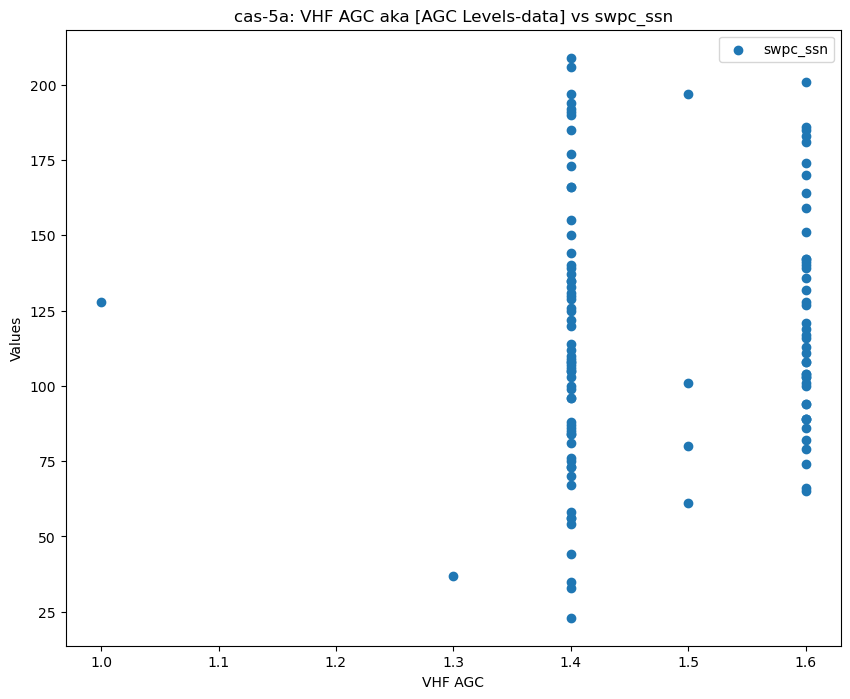

+-------+-----------+------------+
|       |    Cam #1 |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |  13.4741  |   117.371  |
| std   |   6.63254 |    42.3202 |
| min   |   3       |    23      |
| 25%   |   3       |    87.75   |
| 50%   |  18       |   110.5    |
| 75%   |  18       |   140.25   |
| max   |  18       |   209      |
+-------+-----------+------------+
Correlation [Cam #1] vs [swpc_ssn]: pearson=[-0.03789992980533905], spearman=[-0.0862393269712509], kendall_tau=[-0.058294019738260705]


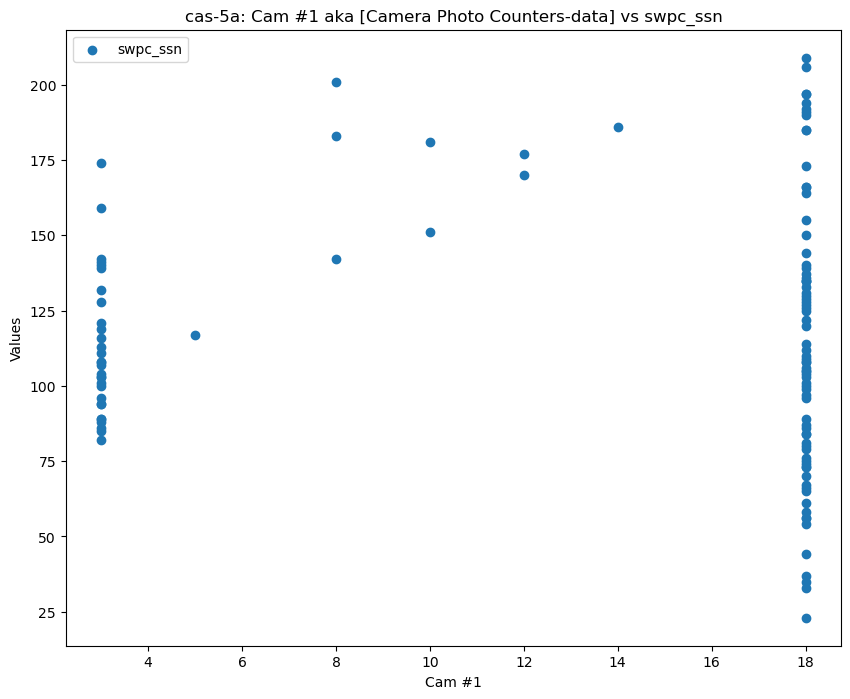

+-------+----------+------------+
|       |   Cam #2 |   swpc_ssn |
|-------+----------+------------|
| count | 116      |   116      |
| mean  |  10.5948 |   117.371  |
| std   |   4.9396 |    42.3202 |
| min   |   3      |    23      |
| 25%   |   3      |    87.75   |
| 50%   |  14      |   110.5    |
| 75%   |  14      |   140.25   |
| max   |  14      |   209      |
+-------+----------+------------+
Correlation [Cam #2] vs [swpc_ssn]: pearson=[-0.05692881563169436], spearman=[-0.08752579264674691], kendall_tau=[-0.060705560584363896]


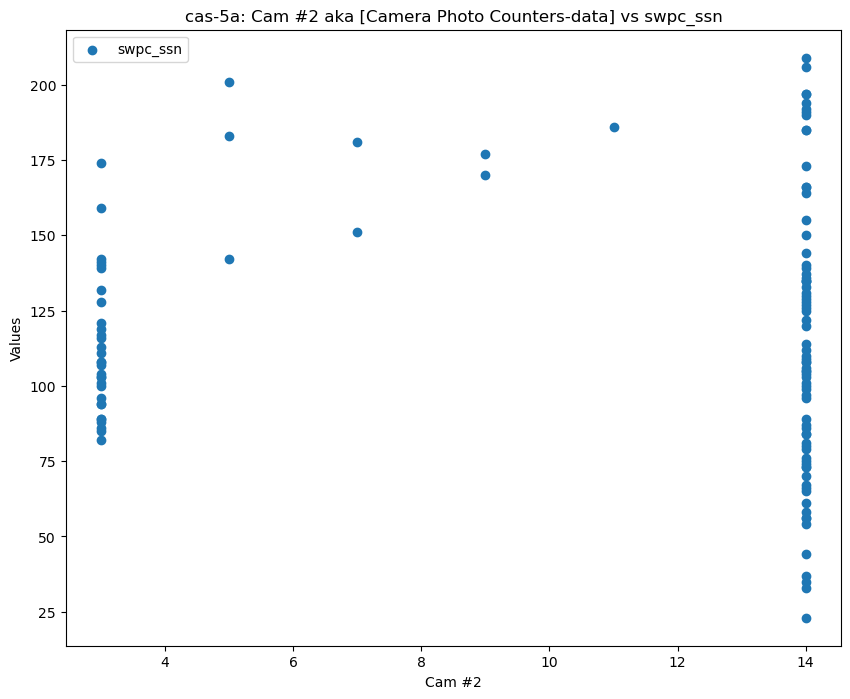

+-------+-----------+------------+
|       |    Cam #3 |   swpc_ssn |
|-------+-----------+------------|
| count | 116       |   116      |
| mean  |  12.7414  |   117.371  |
| std   |   6.21096 |    42.3202 |
| min   |   3       |    23      |
| 25%   |   3       |    87.75   |
| 50%   |  17       |   110.5    |
| 75%   |  17       |   140.25   |
| max   |  17       |   209      |
+-------+-----------+------------+
Correlation [Cam #3] vs [swpc_ssn]: pearson=[-0.04541799929267759], spearman=[-0.0862393269712509], kendall_tau=[-0.058294019738260705]


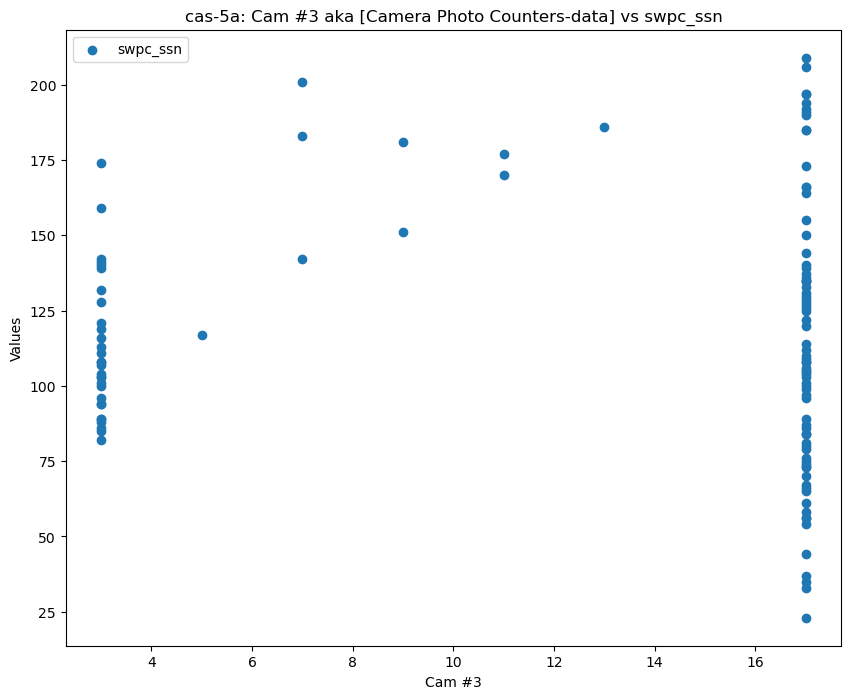

+-------+----------+------------+
|       |     Year |   swpc_ssn |
|-------+----------+------------|
| count |  32      |    32      |
| mean  |  27.5    |    99.0938 |
| std   |  26.3708 |    39.7454 |
| min   |  22      |    23      |
| 25%   |  23      |    72.25   |
| 50%   |  23      |    99.5    |
| 75%   |  23      |   126.5    |
| max   | 172      |   191      |
+-------+----------+------------+
Correlation [Year] vs [swpc_ssn]: pearson=[0.006047697802733397], spearman=[0.0958021232327667], kendall_tau=[0.08518729813651077]


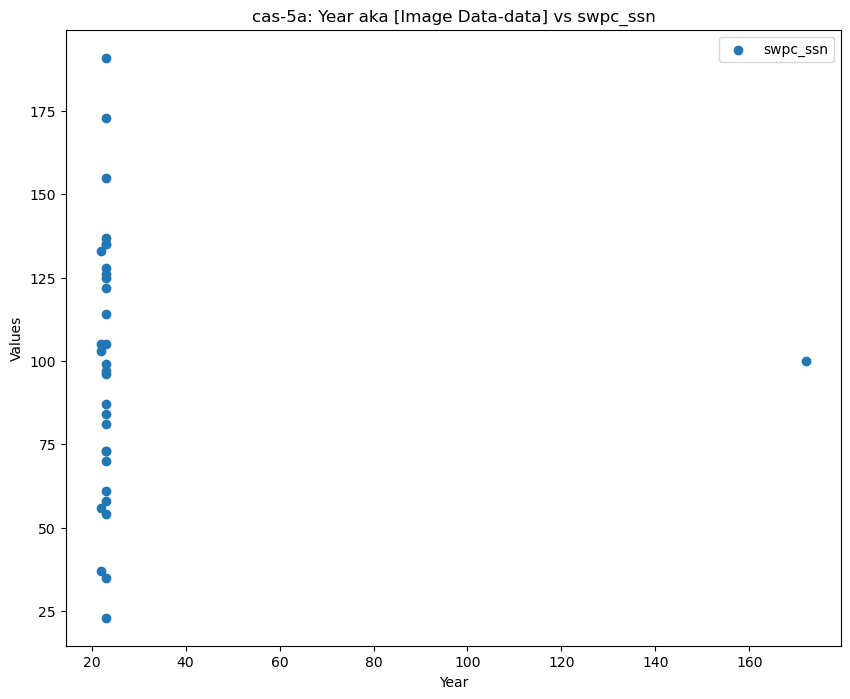

+-------+-----------+------------+
|       |     Month |   swpc_ssn |
|-------+-----------+------------|
| count |  32       |    32      |
| mean  |   5.84375 |    99.0938 |
| std   |  17.8291  |    39.7454 |
| min   |   1       |    23      |
| 25%   |   1       |    72.25   |
| 50%   |   1       |    99.5    |
| 75%   |   1       |   126.5    |
| max   | 101       |   191      |
+-------+-----------+------------+
Correlation [Month] vs [swpc_ssn]: pearson=[-0.026654512259354883], spearman=[-0.0871542587942659], kendall_tau=[-0.07808835662513489]


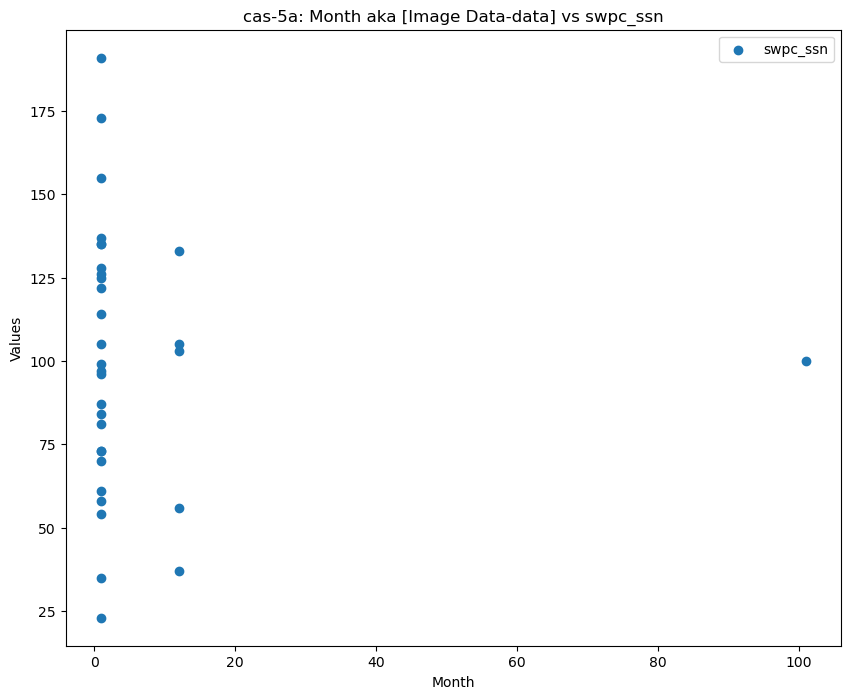

+-------+---------+------------+
|       |     Day |   swpc_ssn |
|-------+---------+------------|
| count |  32     |    32      |
| mean  |  17.25  |    99.0938 |
| std   |  20.119 |    39.7454 |
| min   |   8     |    23      |
| 25%   |  11.25  |    72.25   |
| 50%   |  15     |    99.5    |
| 75%   |  17     |   126.5    |
| max   | 126     |   191      |
+-------+---------+------------+
Correlation [Day] vs [swpc_ssn]: pearson=[0.00025212999964088534], spearman=[-0.17115355479317643], kendall_tau=[-0.12354529289016038]


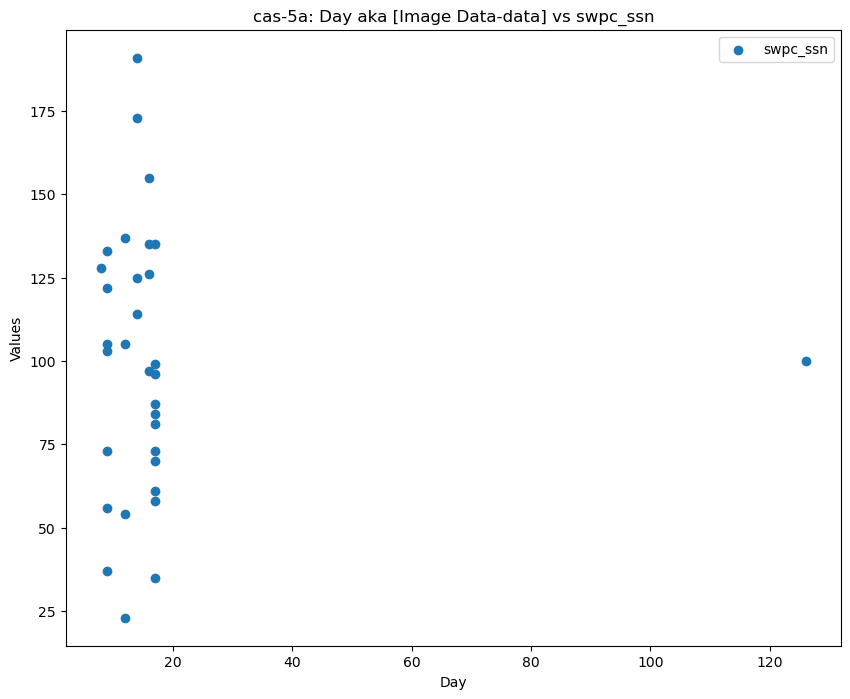

+-------+----------+------------+
|       |     Hour |   swpc_ssn |
|-------+----------+------------|
| count | 32       |    32      |
| mean  |  7.40625 |    99.0938 |
| std   | 13.1047  |    39.7454 |
| min   |  1       |    23      |
| 25%   |  1       |    72.25   |
| 50%   |  3       |    99.5    |
| 75%   | 11       |   126.5    |
| max   | 73       |   191      |
+-------+----------+------------+
Correlation [Hour] vs [swpc_ssn]: pearson=[-0.024105600930706315], spearman=[0.11694020462269497], kendall_tau=[0.09658021523770026]


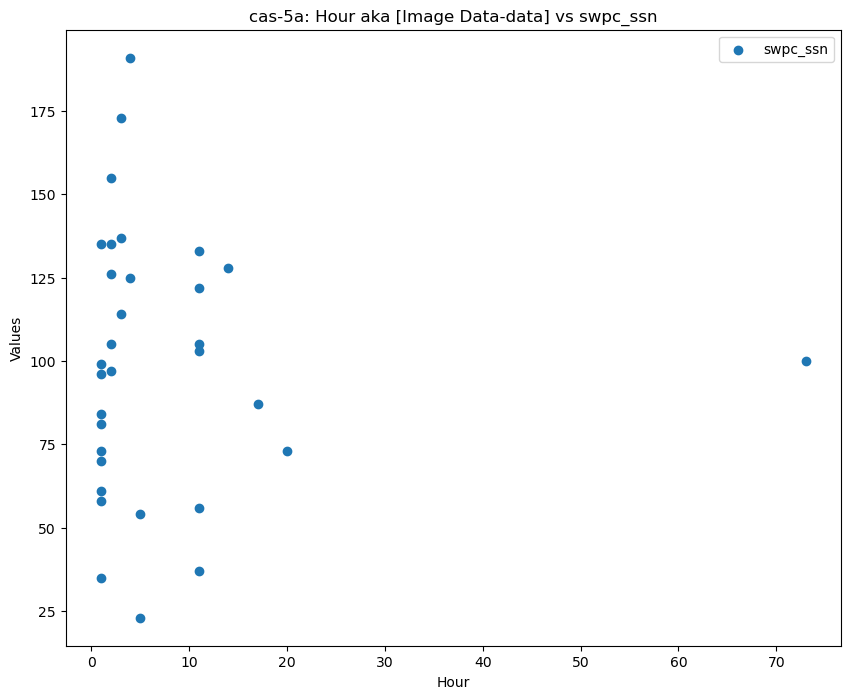

+-------+----------+------------+
|       |   Minute |   swpc_ssn |
|-------+----------+------------|
| count |  32      |    32      |
| mean  |  36.2812 |    99.0938 |
| std   |  18.1876 |    39.7454 |
| min   |   1      |    23      |
| 25%   |  22.5    |    72.25   |
| 50%   |  45      |    99.5    |
| 75%   |  51.25   |   126.5    |
| max   |  56      |   191      |
+-------+----------+------------+
Correlation [Minute] vs [swpc_ssn]: pearson=[-0.3881385503930872], spearman=[-0.3526120201330666], kendall_tau=[-0.2500131233458113]


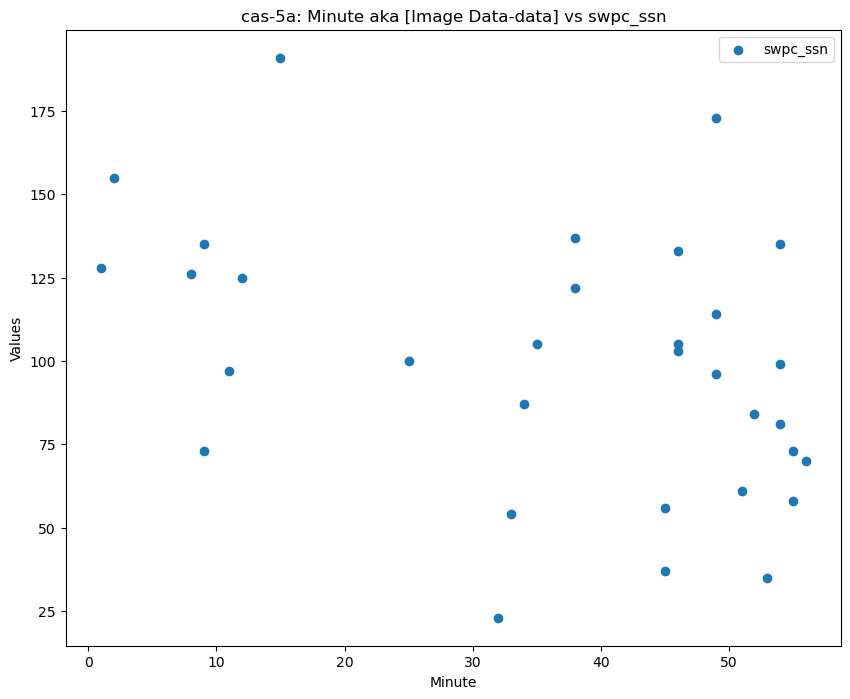

+-------+----------+------------+
|       |   Second |   swpc_ssn |
|-------+----------+------------|
| count |  32      |    32      |
| mean  |  29.625  |    99.0938 |
| std   |  18.9936 |    39.7454 |
| min   |   4      |    23      |
| 25%   |  14.75   |    72.25   |
| 50%   |  27      |    99.5    |
| 75%   |  50      |   126.5    |
| max   |  59      |   191      |
+-------+----------+------------+
Correlation [Second] vs [swpc_ssn]: pearson=[-0.4251252145785767], spearman=[-0.3605988063219696], kendall_tau=[-0.245914547553257]


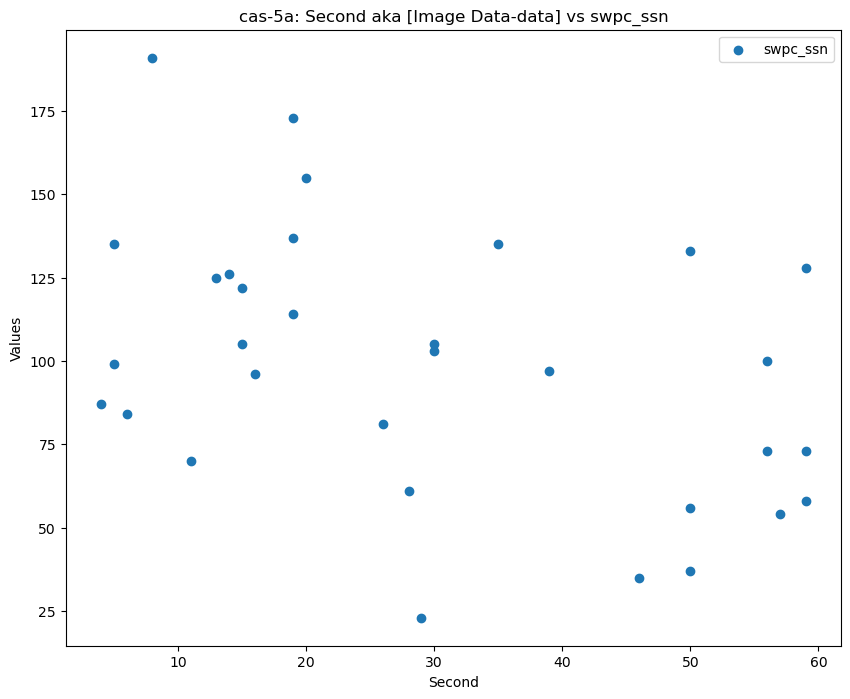

+-------+----------+------------+
|       |    CAM # |   swpc_ssn |
|-------+----------+------------|
| count | 32       |    32      |
| mean  |  2.28125 |    99.0938 |
| std   |  4.20625 |    39.7454 |
| min   |  1       |    23      |
| 25%   |  1       |    72.25   |
| 50%   |  1       |    99.5    |
| 75%   |  2       |   126.5    |
| max   | 25       |   191      |
+-------+----------+------------+
Correlation [CAM #] vs [swpc_ssn]: pearson=[0.023570647283331712], spearman=[0.0546746088293006], kendall_tau=[0.0623023652108739]


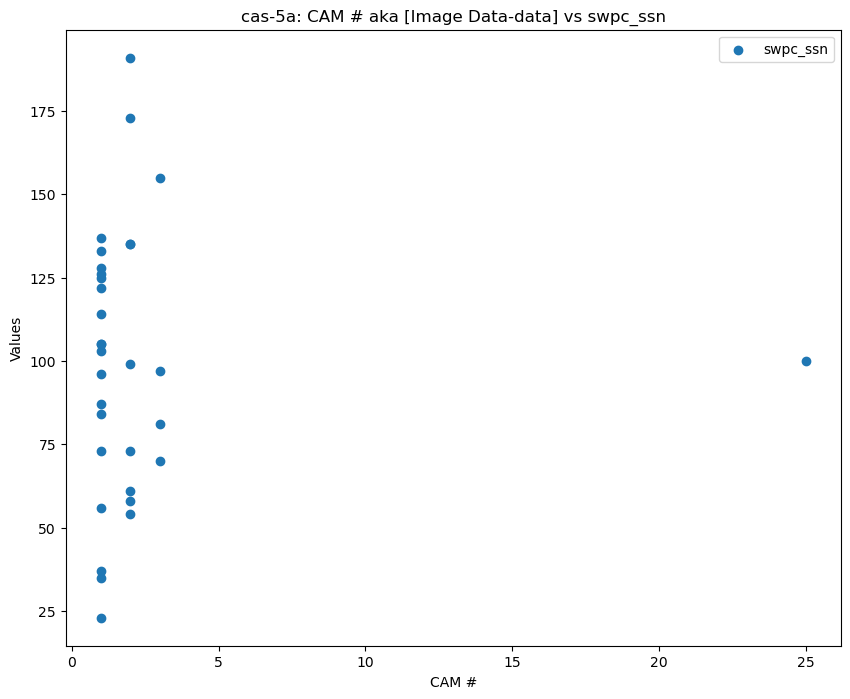

+-------+-----------+------------+
|       |   Photo # |   swpc_ssn |
|-------+-----------+------------|
| count |   32      |    32      |
| mean  |   46.375  |    99.0938 |
| std   |   96.6856 |    39.7454 |
| min   |    5      |    23      |
| 25%   |   20.5    |    72.25   |
| 50%   |   33      |    99.5    |
| 75%   |   42.25   |   126.5    |
| max   |  571      |   191      |
+-------+-----------+------------+
Correlation [Photo #] vs [swpc_ssn]: pearson=[-0.0008488822918718363], spearman=[-0.14342044993818462], kendall_tau=[-0.09543152126132898]


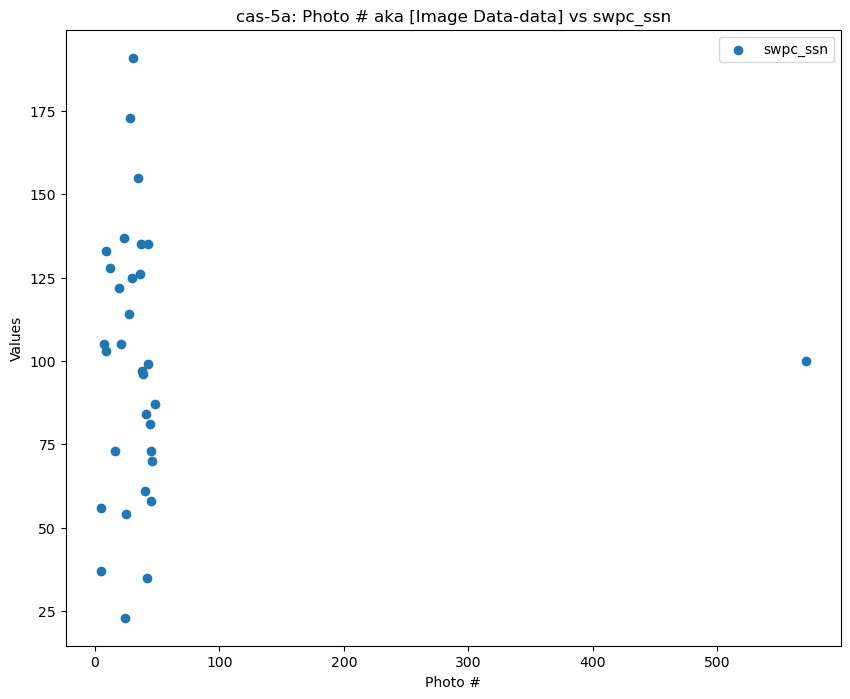

+-------+-----------+------------+
|       |   Frm Len |   swpc_ssn |
|-------+-----------+------------|
| count |    32     |    32      |
| mean  |   473.562 |    99.0938 |
| std   |  1230.72  |    39.7454 |
| min   |   256     |    23      |
| 25%   |   256     |    72.25   |
| 50%   |   256     |    99.5    |
| 75%   |   256     |   126.5    |
| max   |  7218     |   191      |
+-------+-----------+------------+
Correlation [Frm Len] vs [swpc_ssn]: pearson=[0.004160772043172696], spearman=[0.009728847493313403], kendall_tau=[0.008089015981310748]


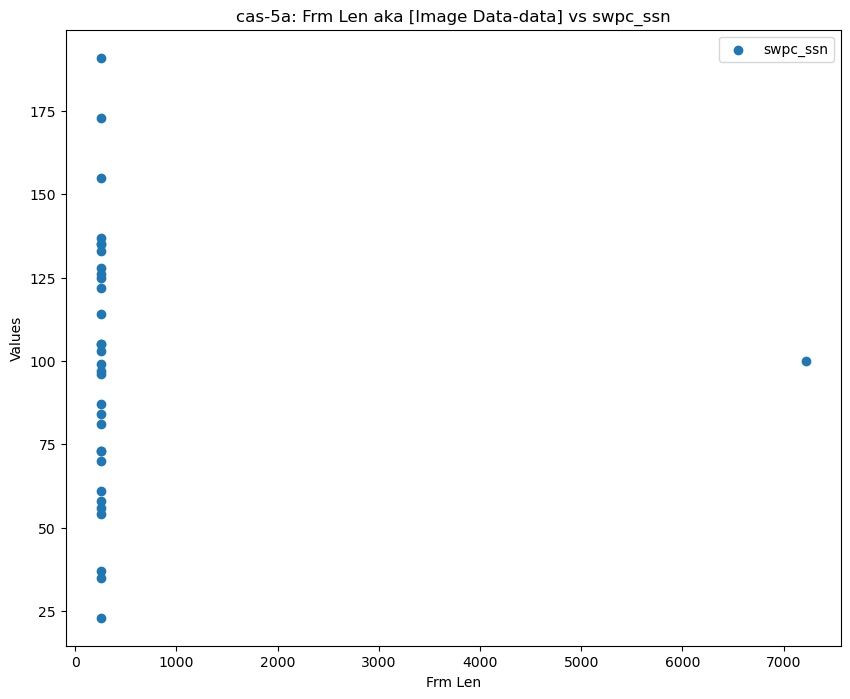

+-------+--------------+------------+
|       |   Frm Seq Nr |   swpc_ssn |
|-------+--------------+------------|
| count |       32     |    32      |
| mean  |     1824.12  |    99.0938 |
| std   |     8744.21  |    39.7454 |
| min   |       53     |    23      |
| 25%   |      207.125 |    72.25   |
| 50%   |      271.75  |    99.5    |
| 75%   |      332.5   |   126.5    |
| max   |    49739     |   191      |
+-------+--------------+------------+
Correlation [Frm Seq Nr] vs [swpc_ssn]: pearson=[0.006504439175418133], spearman=[0.14191419380456588], kendall_tau=[0.08502041711162331]


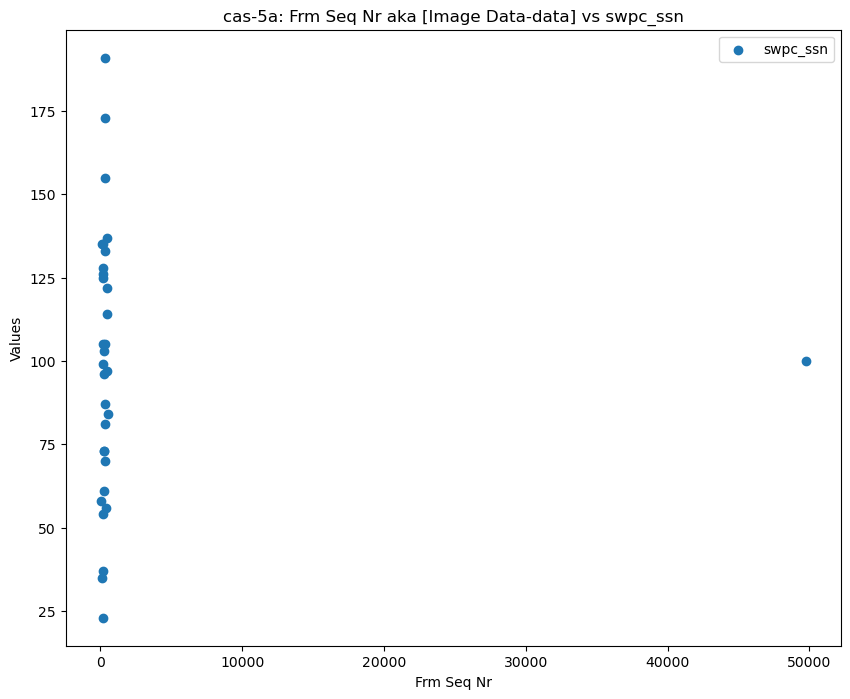

+-------+----------+------------+
|       |    Total |   swpc_ssn |
|-------+----------+------------|
| count |    32    |    32      |
| mean  |  1423.69 |    99.0938 |
| std   |  4479.42 |    39.7454 |
| min   |   243    |    23      |
| 25%   |   456.25 |    72.25   |
| 50%   |   579    |    99.5    |
| 75%   |   744.25 |   126.5    |
| max   | 25928    |   191      |
+-------+----------+------------+
Correlation [Total] vs [swpc_ssn]: pearson=[0.011064596270161164], spearman=[0.16331776925627284], kendall_tau=[0.11836956546454111]


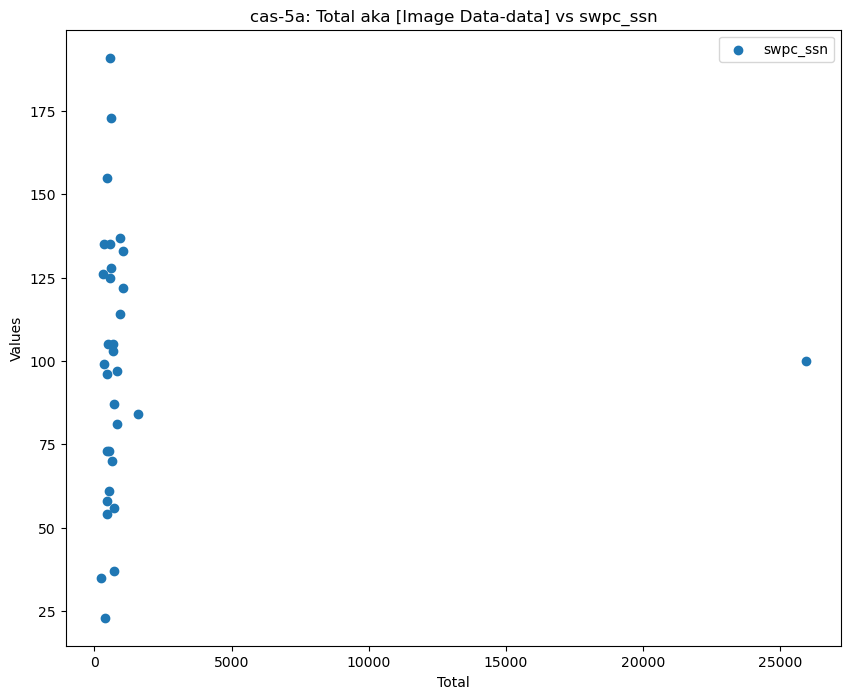

+-------+------------------------------------+------------+
|       |   observer where 0 is DK3WN-JN49lr |   swpc_ssn |
|-------+------------------------------------+------------|
| count |                                  1 |          1 |
| mean  |                                  0 |         33 |
| std   |                                nan |        nan |
| min   |                                  0 |         33 |
| 25%   |                                  0 |         33 |
| 50%   |                                  0 |         33 |
| 75%   |                                  0 |         33 |
| max   |                                  0 |         33 |
+-------+------------------------------------+------------+
Correlation [observer where 0 is DK3WN-JN49lr] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendall_tau=[nan]


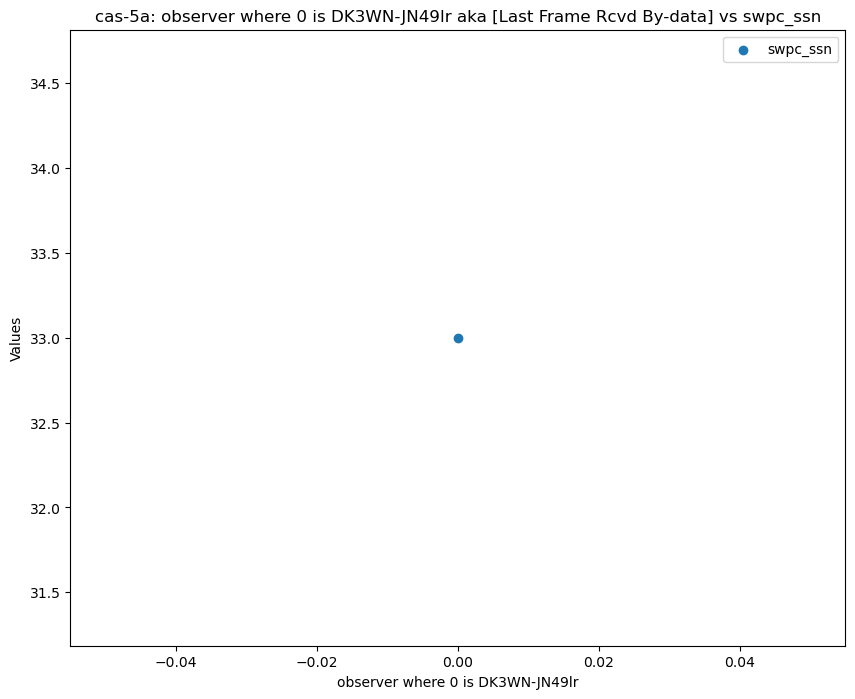

In [546]:
analyze_satellite('cas-5a')

+-------+------------------+------------+
|       |   43666.distinct |   swpc_ssn |
|-------+------------------+------------|
| count |       118        |   118      |
| mean  |         4.80042  |    43.7203 |
| std   |         0.306796 |    45.0096 |
| min   |         3.1      |     0      |
| 25%   |         4.8      |    11      |
| 50%   |         4.9      |    25      |
| 75%   |         4.95     |    76.5    |
| max   |         5.05     |   176      |
+-------+------------------+------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[0.18077471127101538], spearman=[0.265121452157792], kendall_tau=[0.19735697842488076]


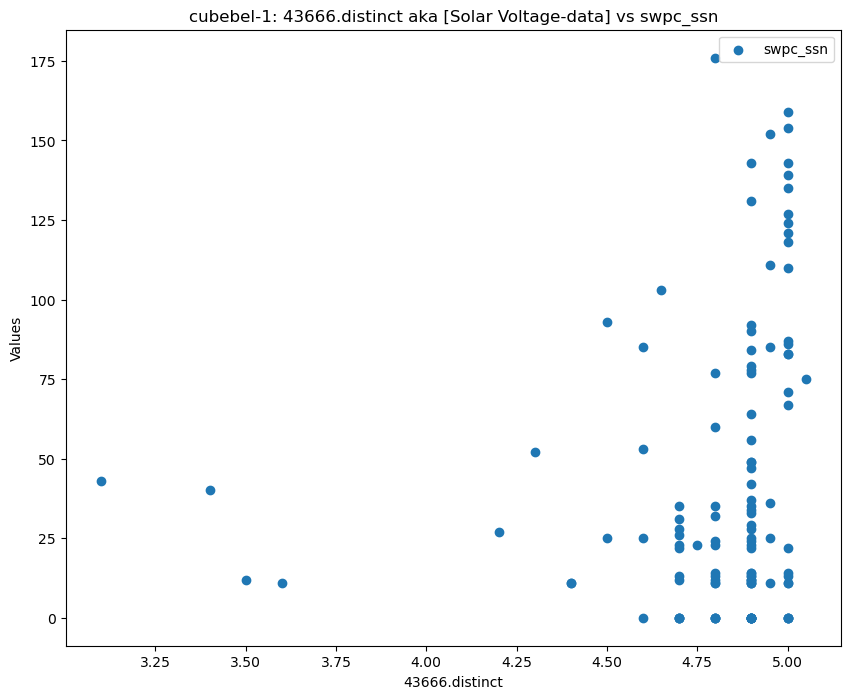

+-------+------------------+------------+
|       |   43666.distinct |   swpc_ssn |
|-------+------------------+------------|
| count |       118        |   118      |
| mean  |         3.27627  |    43.7203 |
| std   |         0.306532 |    45.0096 |
| min   |         0        |     0      |
| 25%   |         3.3      |    11      |
| 50%   |         3.3      |    25      |
| 75%   |         3.3      |    76.5    |
| max   |         3.7      |   176      |
+-------+------------------+------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[-0.026503596099076522], spearman=[-0.10026909635421952], kendall_tau=[-0.08259265975656294]


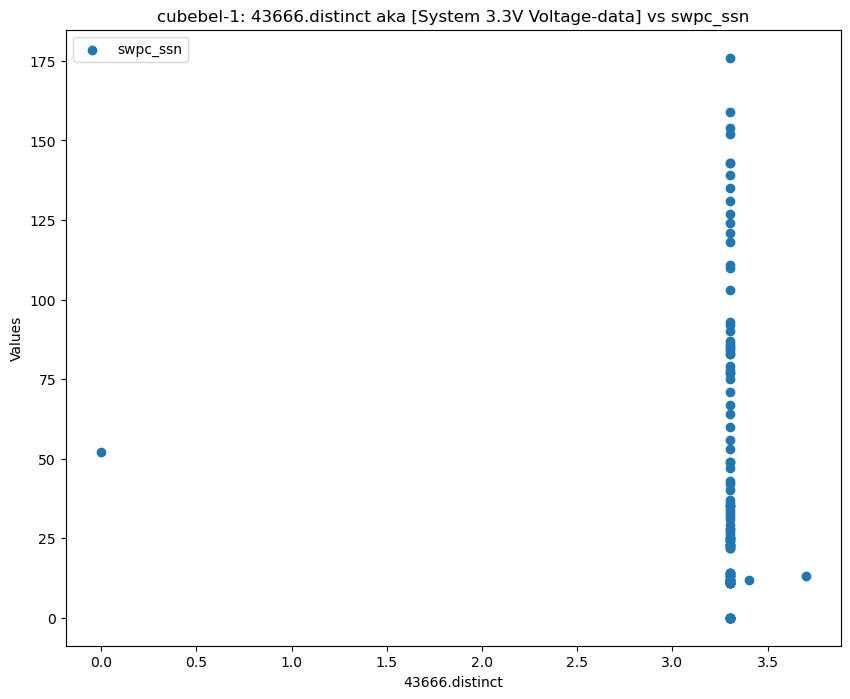

+-------+------------------+------------+
|       |   43666.distinct |   swpc_ssn |
|-------+------------------+------------|
| count |       118        |   118      |
| mean  |         5.11318  |    43.7203 |
| std   |         0.472957 |    45.0096 |
| min   |         0.055    |     0      |
| 25%   |         5.1      |    11      |
| 50%   |         5.2      |    25      |
| 75%   |         5.2      |    76.5    |
| max   |         5.2      |   176      |
+-------+------------------+------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[-0.010007486535809882], spearman=[0.05107073212261531], kendall_tau=[0.034547510107492956]


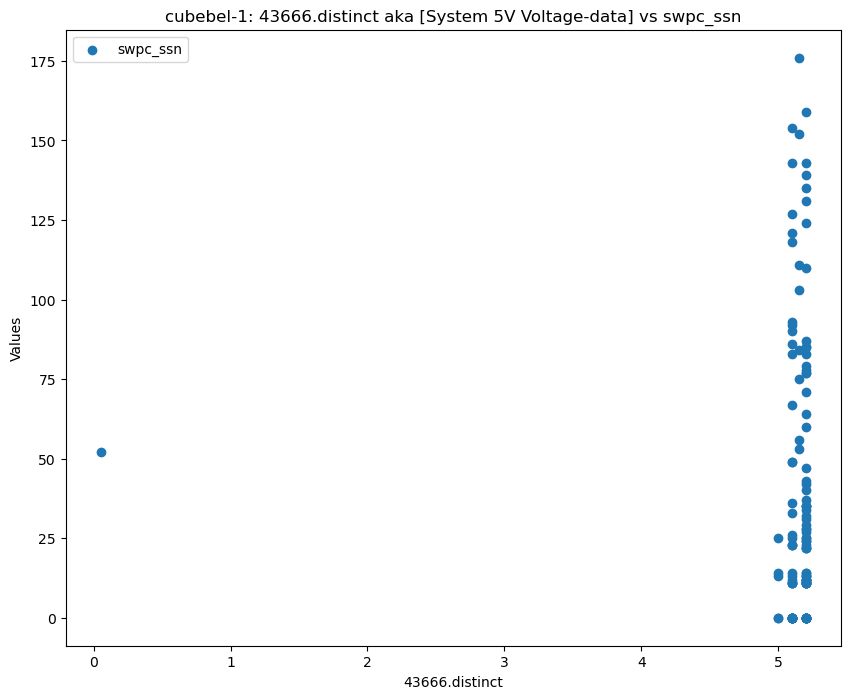

+-------+--------------------+------------+
|       |   After BQ Current |   swpc_ssn |
|-------+--------------------+------------|
| count |           626      |   626      |
| mean  |           147.928  |    24.5767 |
| std   |            42.4223 |    29.9056 |
| min   |             1.7    |     0      |
| 25%   |           131.625  |    11      |
| 50%   |           141      |    14      |
| 75%   |           159.5    |    28.75   |
| max   |           683      |   176      |
+-------+--------------------+------------+
Correlation [After BQ Current] vs [swpc_ssn]: pearson=[-0.25236920606970487], spearman=[-0.2843878766329617], kendall_tau=[-0.20113822861732475]


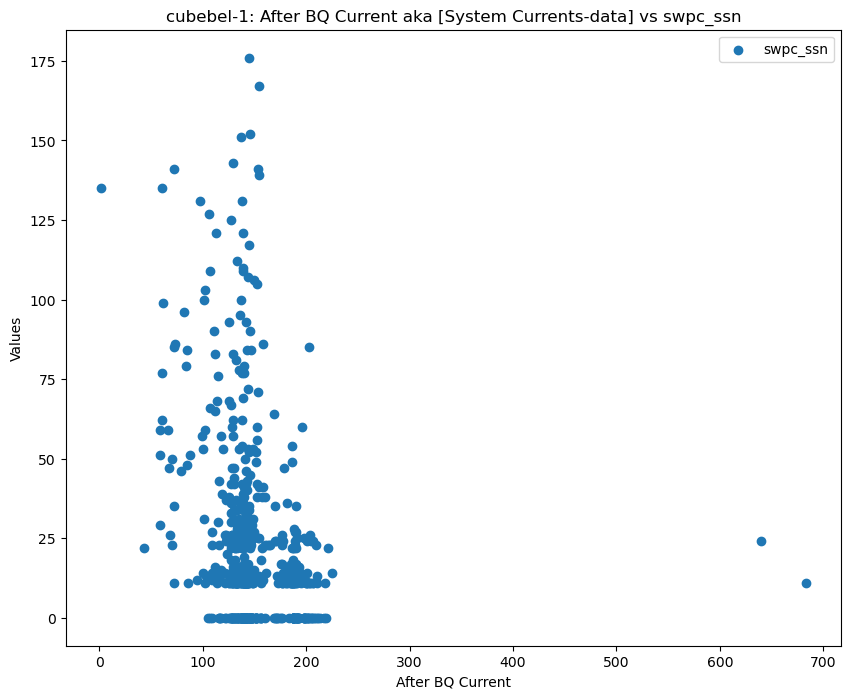

In [547]:
analyze_satellite('cubebel-1')

+-------+----------------------------------+------------+
|       |   tlm_mb_solarpanel_0_volt_pos V |   swpc_ssn |
|-------+----------------------------------+------------|
| count |                       224        |   224      |
| mean  |                         4.93581  |   115.875  |
| std   |                         0.726483 |    39.7821 |
| min   |                         0.0021   |    25      |
| 25%   |                         5        |    88.75   |
| 50%   |                         5.075    |   119      |
| 75%   |                         5.2      |   142.25   |
| max   |                         5.5      |   227      |
+-------+----------------------------------+------------+
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [swpc_ssn]: pearson=[-0.022017819056829396], spearman=[0.12979653332133329], kendall_tau=[0.0949366866190805]


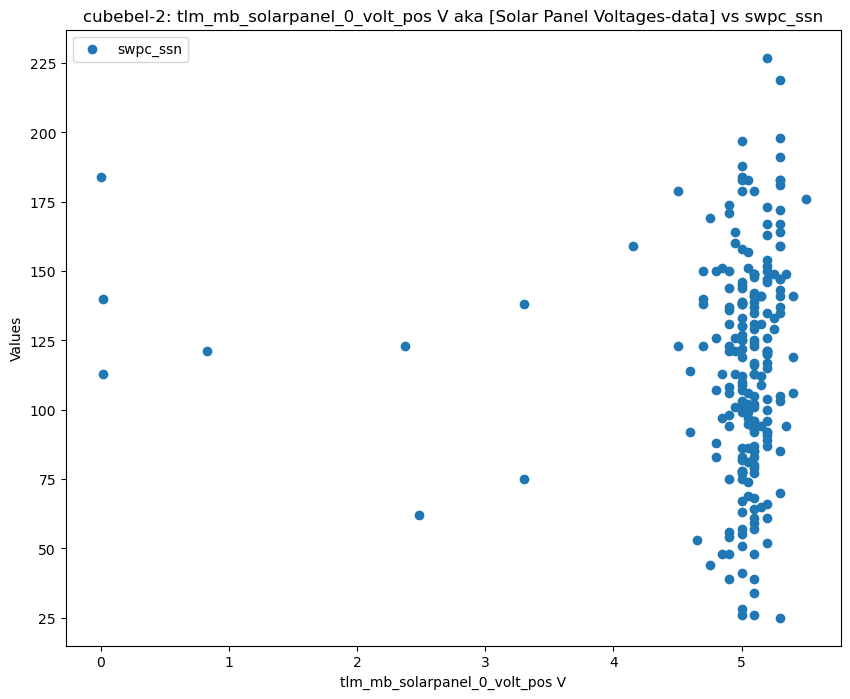

+-------+--------------------+------------+
|       |   57175.distinct A |   swpc_ssn |
|-------+--------------------+------------|
| count |          34        |    34      |
| mean  |           0.264706 |   116.647  |
| std   |           0.120309 |    37.0216 |
| min   |           0        |    28      |
| 25%   |           0.2      |    95      |
| 50%   |           0.2      |   121      |
| 75%   |           0.375    |   138      |
| max   |           0.5      |   179      |
+-------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.3230075753530439], spearman=[0.30822504540385015], kendall_tau=[0.25260828562166626]


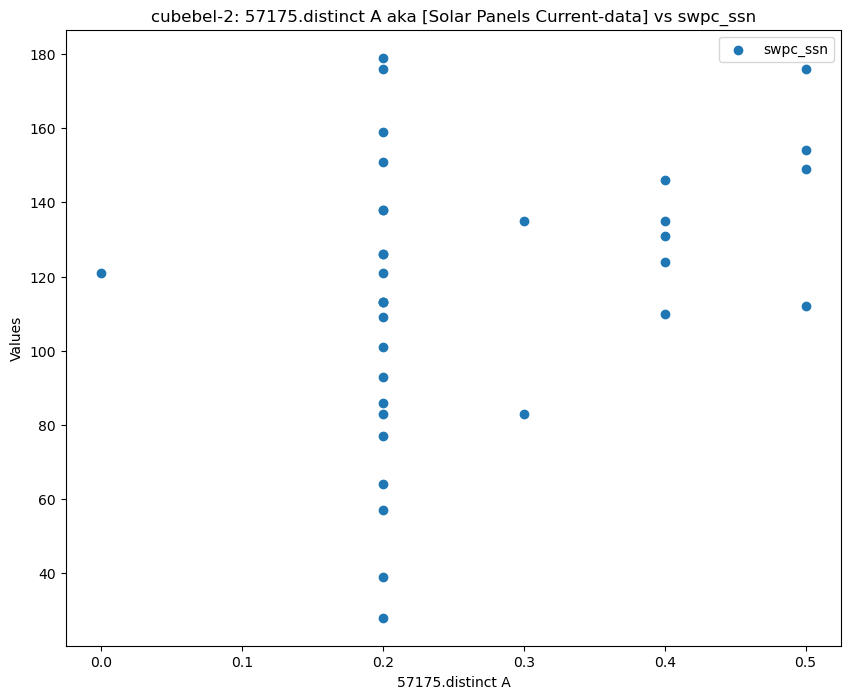

+-------+--------------------+------------+
|       |   57175.distinct A |   swpc_ssn |
|-------+--------------------+------------|
| count |        34          |    34      |
| mean  |         0.0997059  |   116.647  |
| std   |         0.00171499 |    37.0216 |
| min   |         0.09       |    28      |
| 25%   |         0.1        |    95      |
| 50%   |         0.1        |   121      |
| 75%   |         0.1        |   138      |
| max   |         0.1        |   179      |
+-------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[-0.28327781844254746], spearman=[-0.2663581252763734], kendall_tau=[-0.2222771122371935]


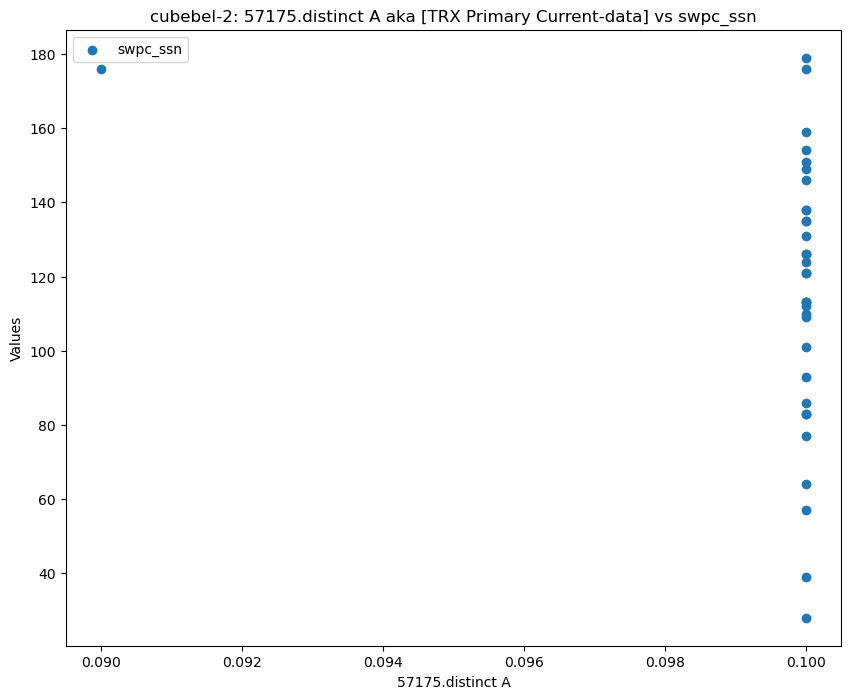

+-------+--------------------+------------+
|       |   57175.distinct A |   swpc_ssn |
|-------+--------------------+------------|
| count |        34          |    34      |
| mean  |         0.0983824  |   116.647  |
| std   |         0.00342021 |    37.0216 |
| min   |         0.09       |    28      |
| 25%   |         0.1        |    95      |
| 50%   |         0.1        |   121      |
| 75%   |         0.1        |   138      |
| max   |         0.1        |   179      |
+-------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.15091190530418408], spearman=[0.16597661479923714], kendall_tau=[0.1260903130077535]


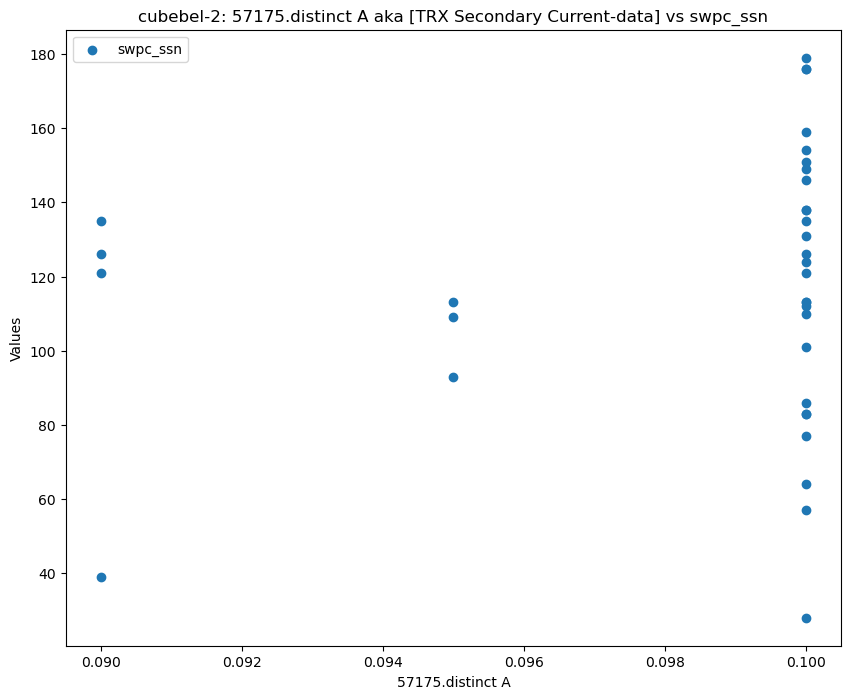

+-------+-----------------------+------------+
|       |   57175.distinct (°C) |   swpc_ssn |
|-------+-----------------------+------------|
| count |               35      |    35      |
| mean  |               21.7416 |   116.771  |
| std   |               39.5923 |    36.4805 |
| min   |               10.38   |    28      |
| 25%   |               12.625  |    97      |
| 50%   |               15.19   |   121      |
| 75%   |               16.22   |   138      |
| max   |              248.13   |   179      |
+-------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.2841065280256999], spearman=[0.03975043040790226], kendall_tau=[0.02891223361951317]


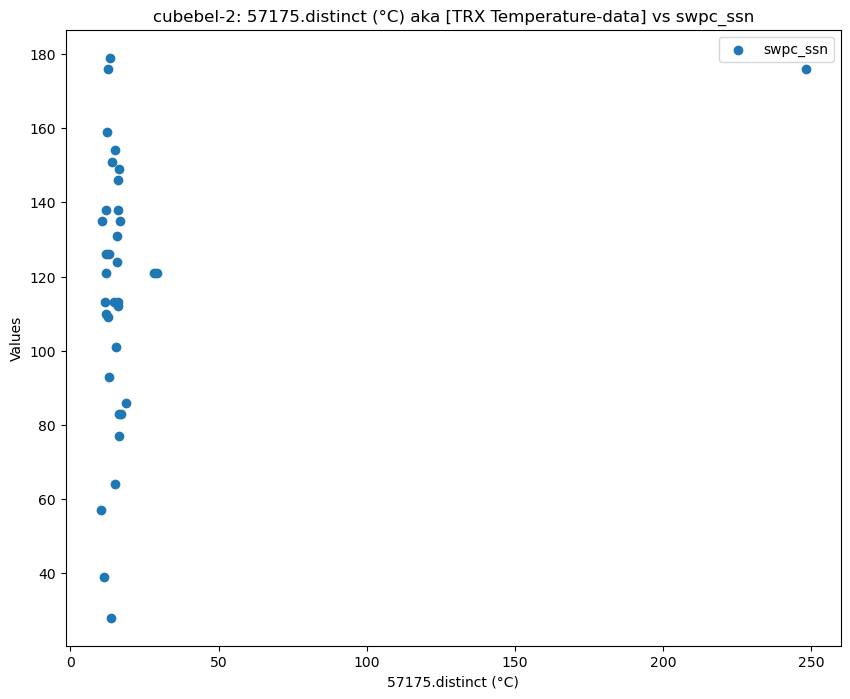

+-------+-----------------------------+------------+
|       |   tlm_trx_cmn_mcu_temp (°C) |   swpc_ssn |
|-------+-----------------------------+------------|
| count |                   225       |   225      |
| mean  |                    11.6267  |   115.973  |
| std   |                     3.88544 |    39.7206 |
| min   |                    -0.5     |    25      |
| 25%   |                     9       |    89      |
| 50%   |                    12       |   119      |
| 75%   |                    14.5     |   142      |
| max   |                    28       |   227      |
+-------+-----------------------------+------------+
Correlation [tlm_trx_cmn_mcu_temp (°C)] vs [swpc_ssn]: pearson=[-0.1335898597307741], spearman=[-0.1267867890514931], kendall_tau=[-0.08656788064704421]


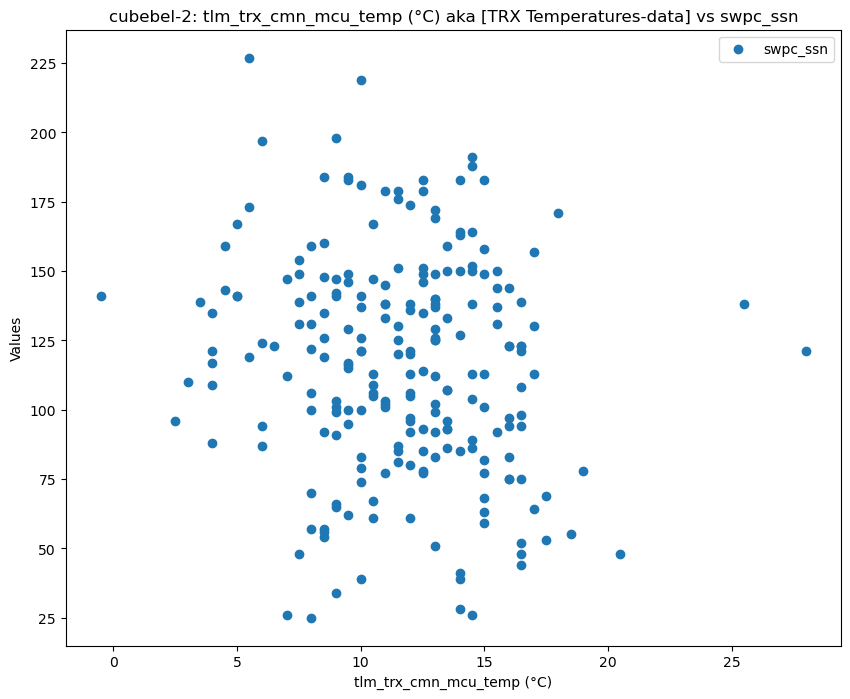

+-------+--------------------+------------+
|       |   tlm_mb_ant_1_v V |   swpc_ssn |
|-------+--------------------+------------|
| count |      224           |   224      |
| mean  |        0.00827813  |   115.875  |
| std   |        0.000409215 |    39.7821 |
| min   |        0.0035      |    25      |
| 25%   |        0.0084      |    88.75   |
| 50%   |        0.0084      |   119      |
| 75%   |        0.0084      |   142.25   |
| max   |        0.0091      |   227      |
+-------+--------------------+------------+
Correlation [tlm_mb_ant_1_v V] vs [swpc_ssn]: pearson=[0.004844633466461593], spearman=[-0.0020850223016425323], kendall_tau=[-0.0016313239741044382]


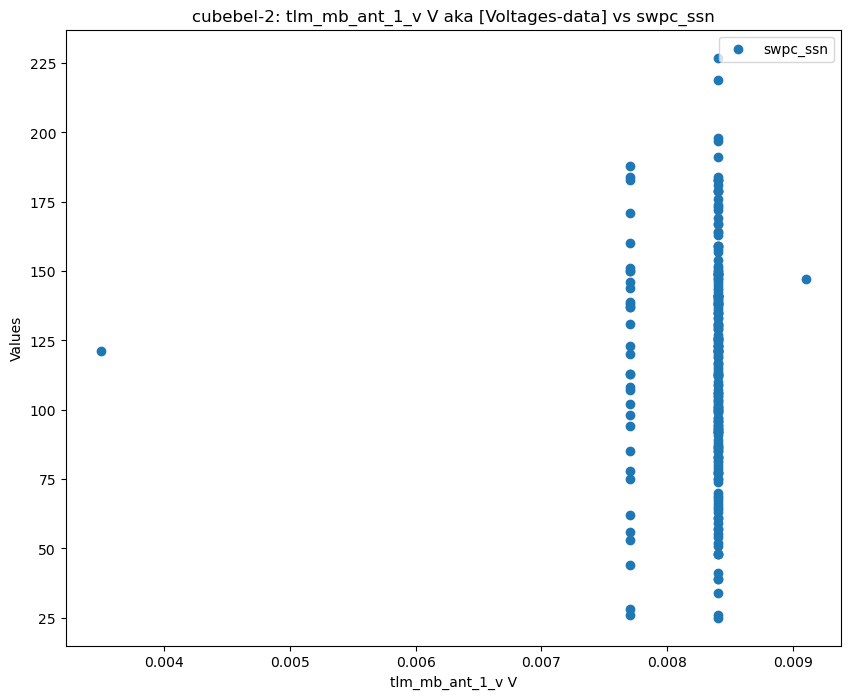

+-------+--------------------------+------------+
|       |   tlm_mb_adc_temp_1 (°C) |   swpc_ssn |
|-------+--------------------------+------------|
| count |                 224      |   224      |
| mean  |                  21.331  |   115.875  |
| std   |                  74.8435 |    39.7821 |
| min   |                   2.6    |    25      |
| 25%   |                   6.7    |    88.75   |
| 50%   |                   8.775  |   119      |
| 75%   |                  11      |   142.25   |
| max   |                 505      |   227      |
+-------+--------------------------+------------+
Correlation [tlm_mb_adc_temp_1 (°C)] vs [swpc_ssn]: pearson=[0.014152016835721211], spearman=[-0.10660823483144659], kendall_tau=[-0.07170476343404308]


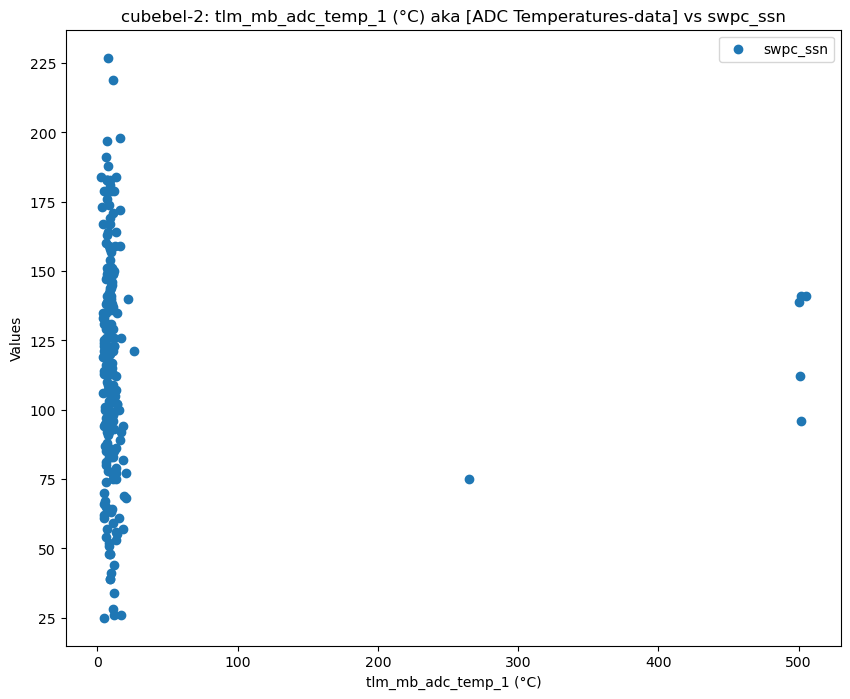

+-------+-----------------------+------------+
|       |   57175.distinct (°C) |   swpc_ssn |
|-------+-----------------------+------------|
| count |               34      |    34      |
| mean  |               49.9857 |   116.647  |
| std   |               84.3248 |    37.0216 |
| min   |               25.85   |    28      |
| 25%   |               33.9862 |    95      |
| 50%   |               36.06   |   121      |
| 75%   |               37.4025 |   138      |
| max   |              527.01   |   179      |
+-------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.28264537697330594], spearman=[0.14495417080322923], kendall_tau=[0.09703821302589397]


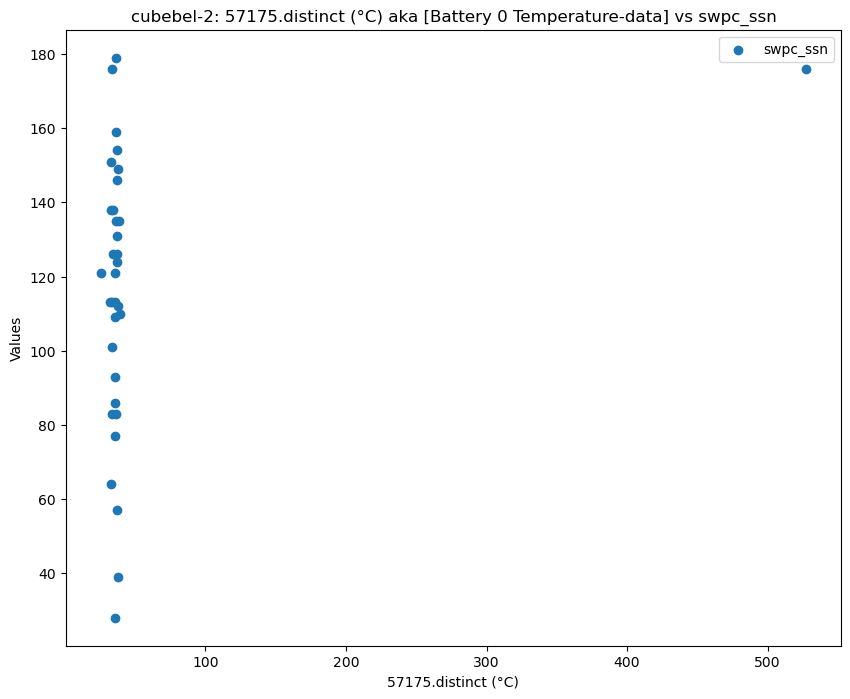

+-------+-----------------------+------------+
|       |   57175.distinct (°C) |   swpc_ssn |
|-------+-----------------------+------------|
| count |               34      |    34      |
| mean  |               49.8893 |   116.647  |
| std   |               84.317  |    37.0216 |
| min   |               26.2    |    28      |
| 25%   |               33.8175 |    95      |
| 50%   |               35.8325 |   121      |
| 75%   |               37.85   |   138      |
| max   |              526.86   |   179      |
+-------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.284701678404755], spearman=[0.161467937097268], kendall_tau=[0.09344420513604605]


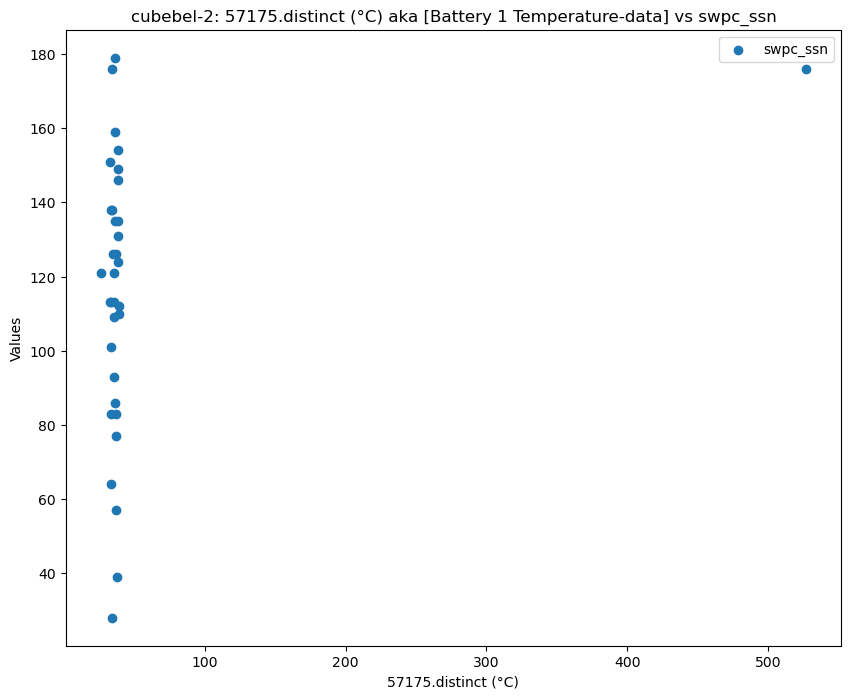

+-------+----------------------------------------------+------------+
|       |   tlm_mb_battpack_0_element_0_current mA (A) |   swpc_ssn |
|-------+----------------------------------------------+------------|
| count |                                     224      |   224      |
| mean  |                                      57.0886 |   115.875  |
| std   |                                      15.9207 |    39.7821 |
| min   |                                      38      |    25      |
| 25%   |                                      52.4    |    88.75   |
| 50%   |                                      52.4    |   119      |
| 75%   |                                      52.4    |   142.25   |
| max   |                                     237.5    |   227      |
+-------+----------------------------------------------+------------+
Correlation [tlm_mb_battpack_0_element_0_current mA (A)] vs [swpc_ssn]: pearson=[0.17798935959472656], spearman=[0.2275503868521716], kendall_tau=[0.17539356203

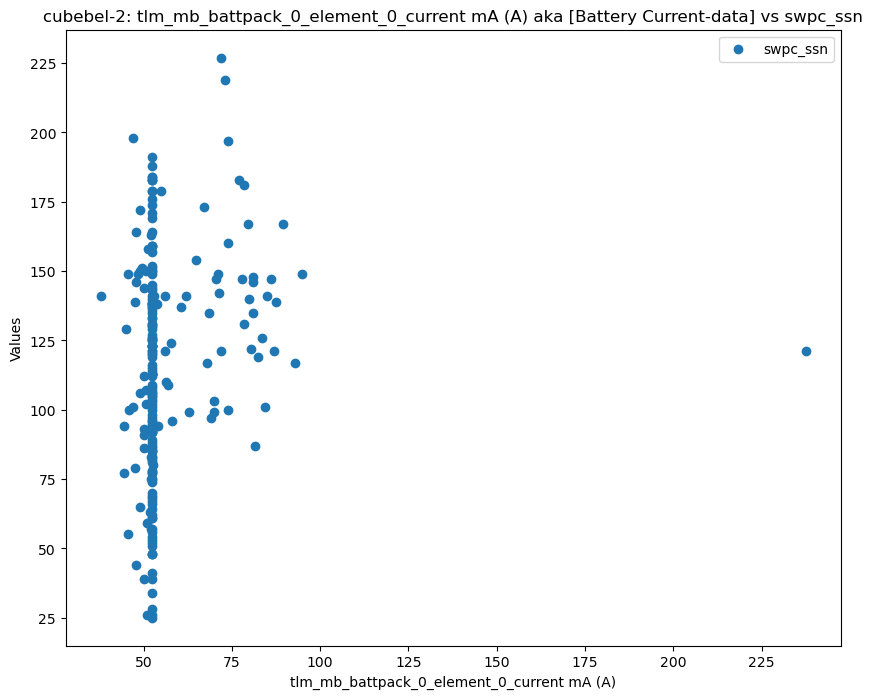

+-------+--------------------+------------+
|       |   57175.distinct A |   swpc_ssn |
|-------+--------------------+------------|
| count |         34         |    34      |
| mean  |          0.0820588 |   116.647  |
| std   |          0.0362675 |    37.0216 |
| min   |          0.06      |    28      |
| 25%   |          0.06      |    95      |
| 50%   |          0.07      |   121      |
| 75%   |          0.09      |   138      |
| max   |          0.26      |   179      |
+-------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.16271631093093558], spearman=[0.2202238104883648], kendall_tau=[0.16324806816797902]


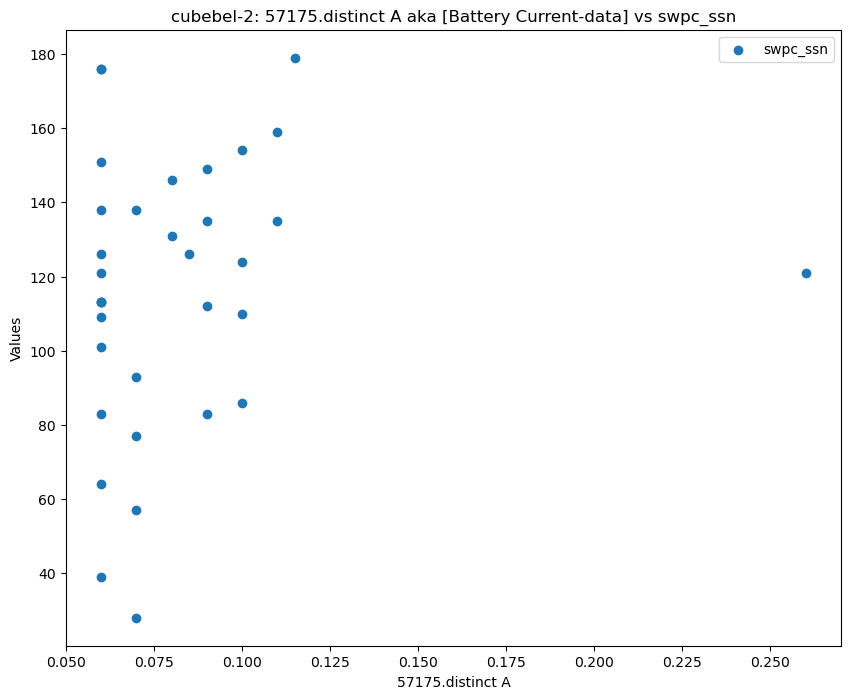

+-------+--------------------+------------+
|       |   57175.distinct V |   swpc_ssn |
|-------+--------------------+------------|
| count |           35       |    35      |
| mean  |            4.82371 |   116.771  |
| std   |            0.1873  |    36.4805 |
| min   |            3.885   |    28      |
| 25%   |            4.825   |    97      |
| 50%   |            4.88    |   121      |
| 75%   |            4.885   |   138      |
| max   |            4.905   |   179      |
+-------+--------------------+------------+
Correlation [57175.distinct V] vs [swpc_ssn]: pearson=[-0.08447683572570787], spearman=[-0.326314095680748], kendall_tau=[-0.24234588591919806]


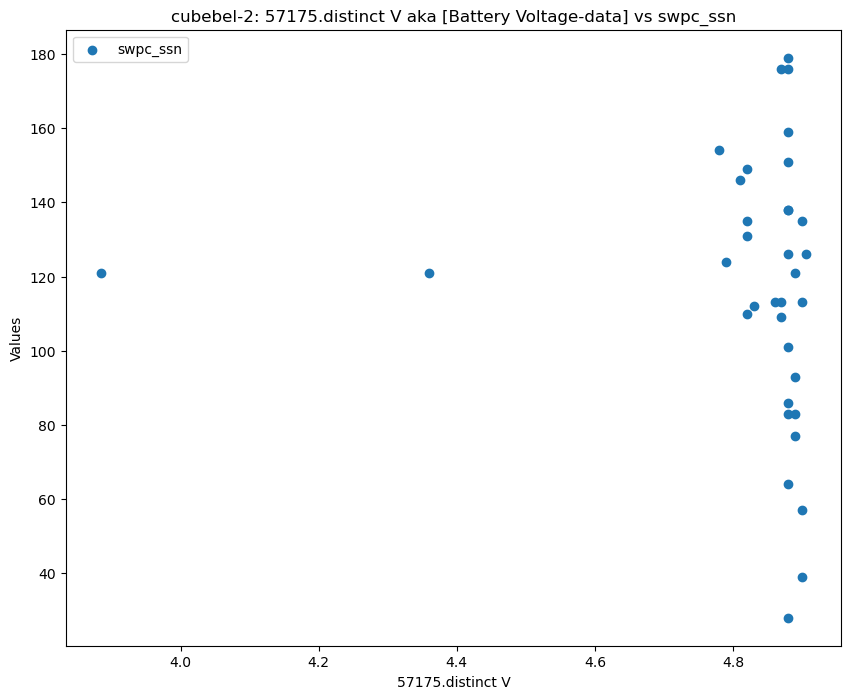

+-------+-----------+------------+
|       |     9V1KG |   swpc_ssn |
|-------+-----------+------------|
| count | 1449      |  1449      |
| mean  |   14.0242 |    62.7481 |
| std   |   42.9915 |    52.0369 |
| min   |    0      |     0      |
| 25%   |    0      |    14      |
| 50%   |    0      |    52      |
| 75%   |    0      |   101      |
| max   |  230      |   227      |
+-------+-----------+------------+
Correlation [9V1KG] vs [swpc_ssn]: pearson=[0.314838698950454], spearman=[0.4074446470220524], kendall_tau=[0.32326963017393173]


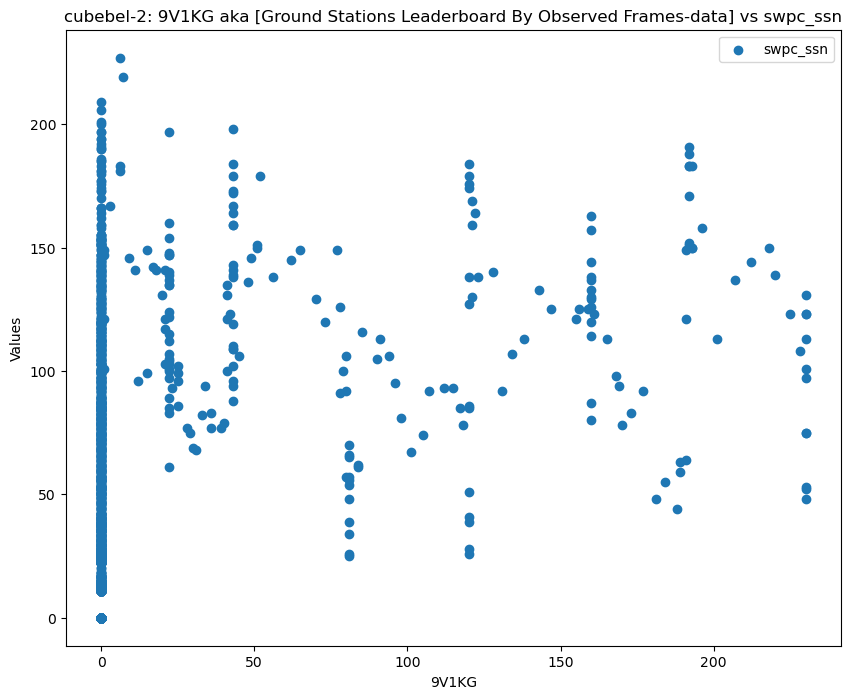

+-------+---------------------+------------+
|       |   57175.tlm_mb_time |   swpc_ssn |
|-------+---------------------+------------|
| count |               224   |   224      |
| mean  |             33303   |   115.875  |
| std   |             12234.4 |    39.7821 |
| min   |               570   |    25      |
| 25%   |             25776.2 |    88.75   |
| 50%   |             34071.2 |   119      |
| 75%   |             40542.5 |   142.25   |
| max   |             60800   |   227      |
+-------+---------------------+------------+
Correlation [57175.tlm_mb_time] vs [swpc_ssn]: pearson=[-0.03920938837919507], spearman=[-0.0218143563391009], kendall_tau=[-0.016273330110514843]


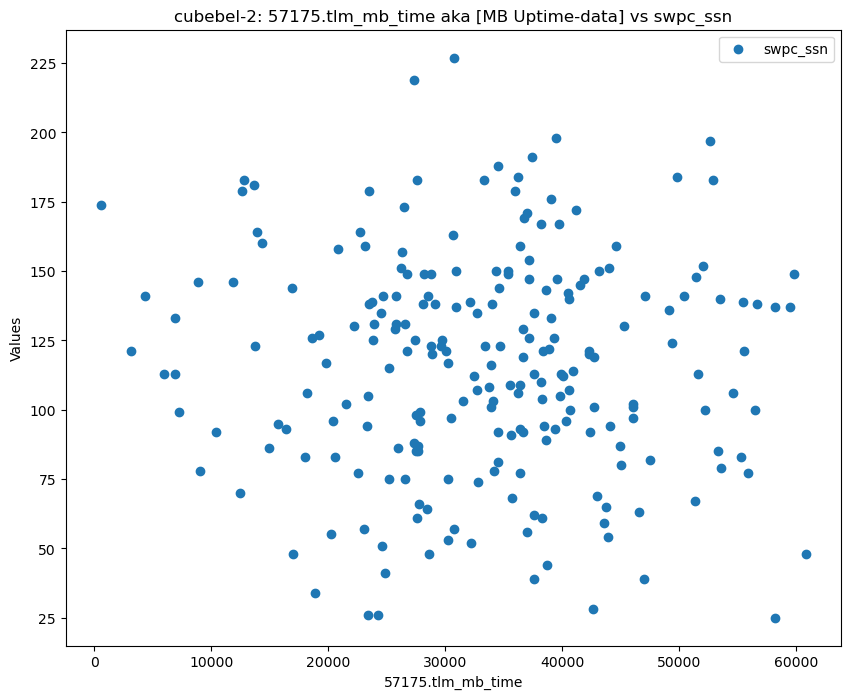

+-------+--------------------------+------------+
|       |   beacon_reset_total_cnt |   swpc_ssn |
|-------+--------------------------+------------|
| count |                 225      |   225      |
| mean  |                 127.207  |   115.973  |
| std   |                  43.5454 |    39.7206 |
| min   |                  22.5    |    25      |
| 25%   |                  93      |    89      |
| 50%   |                 131      |   119      |
| 75%   |                 159.5    |   142      |
| max   |                 218      |   227      |
+-------+--------------------------+------------+
Correlation [beacon_reset_total_cnt] vs [swpc_ssn]: pearson=[0.06291851285053665], spearman=[0.048072551536734835], kendall_tau=[0.0319259705060527]


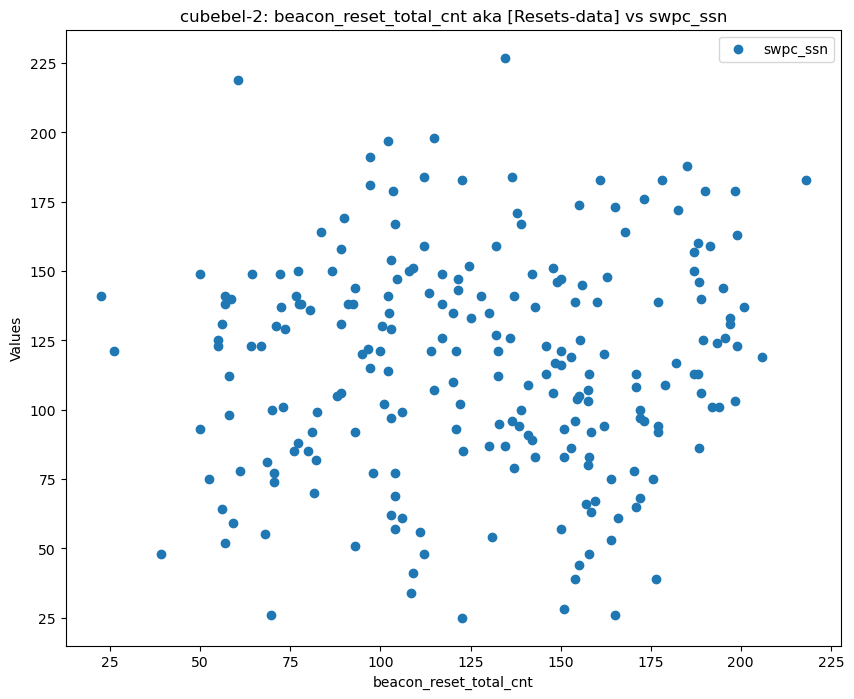

+-------+----------------------------------+------------+
|       |   57175.tlm_trx_cmn_rtc_unixtime |   swpc_ssn |
|-------+----------------------------------+------------|
| count |                    225           |   225      |
| mean  |                      1.69403e+12 |   115.973  |
| std   |                      3.22324e+09 |    39.7206 |
| min   |                      1.68429e+12 |    25      |
| 25%   |                      1.69194e+12 |    89      |
| 50%   |                      1.69433e+12 |   119      |
| 75%   |                      1.69664e+12 |   142      |
| max   |                      1.69907e+12 |   227      |
+-------+----------------------------------+------------+
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [swpc_ssn]: pearson=[-0.13889752612342934], spearman=[-0.09706790264121769], kendall_tau=[-0.0754699340282181]


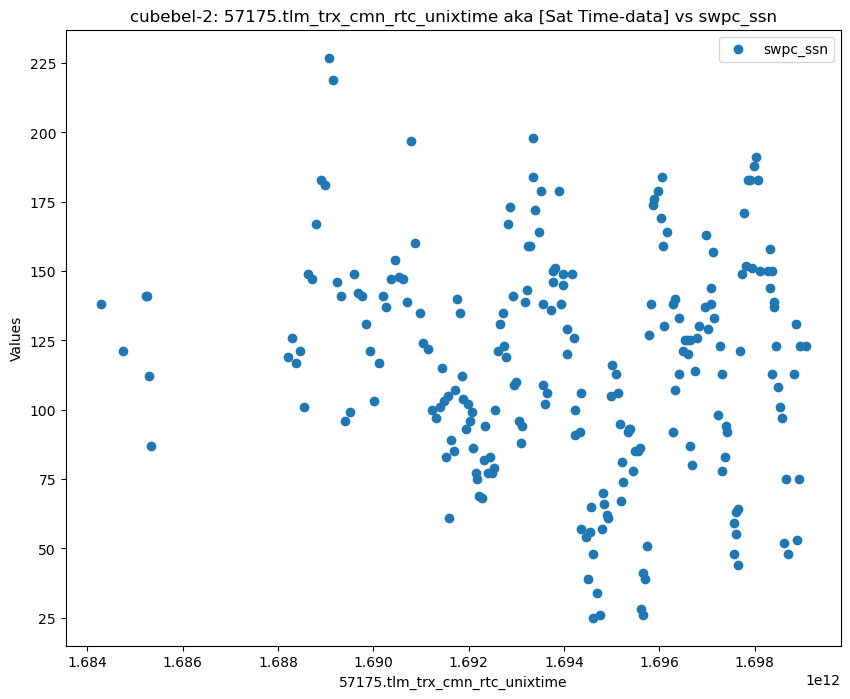

+-------+--------------------------------------+------------+
|       |   tlm_mb_solarpanel_1_current(mA) mA |   swpc_ssn |
|-------+--------------------------------------+------------|
| count |                              224     |   224      |
| mean  |                               88.733 |   115.875  |
| std   |                              108.417 |    39.7821 |
| min   |                                2.4   |    25      |
| 25%   |                               20     |    88.75   |
| 50%   |                               30     |   119      |
| 75%   |                              125.875 |   142.25   |
| max   |                              460     |   227      |
+-------+--------------------------------------+------------+
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [swpc_ssn]: pearson=[0.20173819779186652], spearman=[0.07968407444748127], kendall_tau=[0.06010973755836026]


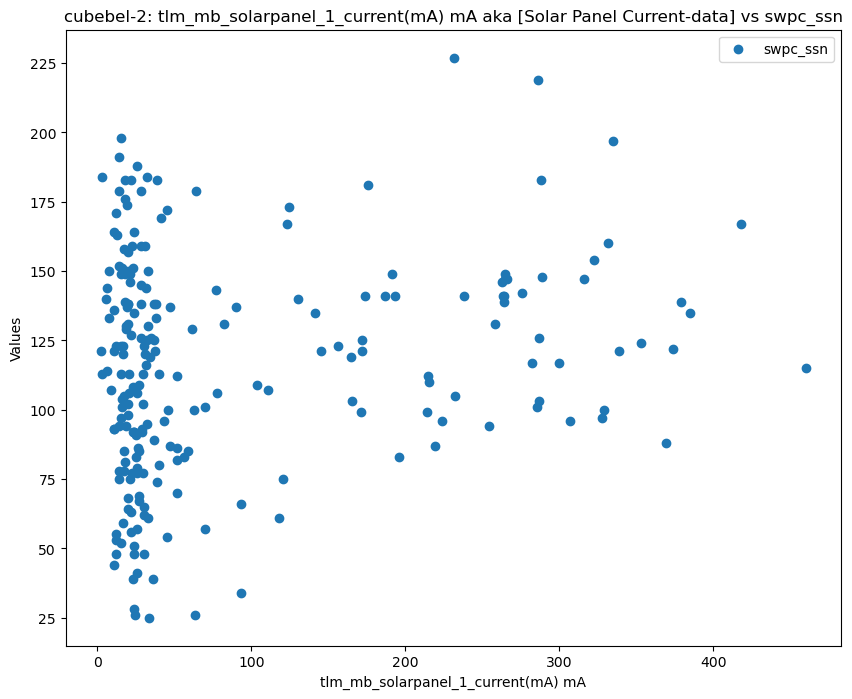

+-------+----------------------------------+------------+
|       |   tlm_mb_solartemp_0_temp_0 (°C) |   swpc_ssn |
|-------+----------------------------------+------------|
| count |                         224      |   224      |
| mean  |                          13.2554 |   115.875  |
| std   |                          27.681  |    39.7821 |
| min   |                           3.9    |    25      |
| 25%   |                           8.075  |    88.75   |
| 50%   |                           9.9    |   119      |
| 75%   |                          12      |   142.25   |
| max   |                         251      |   227      |
+-------+----------------------------------+------------+
Correlation [tlm_mb_solartemp_0_temp_0 (°C)] vs [swpc_ssn]: pearson=[0.03439559144282096], spearman=[-0.06737836516699401], kendall_tau=[-0.0422978850555732]


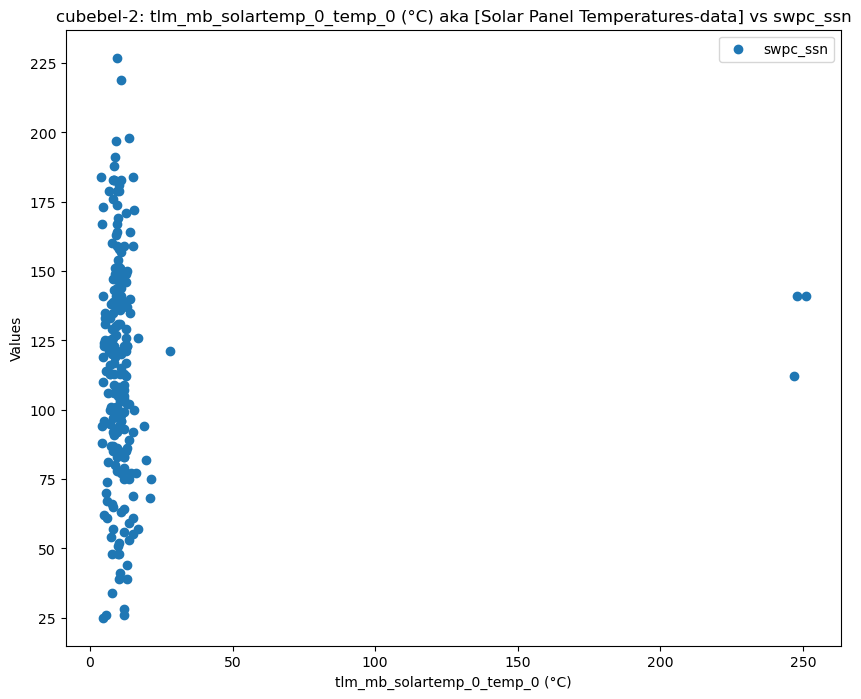

In [548]:
analyze_satellite('cubebel-2')

+-------+-----------+------------+
|       |   Current |   swpc_ssn |
|-------+-----------+------------|
| count | 706       |   706      |
| mean  |  40.6091  |    99.2663 |
| std   |   8.41967 |    41.7192 |
| min   |  30       |     0      |
| 25%   |  33       |    68.25   |
| 50%   |  38       |    97      |
| 75%   |  52       |   129      |
| max   |  64       |   227      |
+-------+-----------+------------+
Correlation [Current] vs [swpc_ssn]: pearson=[-0.04249925894302116], spearman=[-0.0580247347444164], kendall_tau=[-0.039862636061729]


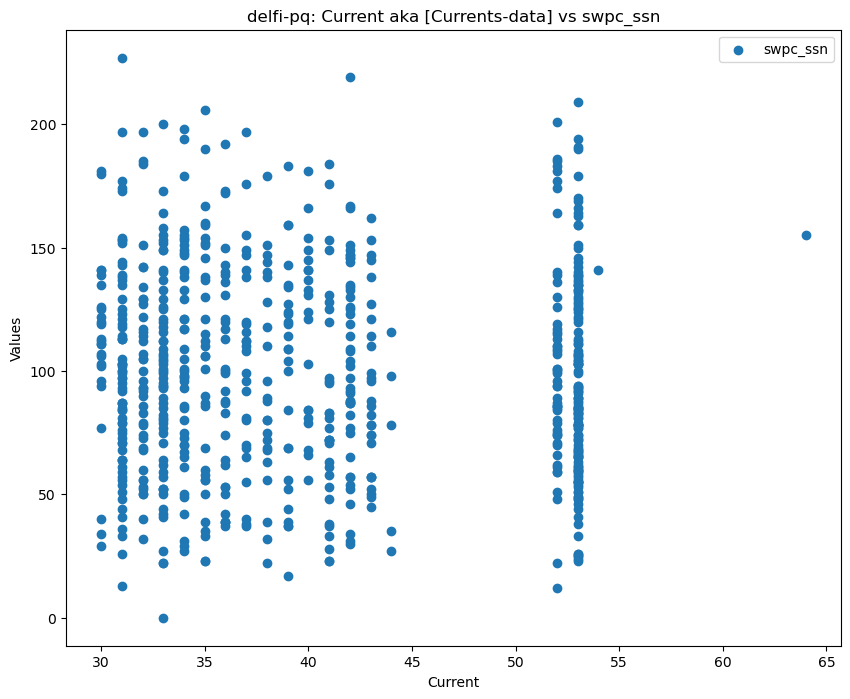

+-------+-----------------------------------------+------------+
|       |   observer where 0 is VK4JBE-UHF-QG62mm |   swpc_ssn |
|-------+-----------------------------------------+------------|
| count |                                       1 |          1 |
| mean  |                                       0 |        149 |
| std   |                                     nan |        nan |
| min   |                                       0 |        149 |
| 25%   |                                       0 |        149 |
| 50%   |                                       0 |        149 |
| 75%   |                                       0 |        149 |
| max   |                                       0 |        149 |
+-------+-----------------------------------------+------------+
Correlation [observer where 0 is VK4JBE-UHF-QG62mm] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendall_tau=[nan]


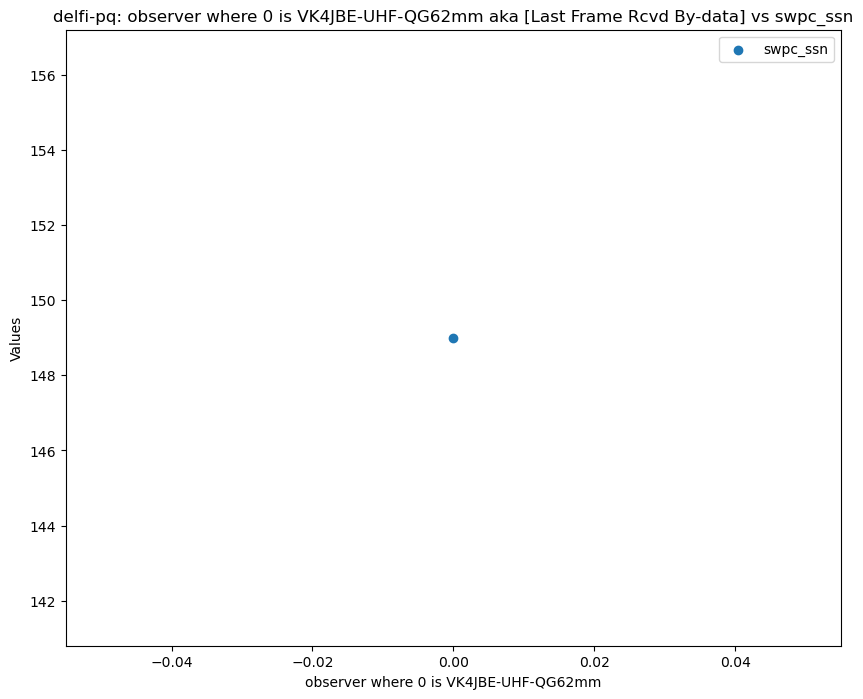

+-------+-----------+------------+
|       |   Cell Xm |   swpc_ssn |
|-------+-----------+------------|
| count | 689       |   689      |
| mean  |   5.83454 |   100.161  |
| std   |   8.85437 |    41.5395 |
| min   |   0       |     0      |
| 25%   |   0       |    69      |
| 50%   |   4       |    98      |
| 75%   |   6       |   130      |
| max   |  96       |   227      |
+-------+-----------+------------+
Correlation [Cell Xm] vs [swpc_ssn]: pearson=[0.09008220346801377], spearman=[0.052047479334271826], kendall_tau=[0.03794476984513911]


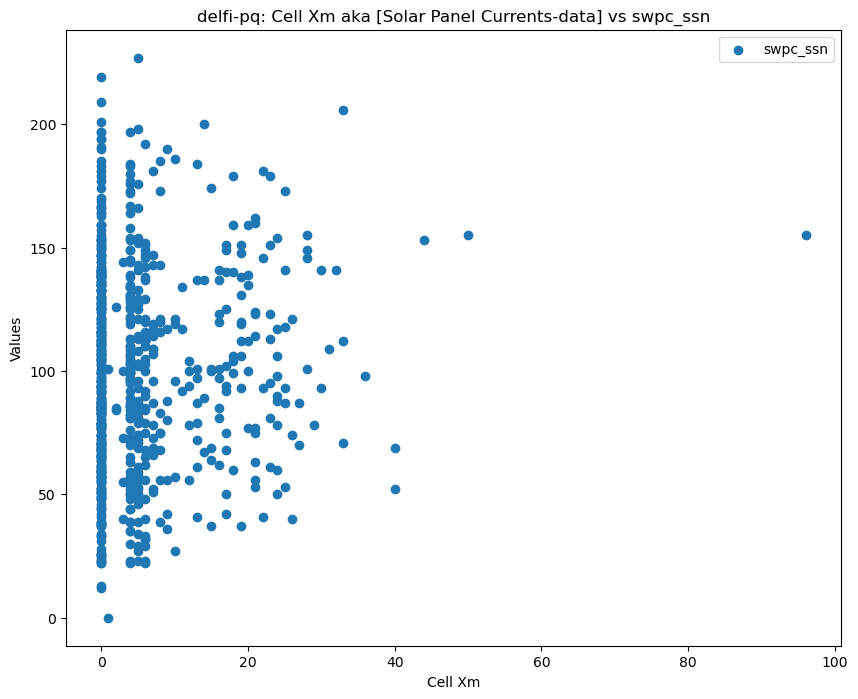

+-------+-----------------+------------+
|       |   Cell Xp V (m) |   swpc_ssn |
|-------+-----------------+------------|
| count |         689     |   689      |
| mean  |         125.039 |   100.161  |
| std   |         189.481 |    41.5395 |
| min   |           0     |     0      |
| 25%   |           2.663 |    69      |
| 50%   |           2.837 |    98      |
| 75%   |         288     |   130      |
| max   |         703     |   227      |
+-------+-----------------+------------+
Correlation [Cell Xp V (m)] vs [swpc_ssn]: pearson=[-0.03633990530352432], spearman=[0.016694089927088453], kendall_tau=[0.01117614978022468]


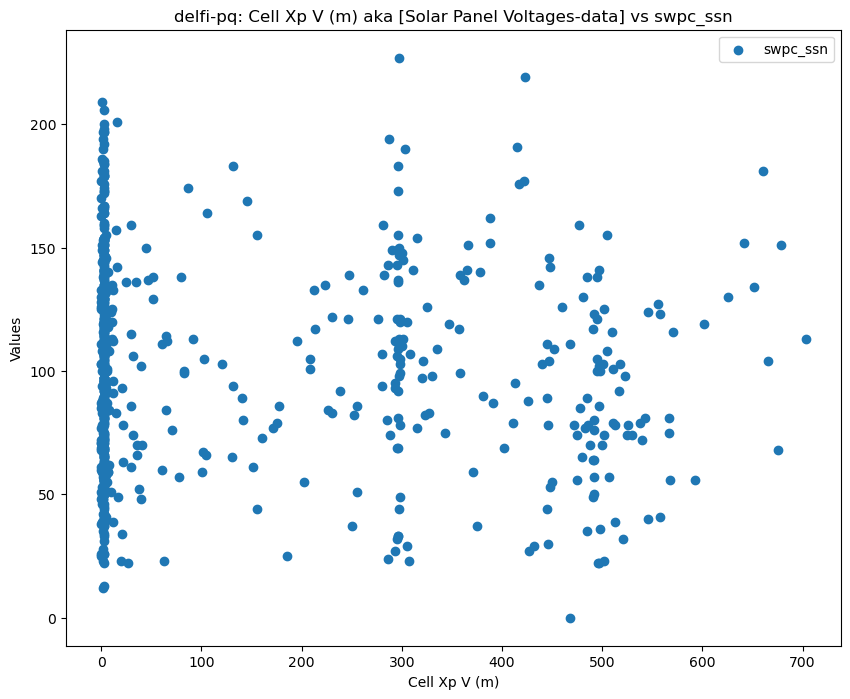

In [549]:
analyze_satellite('delfi-pq')

+-------+------------+------------+
|       |   Altitute |   swpc_ssn |
|-------+------------+------------|
| count |        813 |   813      |
| mean  |          0 |    85.7737 |
| std   |          0 |    46.1452 |
| min   |          0 |     0      |
| 25%   |          0 |    50      |
| 50%   |          0 |    83      |
| 75%   |          0 |   118      |
| max   |          0 |   227      |
+-------+------------+------------+
Correlation [Altitute] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendall_tau=[nan]


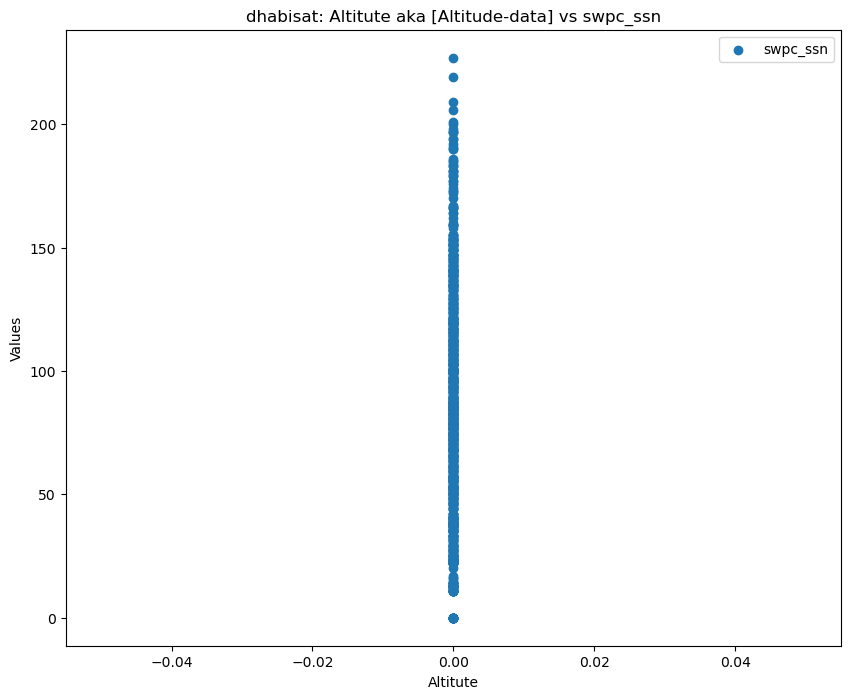

+-------+-------------------+------------+
|       |   ECEF Position X |   swpc_ssn |
|-------+-------------------+------------|
| count |               813 |   813      |
| mean  |                 0 |    85.7737 |
| std   |                 0 |    46.1452 |
| min   |                 0 |     0      |
| 25%   |                 0 |    50      |
| 50%   |                 0 |    83      |
| 75%   |                 0 |   118      |
| max   |                 0 |   227      |
+-------+-------------------+------------+
Correlation [ECEF Position X] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendall_tau=[nan]


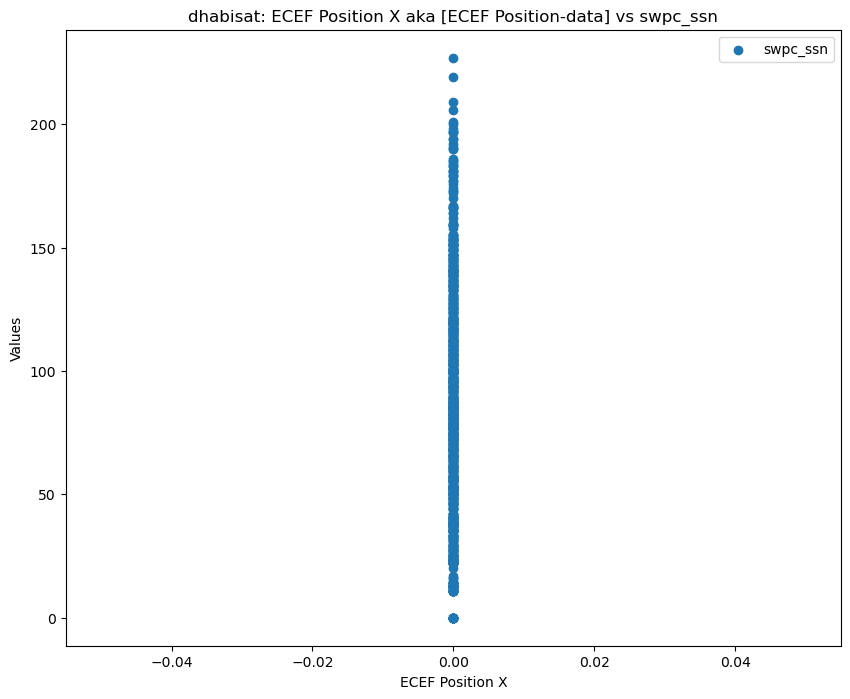

+-------+----------------------------+------------+
|       |   Estimated X Angular Rate |   swpc_ssn |
|-------+----------------------------+------------|
| count |              813           |   813      |
| mean  |                0.000418204 |    85.7737 |
| std   |                0.00848483  |    46.1452 |
| min   |                0           |     0      |
| 25%   |                0           |    50      |
| 50%   |                0           |    83      |
| 75%   |                0           |   118      |
| max   |                0.19        |   227      |
+-------+----------------------------+------------+
Correlation [Estimated X Angular Rate] vs [swpc_ssn]: pearson=[-0.039515661439522766], spearman=[-0.04143452771262478], kendall_tau=[-0.03398200601136489]


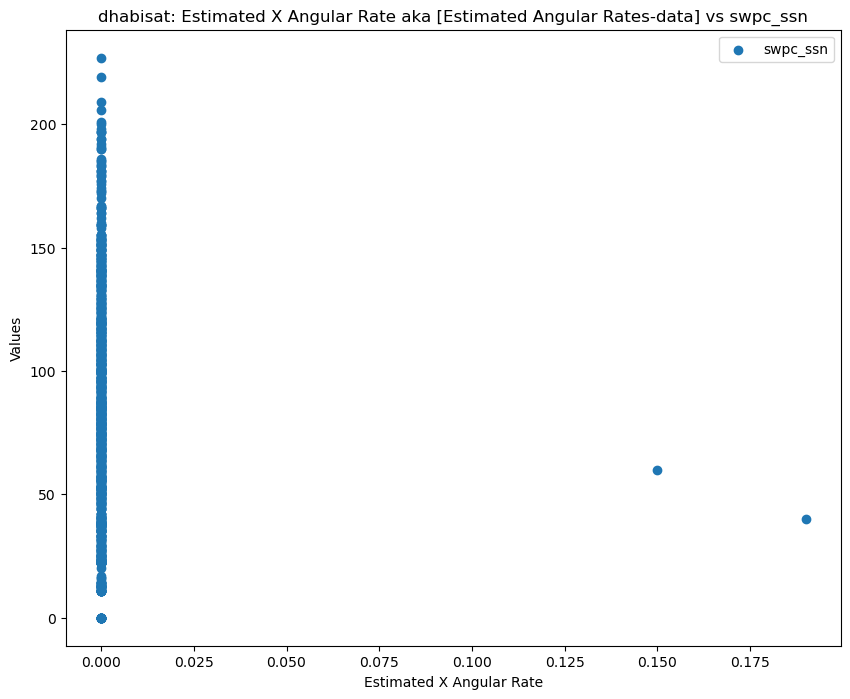

In [550]:
analyze_satellite('dhabisat')

+-------+-------------------------+------------+
|       |   Batteries Voltage.1 V |   swpc_ssn |
|-------+-------------------------+------------|
| count |               448       |   448      |
| mean  |                 5.4981  |   115.52   |
| std   |                 3.49636 |    40.1737 |
| min   |                 0.03    |    12      |
| 25%   |                 0.033   |    87      |
| 50%   |                 7.3855  |   114      |
| 75%   |                 8.059   |   142      |
| max   |                 8.3595  |   227      |
+-------+-------------------------+------------+
Correlation [Batteries Voltage.1 V] vs [swpc_ssn]: pearson=[0.036143361932609225], spearman=[0.030006195647520932], kendall_tau=[0.020395238659781757]


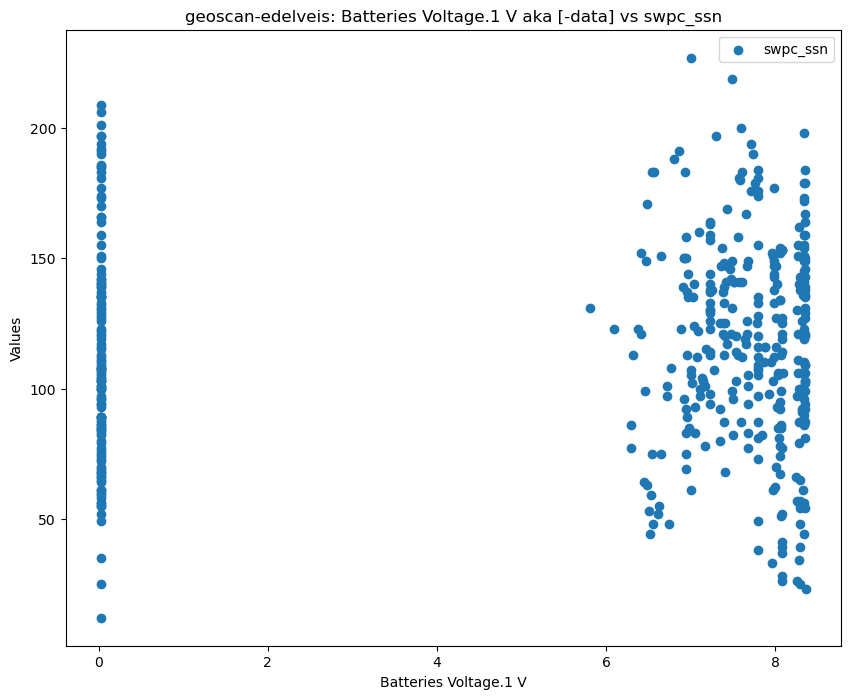

+-------+---------------------+------------+
|       |   Battery Voltage V |   swpc_ssn |
|-------+---------------------+------------|
| count |          128        |   128      |
| mean  |            8.20781  |   112.844  |
| std   |            0.155533 |    43.0099 |
| min   |            7.8      |    12      |
| 25%   |            8.1      |    82.75   |
| 50%   |            8.3      |   107      |
| 75%   |            8.3      |   139.25   |
| max   |            8.3      |   209      |
+-------+---------------------+------------+
Correlation [Battery Voltage V] vs [swpc_ssn]: pearson=[0.07410456193200565], spearman=[0.013035490718406977], kendall_tau=[0.011758153411808678]


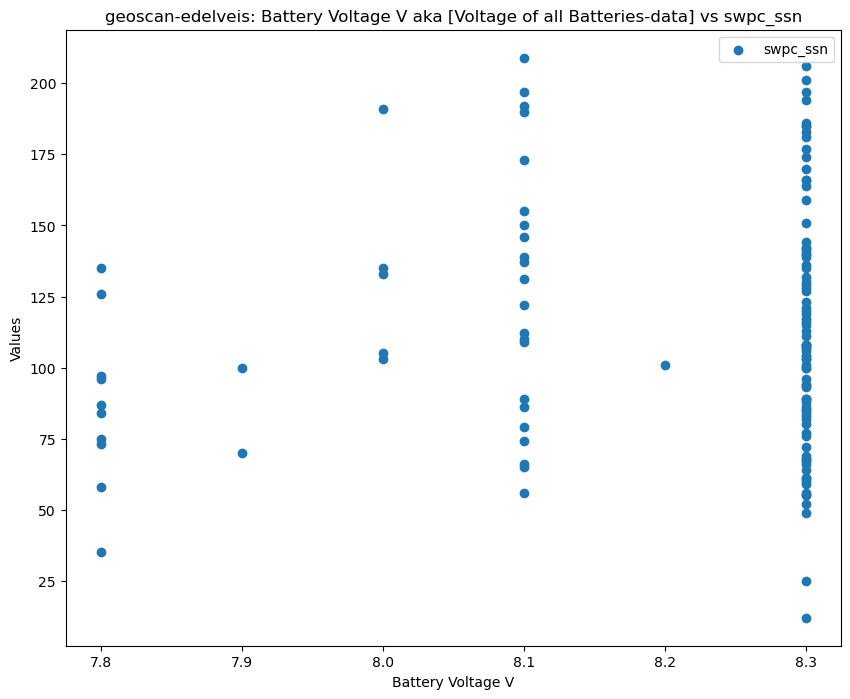

In [551]:
analyze_satellite('geoscan-edelveis')

+-------+------------------+------------+
|       |   47959.temp_cpu |   swpc_ssn |
|-------+------------------+------------|
| count |        879       |   879      |
| mean  |         16.6726  |    79.2673 |
| std   |          4.08236 |    46.0523 |
| min   |          2.9     |     0      |
| 25%   |         15       |    40      |
| 50%   |         17       |    77      |
| 75%   |         18       |   112      |
| max   |         42       |   209      |
+-------+------------------+------------+
Correlation [47959.temp_cpu] vs [swpc_ssn]: pearson=[0.19583528814101045], spearman=[0.11874665779294377], kendall_tau=[0.08426372624567413]


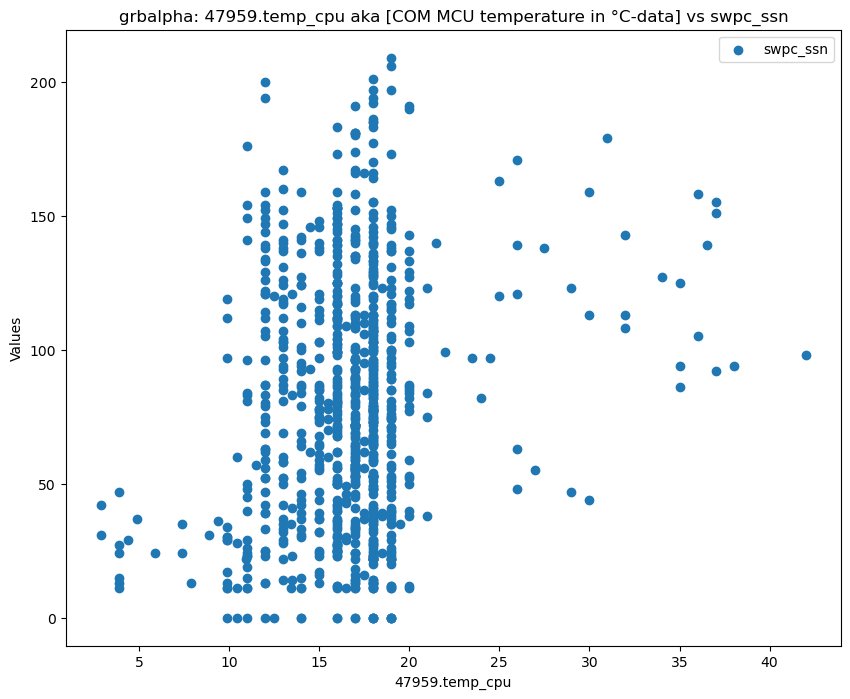

+-------+-----------------------------+------------+
|       |   47959.rf_packets_received |   swpc_ssn |
|-------+-----------------------------+------------|
| count |                       879   |   879      |
| mean  |                     23988.6 |    79.2673 |
| std   |                     14579.6 |    46.0523 |
| min   |                      3885   |     0      |
| 25%   |                      6566.5 |    40      |
| 50%   |                     26861   |    77      |
| 75%   |                     37127.5 |   112      |
| max   |                     46873   |   209      |
+-------+-----------------------------+------------+
Correlation [47959.rf_packets_received] vs [swpc_ssn]: pearson=[0.6552103398456955], spearman=[0.6812939707841996], kendall_tau=[0.48280913113968726]


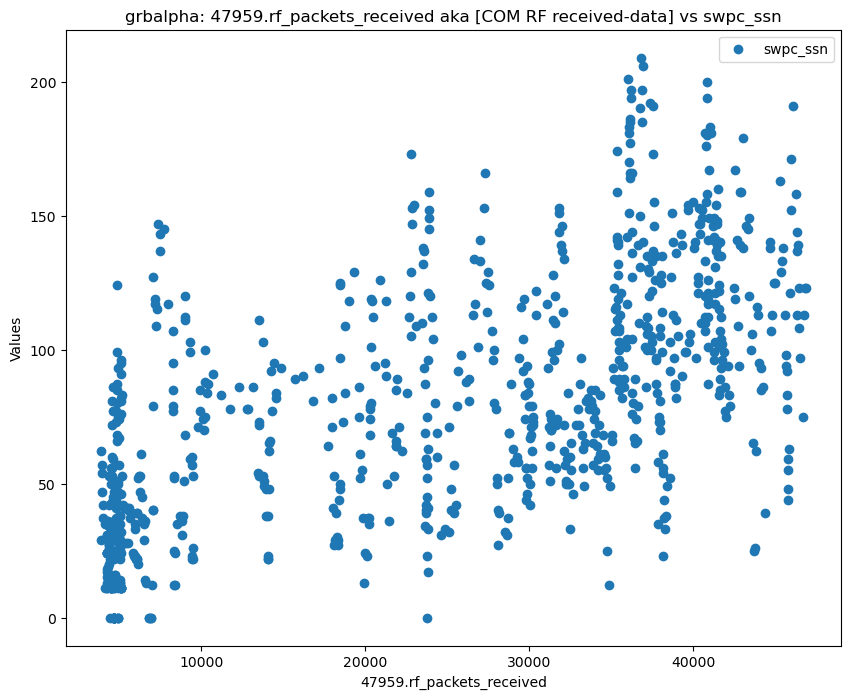

+-------+--------------------------------+------------+
|       |   47959.rf_packets_transmitted |   swpc_ssn |
|-------+--------------------------------+------------|
| count |                  879           |   879      |
| mean  |                    1.95549e+06 |    79.2673 |
| std   |                    1.16048e+06 |    46.0523 |
| min   |               148470           |     0      |
| 25%   |                    1.03562e+06 |    40      |
| 50%   |                    1.63671e+06 |    77      |
| 75%   |                    2.7571e+06  |   112      |
| max   |                    4.8328e+06  |   209      |
+-------+--------------------------------+------------+
Correlation [47959.rf_packets_transmitted] vs [swpc_ssn]: pearson=[0.6278741335227254], spearman=[0.6812807774305079], kendall_tau=[0.4826457920364598]


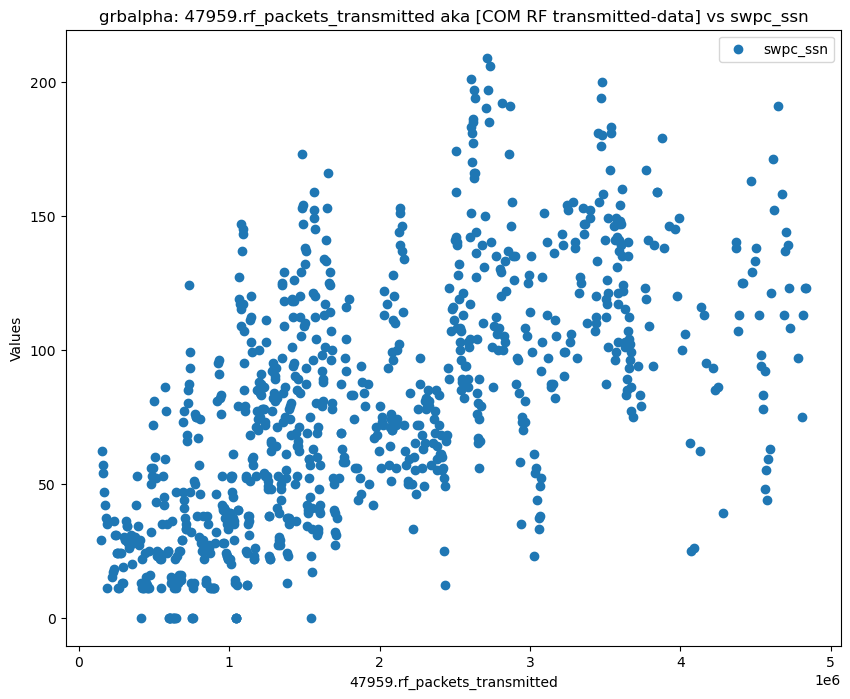

+-------+----------------------+------------+
|       |   47959.obc_mpu_temp |   swpc_ssn |
|-------+----------------------+------------|
| count |           1012       |  1012      |
| mean  |             10.8191  |    84.3458 |
| std   |              9.54471 |    47.5542 |
| min   |              0       |     0      |
| 25%   |              0       |    46      |
| 50%   |             15       |    82      |
| 75%   |             20       |   119.25   |
| max   |             28       |   227      |
+-------+----------------------+------------+
Correlation [47959.obc_mpu_temp] vs [swpc_ssn]: pearson=[0.013497454471777425], spearman=[0.0407576844159037], kendall_tau=[0.028140507841988457]


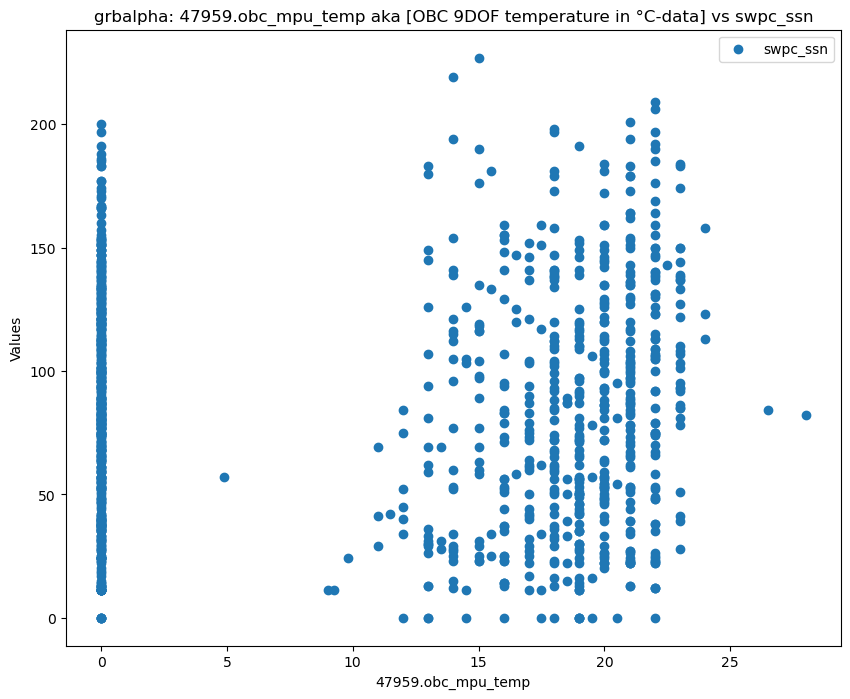

+-------+------------------+------------+
|       |   47959.obc_temp |   swpc_ssn |
|-------+------------------+------------|
| count |       1012       |  1012      |
| mean  |         16.5183  |    84.3458 |
| std   |          2.87335 |    47.5542 |
| min   |          7.7     |     0      |
| 25%   |         15       |    46      |
| 50%   |         17       |    82      |
| 75%   |         19       |   119.25   |
| max   |         25       |   227      |
+-------+------------------+------------+
Correlation [47959.obc_temp] vs [swpc_ssn]: pearson=[0.13629544895903378], spearman=[0.13094092761767348], kendall_tau=[0.09183994173997309]


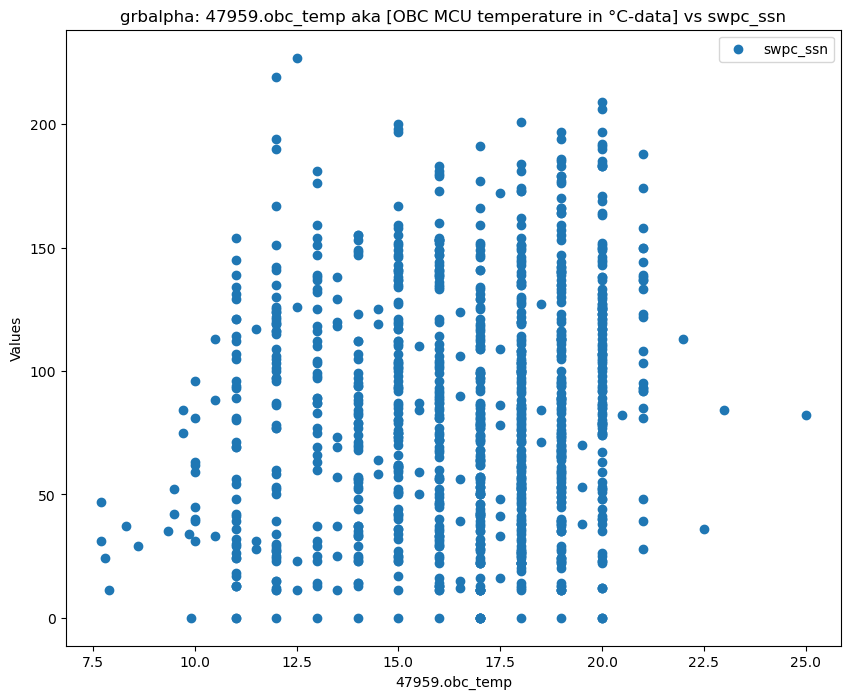

+-------+--------------------------+------------+
|       |   47959.obc_uptime_total |   swpc_ssn |
|-------+--------------------------+------------|
| count |           1012           |  1012      |
| mean  |              4.61661e+07 |    84.3458 |
| std   |              2.52258e+07 |    47.5542 |
| min   |              2.40802e+06 |     0      |
| 25%   |              2.43341e+07 |    46      |
| 50%   |              4.61619e+07 |    82      |
| 75%   |              6.79935e+07 |   119.25   |
| max   |              8.98209e+07 |   227      |
+-------+--------------------------+------------+
Correlation [47959.obc_uptime_total] vs [swpc_ssn]: pearson=[0.6417320382218976], spearman=[0.6564475957291203], kendall_tau=[0.4656836466869805]


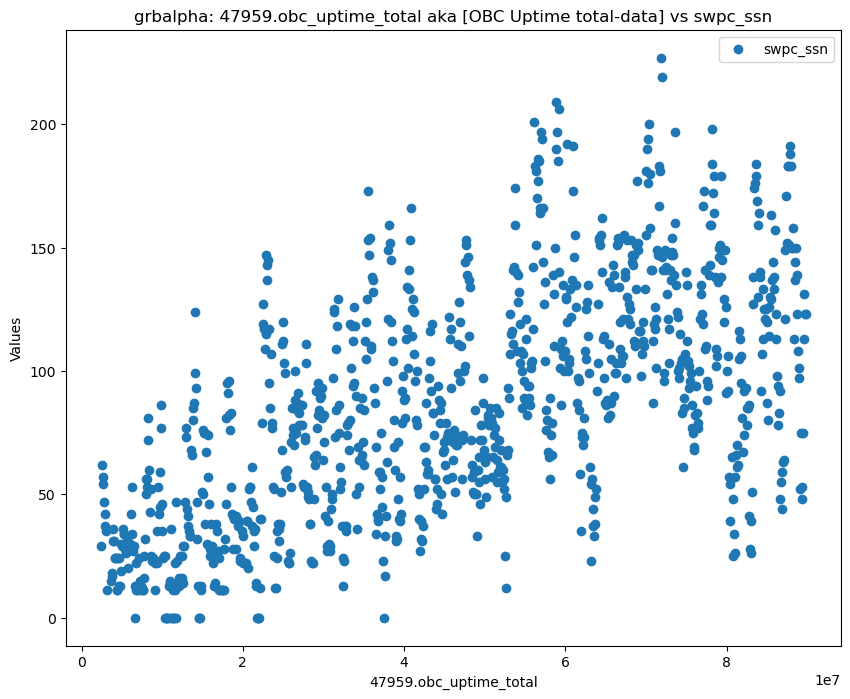

In [552]:
analyze_satellite('grbalpha')

+-------+---------------+------------+
|       |   MPPT X (°C) |   swpc_ssn |
|-------+---------------+------------|
| count |     403       |   403      |
| mean  |       2.15385 |    75.2035 |
| std   |       2.38176 |    41.9554 |
| min   |       0       |     0      |
| 25%   |       0       |    39      |
| 50%   |       2       |    75      |
| 75%   |       3       |   103      |
| max   |      15       |   184      |
+-------+---------------+------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendall_tau=[0.1765768272482411]


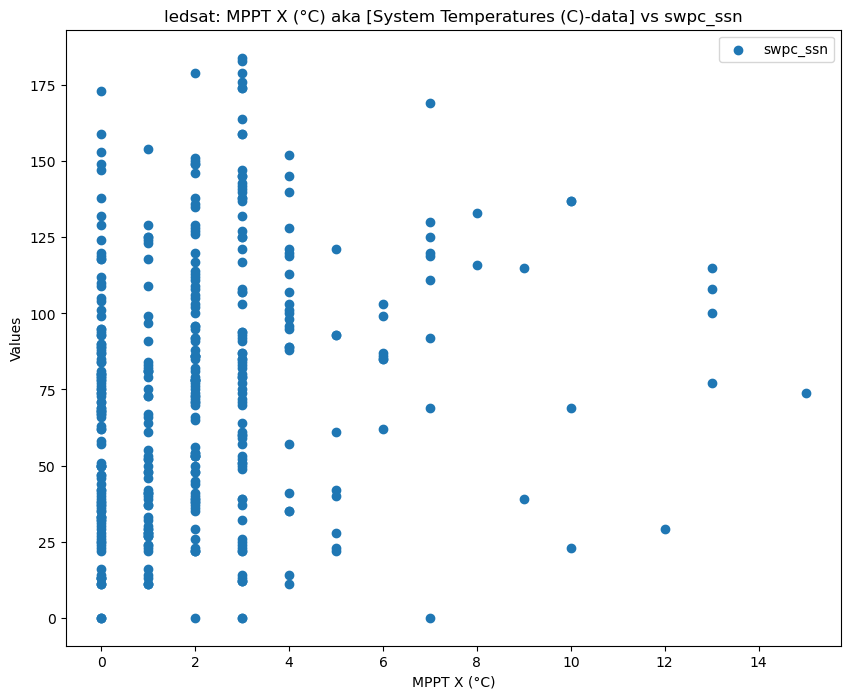

+-------+---------------+------------+
|       |   MPPT X (°C) |   swpc_ssn |
|-------+---------------+------------|
| count |     403       |   403      |
| mean  |       2.15385 |    75.2035 |
| std   |       2.38176 |    41.9554 |
| min   |       0       |     0      |
| 25%   |       0       |    39      |
| 50%   |       2       |    75      |
| 75%   |       3       |   103      |
| max   |      15       |   184      |
+-------+---------------+------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendall_tau=[0.1765768272482411]


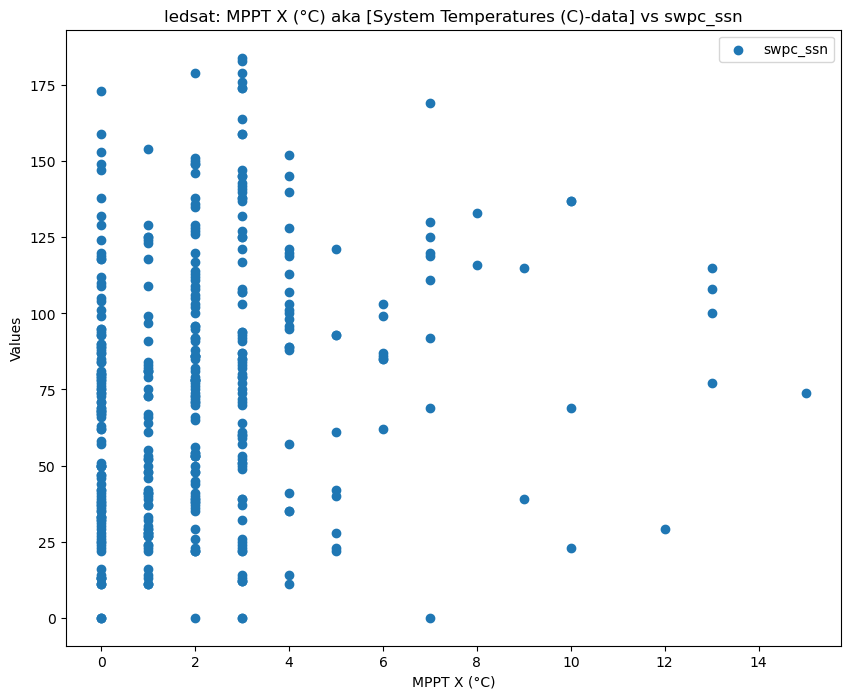

+-------+---------------+------------+
|       |   X axis MPPT |   swpc_ssn |
|-------+---------------+------------|
| count |     403       |   403      |
| mean  |       2.15385 |    75.2035 |
| std   |       2.38176 |    41.9554 |
| min   |       0       |     0      |
| 25%   |       0       |    39      |
| 50%   |       2       |    75      |
| 75%   |       3       |   103      |
| max   |      15       |   184      |
+-------+---------------+------------+
Correlation [X axis MPPT] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendall_tau=[0.1765768272482411]


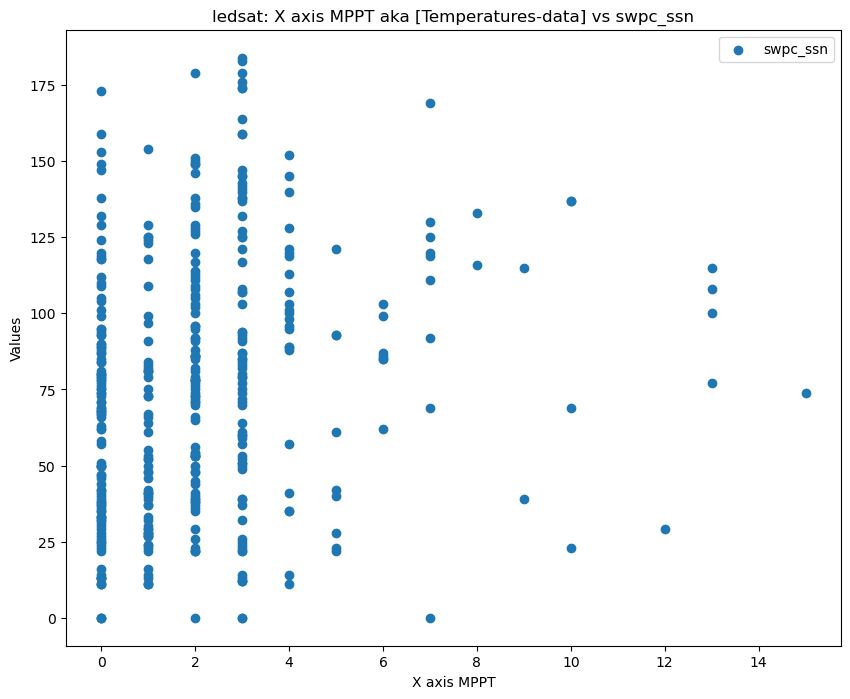

+-------+---------------------+------------+
|       |   Battery Voltage V |   swpc_ssn |
|-------+---------------------+------------|
| count |         403         |   403      |
| mean  |           8.29777   |    75.2035 |
| std   |           0.0216249 |    41.9554 |
| min   |           8.2       |     0      |
| 25%   |           8.3       |    39      |
| 50%   |           8.3       |    75      |
| 75%   |           8.3       |   103      |
| max   |           8.4       |   184      |
+-------+---------------------+------------+
Correlation [Battery Voltage V] vs [swpc_ssn]: pearson=[-0.11547506375709894], spearman=[-0.11701318595193114], kendall_tau=[-0.09515639123885228]


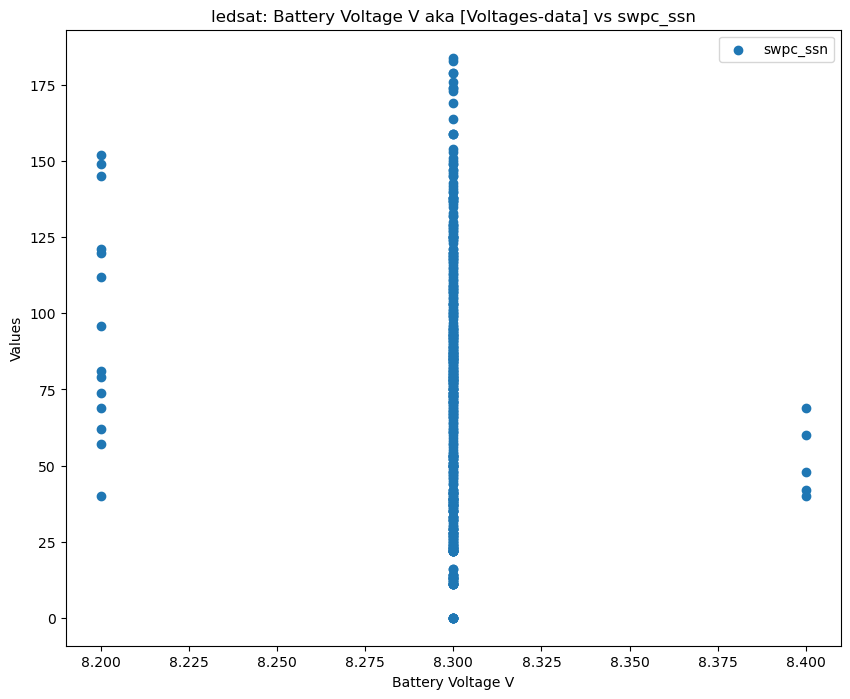

+-------+------------------------------------------+------------+
|       |   Total current coming from solar panels |   swpc_ssn |
|-------+------------------------------------------+------------|
| count |                                 403      |   403      |
| mean  |                                  22.2258 |    75.2035 |
| std   |                                  64.7521 |    41.9554 |
| min   |                                   0      |     0      |
| 25%   |                                   0      |    39      |
| 50%   |                                   0      |    75      |
| 75%   |                                   5      |   103      |
| max   |                                 426      |   184      |
+-------+------------------------------------------+------------+
Correlation [Total current coming from solar panels] vs [swpc_ssn]: pearson=[-0.019856481553725828], spearman=[-0.34641262261892436], kendall_tau=[-0.27074873909025304]


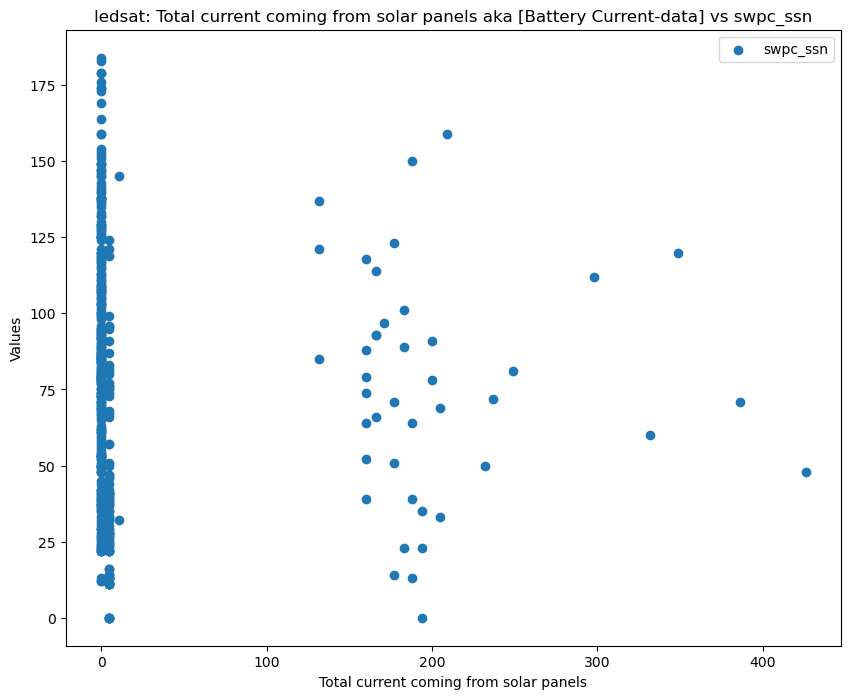

+-------+------------------------------------------+------------+
|       |   Total current coming from solar panels |   swpc_ssn |
|-------+------------------------------------------+------------|
| count |                                 403      |   403      |
| mean  |                                  22.2258 |    75.2035 |
| std   |                                  64.7521 |    41.9554 |
| min   |                                   0      |     0      |
| 25%   |                                   0      |    39      |
| 50%   |                                   0      |    75      |
| 75%   |                                   5      |   103      |
| max   |                                 426      |   184      |
+-------+------------------------------------------+------------+
Correlation [Total current coming from solar panels] vs [swpc_ssn]: pearson=[-0.019856481553725828], spearman=[-0.34641262261892436], kendall_tau=[-0.27074873909025304]


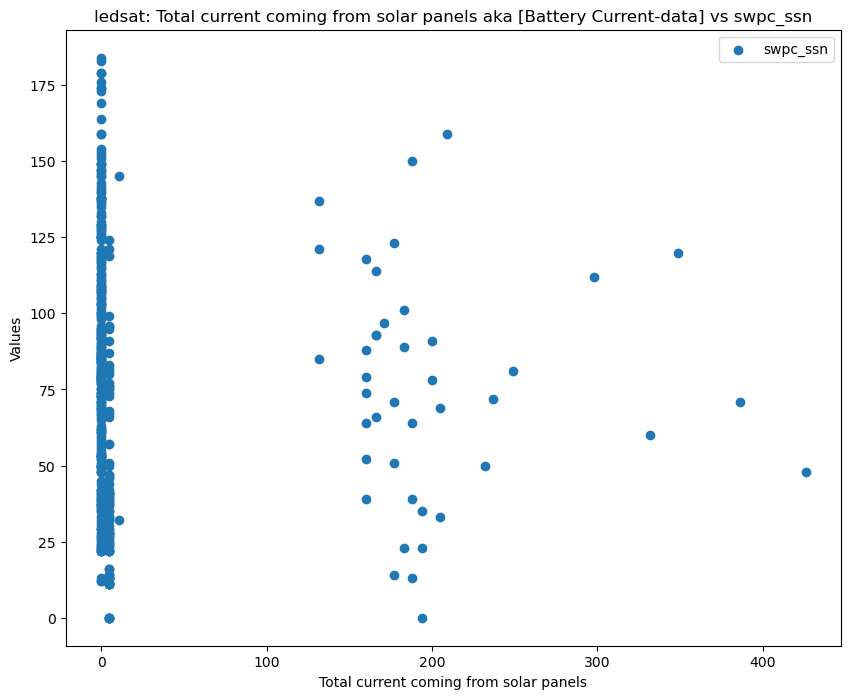

+-------+----------------+------------+
|       |   49069.mode V |   swpc_ssn |
|-------+----------------+------------|
| count |     74         |    74      |
| mean  |      8.30905   |    80.0405 |
| std   |      0.0265438 |    44.4758 |
| min   |      8.16      |     0      |
| 25%   |      8.3       |    44.25   |
| 50%   |      8.31      |    84      |
| 75%   |      8.33      |   113      |
| max   |      8.34      |   179      |
+-------+----------------+------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendall_tau=[0.1292288541557749]


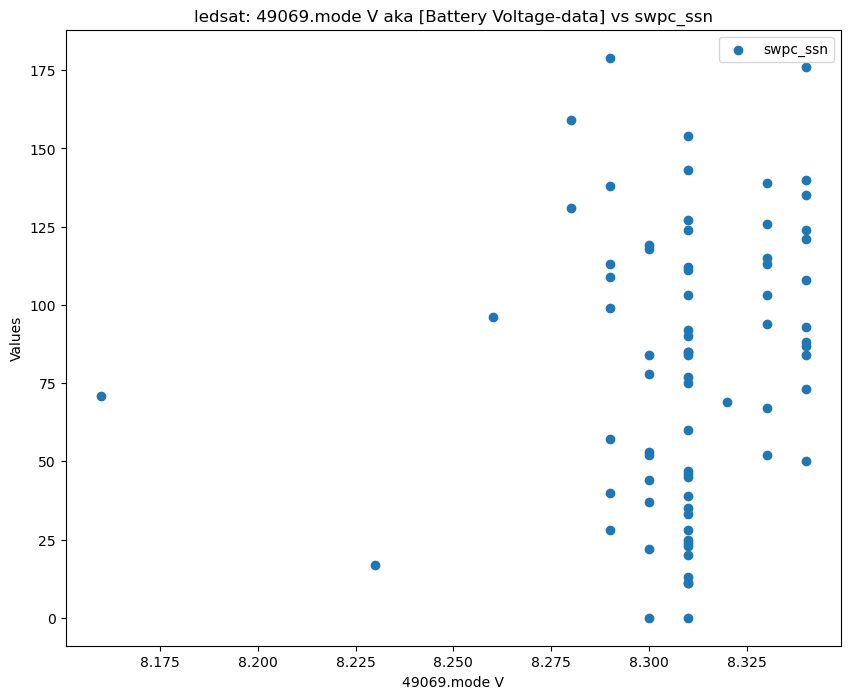

+-------+----------------+------------+
|       |   49069.mode V |   swpc_ssn |
|-------+----------------+------------|
| count |     74         |    74      |
| mean  |      8.30905   |    80.0405 |
| std   |      0.0265438 |    44.4758 |
| min   |      8.16      |     0      |
| 25%   |      8.3       |    44.25   |
| 50%   |      8.31      |    84      |
| 75%   |      8.33      |   113      |
| max   |      8.34      |   179      |
+-------+----------------+------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendall_tau=[0.1292288541557749]


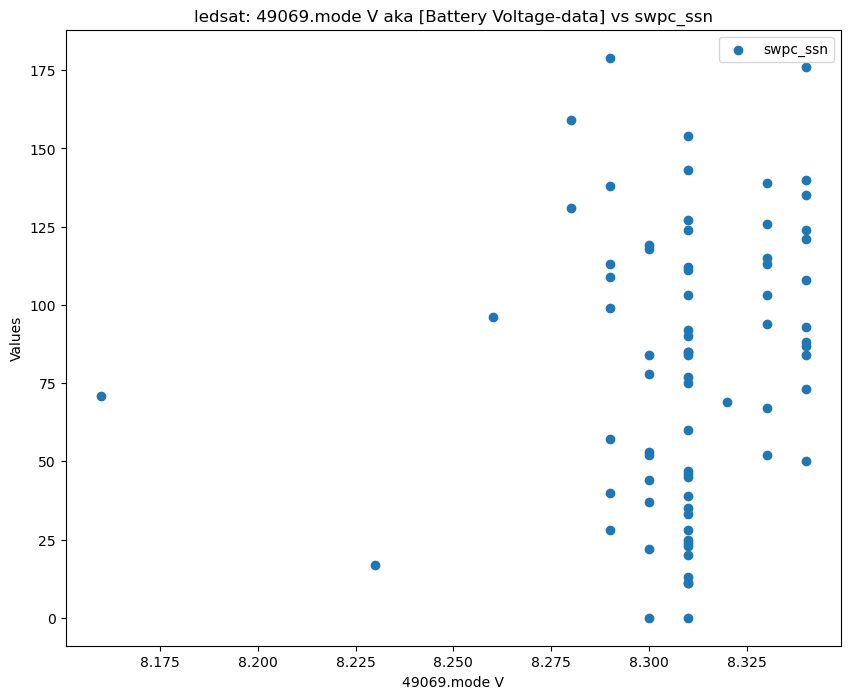

+-------+----------------------+------------+
|       |   -----OE6EUR15----- |   swpc_ssn |
|-------+----------------------+------------|
| count |          1449        |  1449      |
| mean  |             0.690131 |    62.7481 |
| std   |             0.951108 |    52.0369 |
| min   |             0        |     0      |
| 25%   |             0        |    14      |
| 50%   |             0        |    52      |
| 75%   |             2        |   101      |
| max   |             2        |   227      |
+-------+----------------------+------------+
Correlation [-----OE6EUR15-----] vs [swpc_ssn]: pearson=[0.6901219008281757], spearman=[0.6770402694666079], kendall_tau=[0.559014424635535]


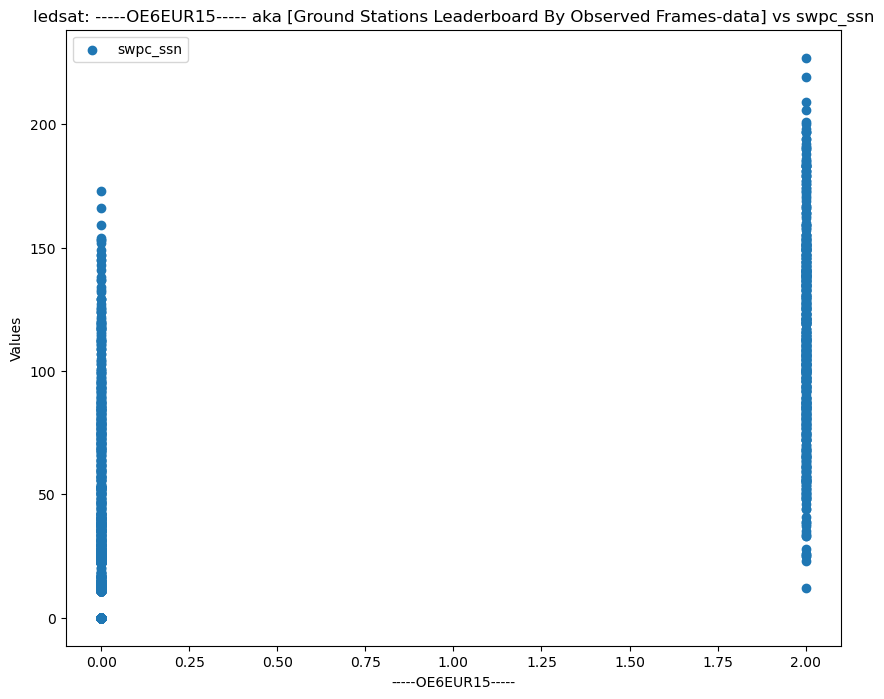

In [553]:
analyze_satellite('ledsat')

+-------+----------------------------------+------------+
|       |   Elevation (onboard prediction) |   swpc_ssn |
|-------+----------------------------------+------------|
| count |                          484     |   484      |
| mean  |                          326.969 |    62.1322 |
| std   |                          125.551 |    38.5939 |
| min   |                            0     |     0      |
| 25%   |                          330     |    31      |
| 50%   |                          377     |    56.5    |
| 75%   |                          400     |    87      |
| max   |                          417     |   173      |
+-------+----------------------------------+------------+
Correlation [Elevation (onboard prediction)] vs [swpc_ssn]: pearson=[0.02981696417037133], spearman=[-0.32198191160940903], kendall_tau=[-0.2297984743196735]


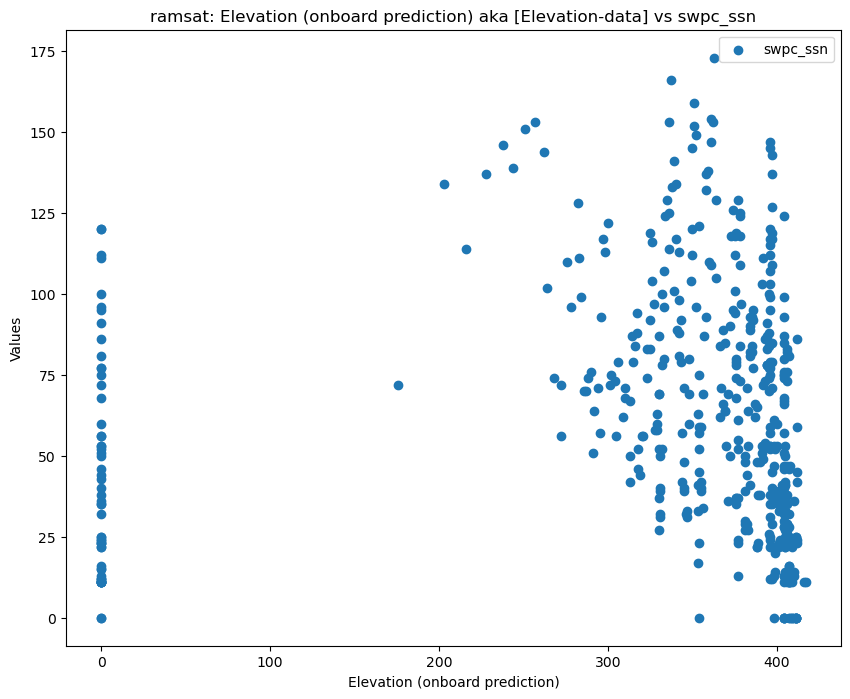

In [554]:
analyze_satellite('ramsat')

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |       188    |   188      |
| mean  |     21452    |    68.9043 |
| std   |      3259.85 |    50.199  |
| min   |      5129    |     0      |
| 25%   |     20756.8  |    24      |
| 50%   |     22126    |    60.5    |
| 75%   |     23118    |   112      |
| max   |     24600    |   179      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5748628313476977], spearman=[0.7857285673694304], kendall_tau=[0.5786804345788774]


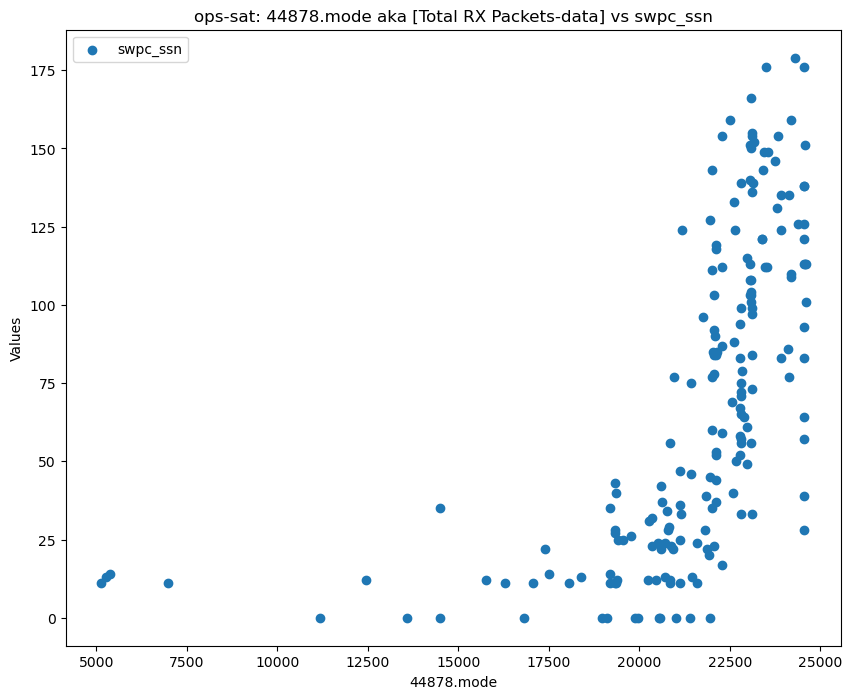

+-------+---------------+------------+
|       |    44878.mode |   swpc_ssn |
|-------+---------------+------------|
| count | 188           |   188      |
| mean  |   2.89948e+09 |    68.9043 |
| std   |   5.94793e+08 |    50.199  |
| min   |   1.42965e+07 |     0      |
| 25%   |   2.91416e+09 |    24      |
| 50%   |   3.06149e+09 |    60.5    |
| 75%   |   3.20752e+09 |   112      |
| max   |   3.34178e+09 |   179      |
+-------+---------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5353106560668386], spearman=[0.7858898612127606], kendall_tau=[0.5767193747435023]


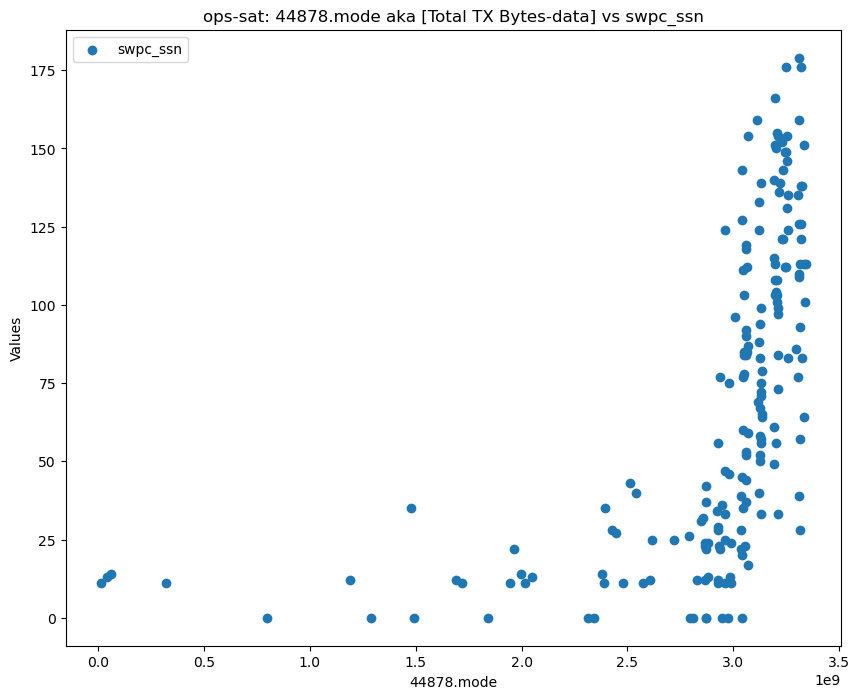

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |    188       |   188      |
| mean  |      2.46277 |    68.9043 |
| std   |      5.21861 |    50.199  |
| min   |      0       |     0      |
| 25%   |      0       |    24      |
| 50%   |      0       |    60.5    |
| 75%   |      2       |   112      |
| max   |     35       |   179      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.3204786726051506], spearman=[-0.4292673343841385], kendall_tau=[-0.33004813384919396]


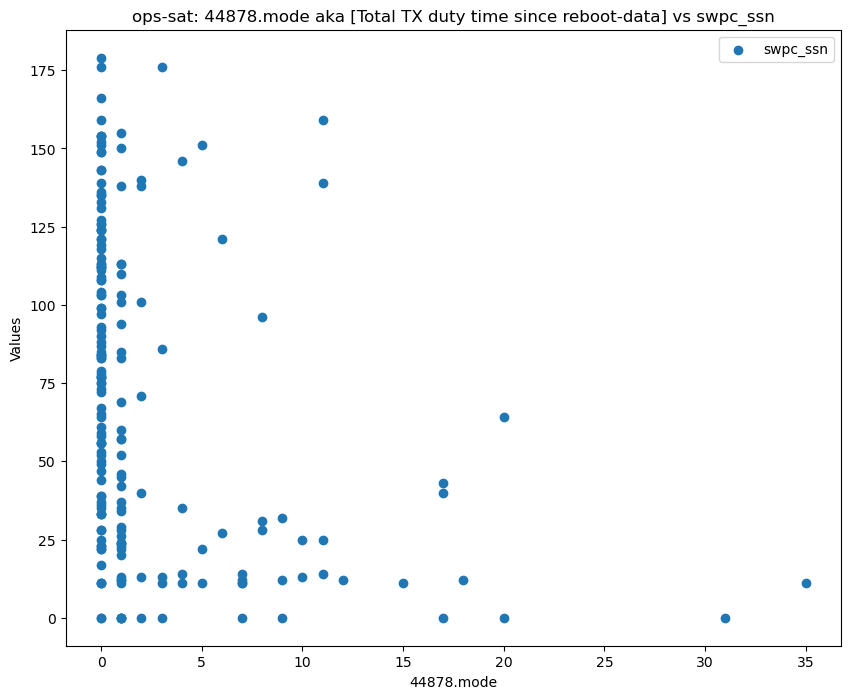

+-------+------------------+------------+
|       |       44878.mode |   swpc_ssn |
|-------+------------------+------------|
| count |    188           |   188      |
| mean  |      1.6614e+07  |    68.9043 |
| std   |      3.55207e+06 |    50.199  |
| min   | 176553           |     0      |
| 25%   |      1.66055e+07 |    24      |
| 50%   |      1.75827e+07 |    60.5    |
| 75%   |      1.85426e+07 |   112      |
| max   |      1.9407e+07  |   179      |
+-------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5561946696013134], spearman=[0.7858898612127606], kendall_tau=[0.5767193747435023]


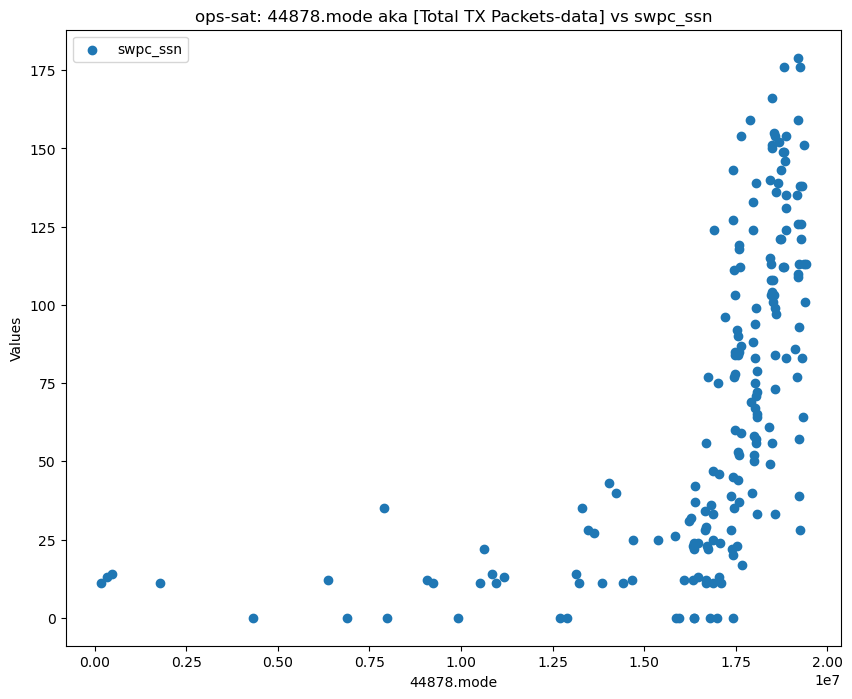

+-------+------------------+------------+
|       |       44878.mode |   swpc_ssn |
|-------+------------------+------------|
| count |    188           |   188      |
| mean  |      1.2581e+07  |    68.9043 |
| std   |      4.53865e+07 |    50.199  |
| min   |   3008           |     0      |
| 25%   |  79537.8         |    24      |
| 50%   | 546839           |    60.5    |
| 75%   |      3.14044e+06 |   112      |
| max   |      3.70719e+08 |   179      |
+-------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2918840914794443], spearman=[-0.27982887225292064], kendall_tau=[-0.18135307800557543]


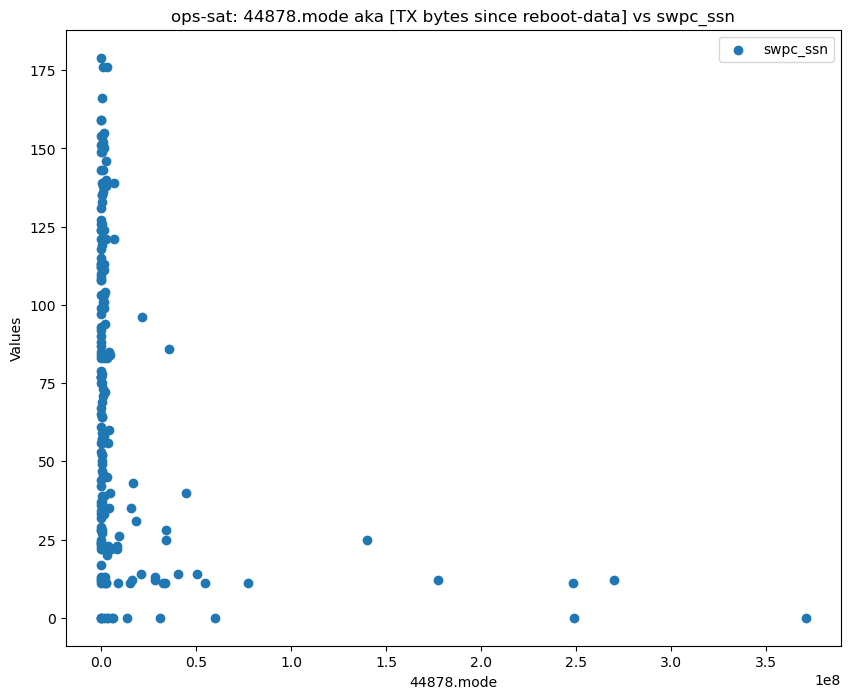

+-------+------------------+------------+
|       |       44878.mode |   swpc_ssn |
|-------+------------------+------------|
| count |   1289           |  1289      |
| mean  |  74049.3         |    67.5679 |
| std   | 222726           |    51.1105 |
| min   |      1           |     0      |
| 25%   |   1069           |    23      |
| 50%   |   5386           |    59      |
| 75%   |  22765           |   106      |
| max   |      1.71596e+06 |   227      |
+-------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.32635194664806416], spearman=[-0.2839994754465362], kendall_tau=[-0.18962512401888412]


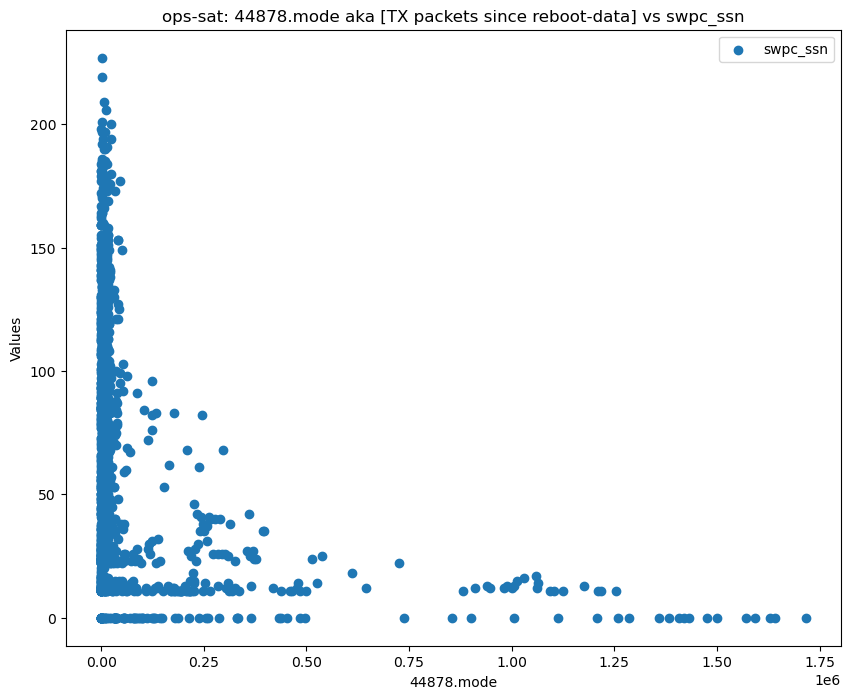

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |   188        |   188      |
| mean  |     1.82447  |    68.9043 |
| std   |     0.381437 |    50.199  |
| min   |     1        |     0      |
| 25%   |     2        |    24      |
| 50%   |     2        |    60.5    |
| 75%   |     2        |   112      |
| max   |     2        |   179      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.15328036522496197], spearman=[0.1725486775668712], kendall_tau=[0.14217416584584225]


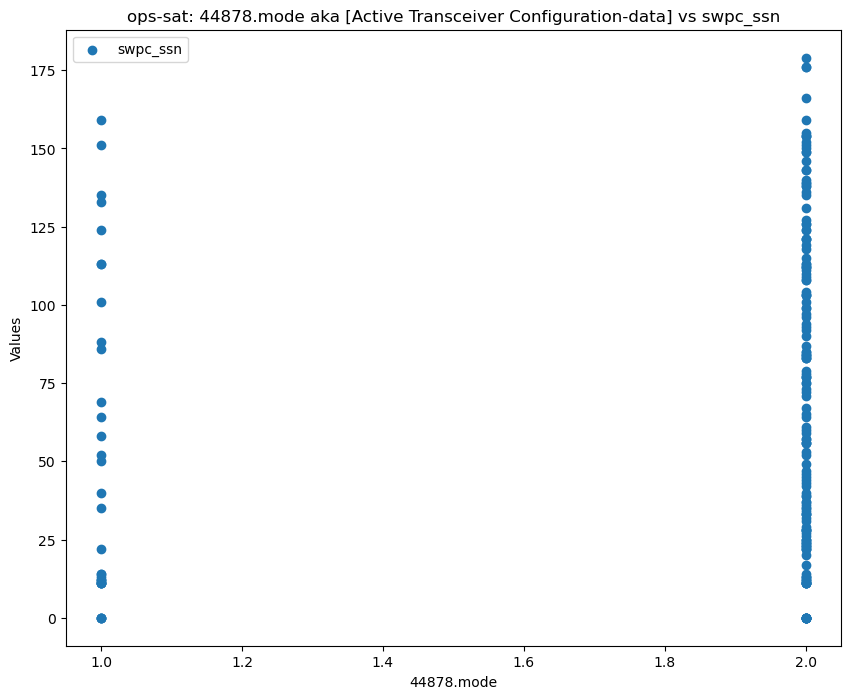

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |    1289      |  1289      |
| mean  |      59.9108 |    67.5679 |
| std   |    1063.59   |    51.1105 |
| min   |  -10471      |     0      |
| 25%   |       0      |    23      |
| 50%   |     212      |    59      |
| 75%   |     446      |   106      |
| max   |    4810      |   227      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.1787243752541007], spearman=[-0.3397847873246419], kendall_tau=[-0.2429687701330934]


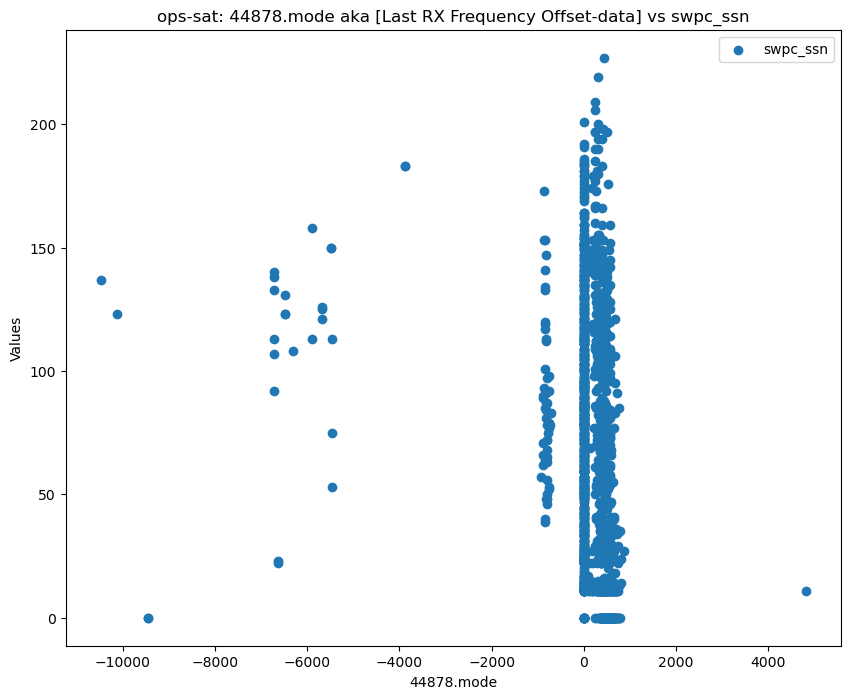

+-------+---------------------+------------+
|       |   Last RX timestamp |   swpc_ssn |
|-------+---------------------+------------|
| count |       188           |   188      |
| mean  |         1.50759e+09 |    68.9043 |
| std   |         9.2103e+08  |    50.199  |
| min   |         9.47637e+08 |     0      |
| 25%   |         9.55291e+08 |    24      |
| 50%   |         1.03348e+09 |    60.5    |
| 75%   |         1.0365e+09  |   112      |
| max   |         3.12114e+09 |   179      |
+-------+---------------------+------------+
Correlation [Last RX timestamp] vs [swpc_ssn]: pearson=[-0.18111889169521622], spearman=[-0.020300742229652155], kendall_tau=[-0.01649104207369058]


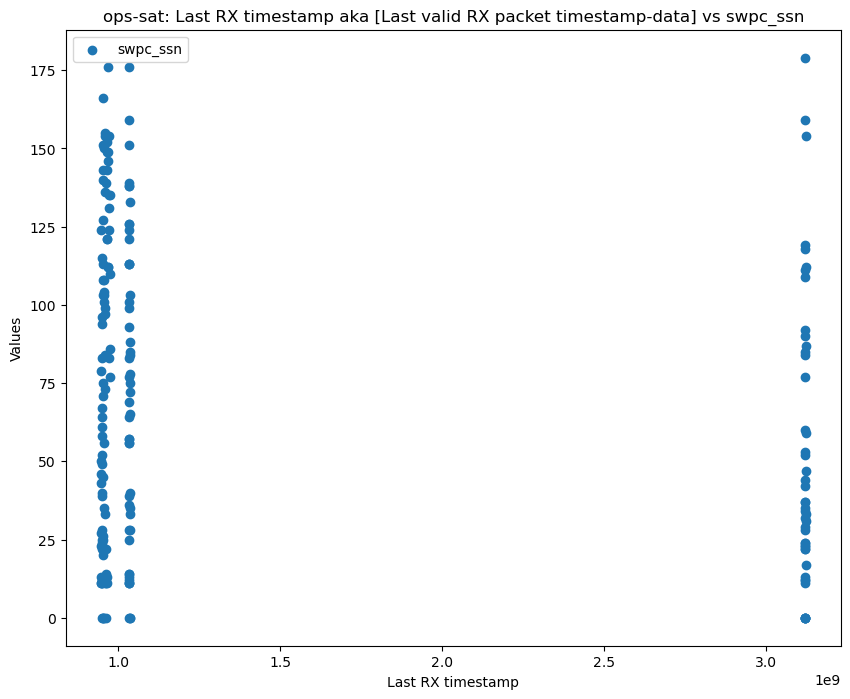

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |     1289     |  1289      |
| mean  |     1039.94  |    67.5679 |
| std   |      262.858 |    51.1105 |
| min   |      534     |     0      |
| 25%   |      925     |    23      |
| 50%   |     1161     |    59      |
| 75%   |     1222     |   106      |
| max   |     1305     |   227      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.6808436708746547], spearman=[0.803383853194286], kendall_tau=[0.6007578538393359]


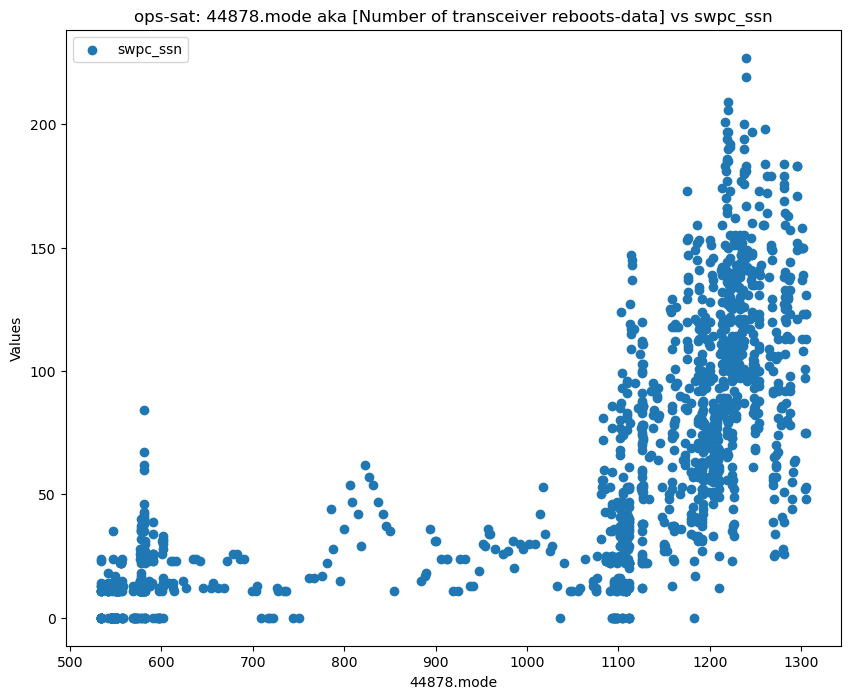

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |     1289     |  1289      |
| mean  |      169.351 |    67.5679 |
| std   |      120.825 |    51.1105 |
| min   |        1     |     0      |
| 25%   |        1     |    23      |
| 50%   |      256     |    59      |
| 75%   |      256     |   106      |
| max   |      256     |   227      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.12213818030282121], spearman=[0.12378038887956977], kendall_tau=[0.10183854610327941]


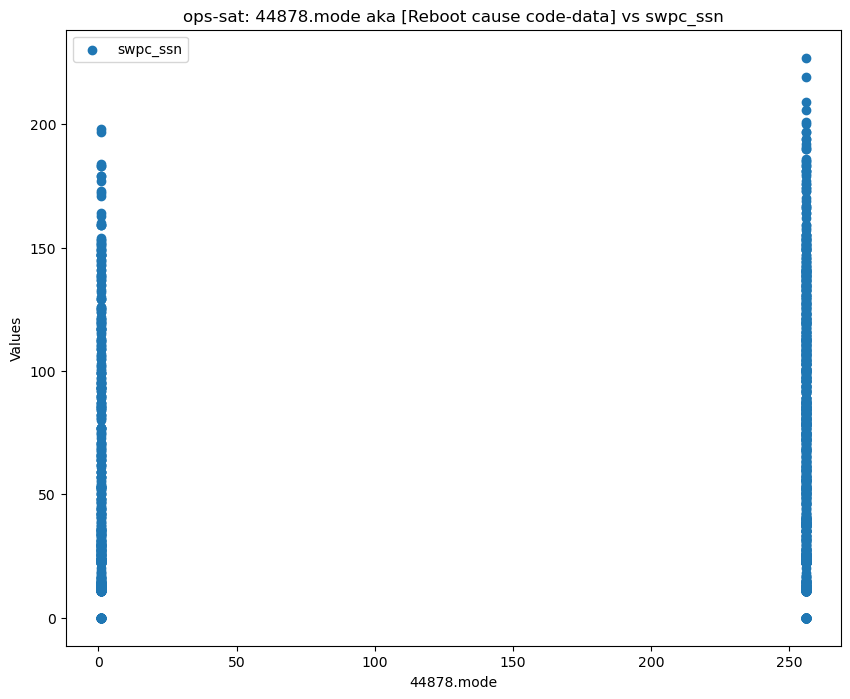

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |       188    |   188      |
| mean  |      3552.3  |    68.9043 |
| std   |     13749    |    50.199  |
| min   |         0    |     0      |
| 25%   |         0    |    24      |
| 50%   |        82    |    60.5    |
| 75%   |      1040.25 |   112      |
| max   |    125791    |   179      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.261793611402168], spearman=[-0.28165869536918936], kendall_tau=[-0.19665418137960228]


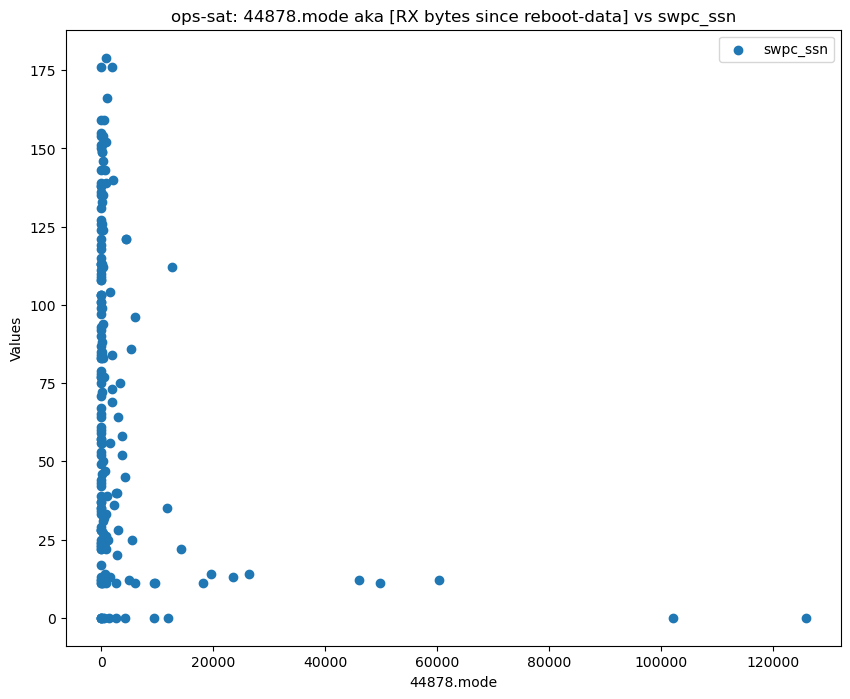

+-------+--------------+------------+
|       |   44878.mode |   swpc_ssn |
|-------+--------------+------------|
| count |    1289      |  1289      |
| mean  |      75.1311 |    67.5679 |
| std   |     246.648  |    51.1105 |
| min   |       0      |     0      |
| 25%   |       0      |    23      |
| 50%   |       5      |    59      |
| 75%   |      29      |   106      |
| max   |    2231      |   227      |
+-------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2816047057681802], spearman=[-0.2944798008540808], kendall_tau=[-0.21233242876313882]


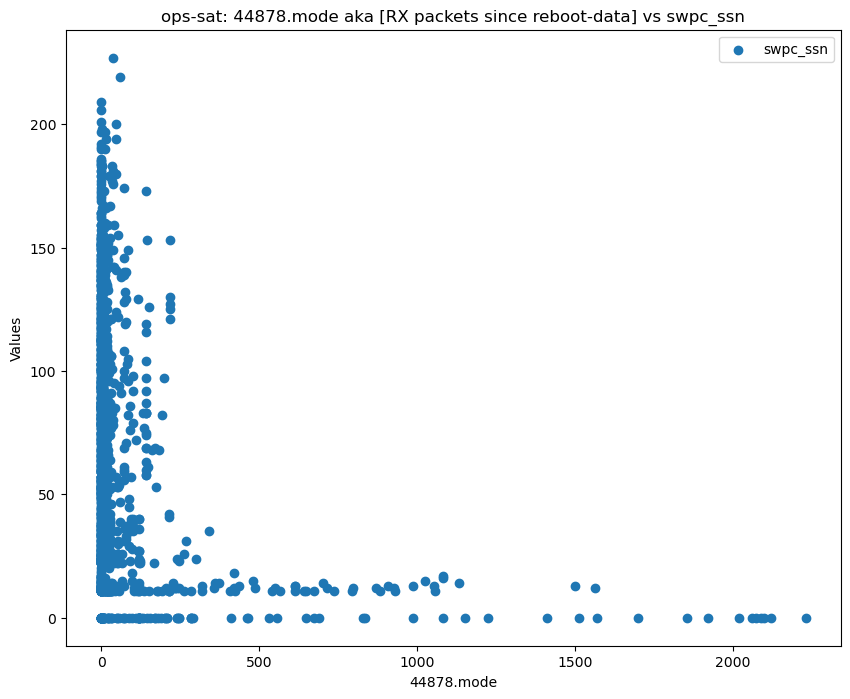

+-------+----------+------------+
|       |   Frames |   swpc_ssn |
|-------+----------+------------|
| count |     1449 |  1449      |
| mean  |   130535 |    62.7481 |
| std   |    62472 |    52.0369 |
| min   |        0 |     0      |
| 25%   |   108054 |    14      |
| 50%   |   134599 |    52      |
| 75%   |   172671 |   101      |
| max   |   225936 |   227      |
+-------+----------+------------+
Correlation [Frames] vs [swpc_ssn]: pearson=[0.7330561930756717], spearman=[0.8333018545991522], kendall_tau=[0.6322657615049996]


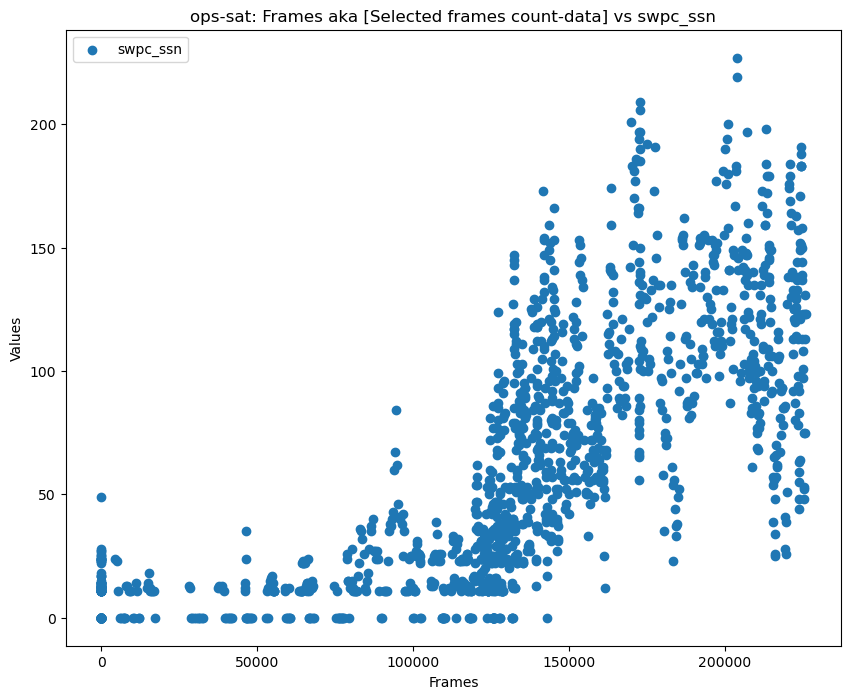

+-------+------------------+------------+
|       |       44878.mode |   swpc_ssn |
|-------+------------------+------------|
| count |    188           |   188      |
| mean  |      1.0835e+06  |    68.9043 |
| std   | 127400           |    50.199  |
| min   | 392180           |     0      |
| 25%   |      1.05803e+06 |    24      |
| 50%   |      1.10793e+06 |    60.5    |
| 75%   |      1.14679e+06 |   112      |
| max   |      1.19440e+06 |   179      |
+-------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5380133871877748], spearman=[0.7857285673694304], kendall_tau=[0.5786804345788774]


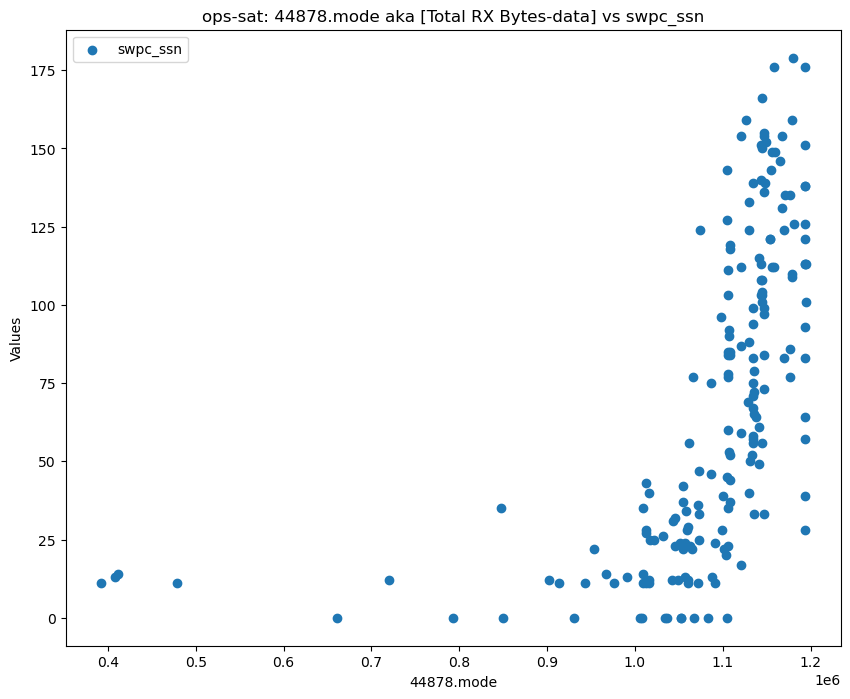

In [555]:
analyze_satellite('ops-sat')

+-------+--------------+------------+
|       |   58261.mode |   swpc_ssn |
|-------+--------------+------------|
| count |      13      |    13      |
| mean  |      28.6154 |   111.154  |
| std   |      16.0963 |    38.6455 |
| min   |       0      |    28      |
| 25%   |      17      |    93      |
| 50%   |      39      |   113      |
| 75%   |      42      |   138      |
| max   |      43      |   176      |
+-------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.21471666569320857], spearman=[0.015235515517624728], kendall_tau=[-0.026669037353133248]


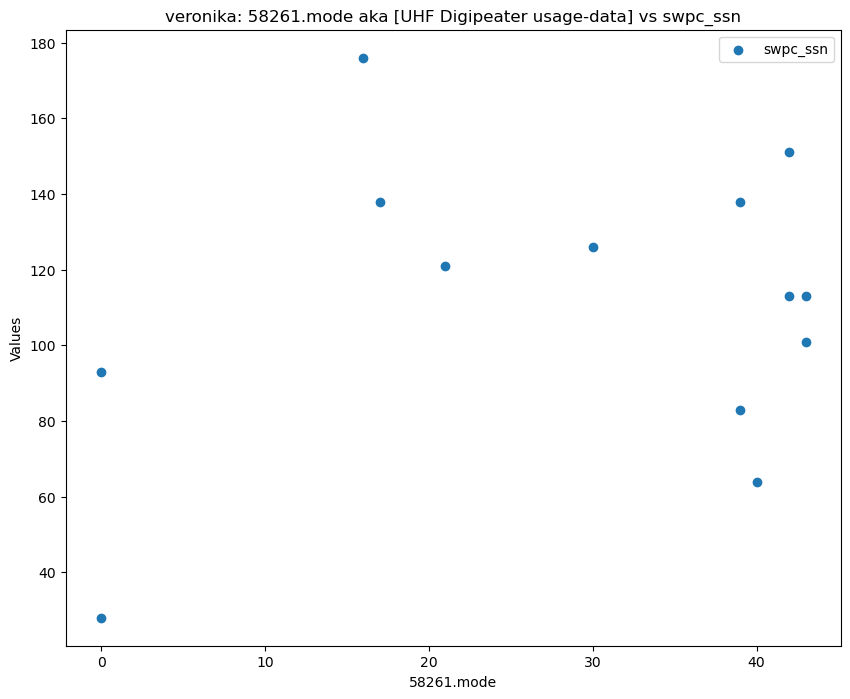

+-------+------------+------------+
|       |   MCU (°C) |   swpc_ssn |
|-------+------------+------------|
| count |   85       |    85      |
| mean  |    2.04588 |   117.176  |
| std   |    4.15496 |    42.2862 |
| min   |   -3       |    26      |
| 25%   |   -1       |    86      |
| 50%   |    0.54    |   123      |
| 75%   |    4.9     |   149      |
| max   |   15       |   191      |
+-------+------------+------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.057043332723949264], spearman=[-0.07386560505897043], kendall_tau=[-0.05313741753683994]


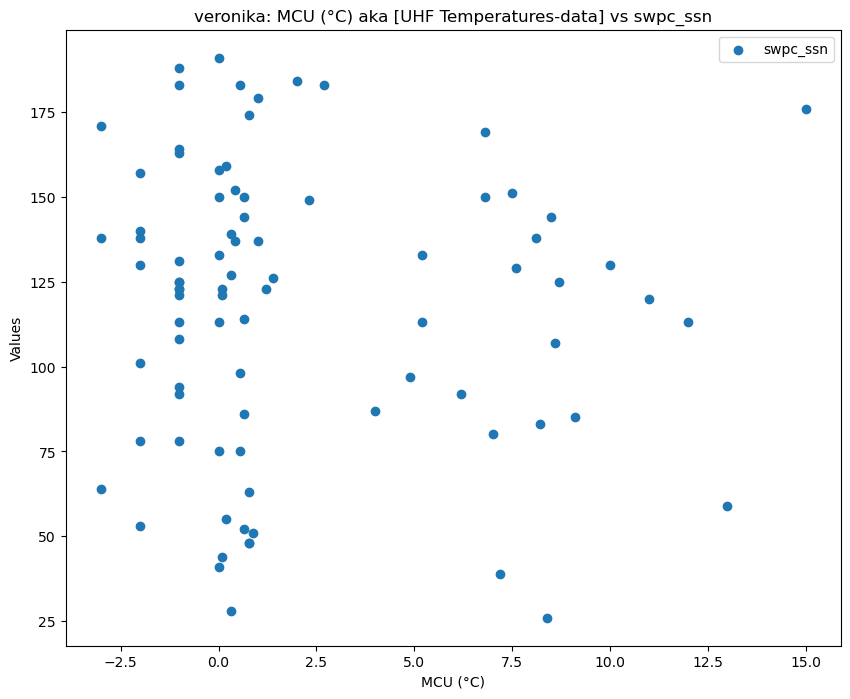

+-------+--------------+------------+
|       |   58261.mode |   swpc_ssn |
|-------+--------------+------------|
| count |           13 |    13      |
| mean  |       451529 |   111.154  |
| std   |       313169 |    38.6455 |
| min   |        11665 |    28      |
| 25%   |       176553 |    93      |
| 50%   |       474357 |   113      |
| 75%   |       744778 |   138      |
| max   |       868583 |   176      |
+-------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.04947440917428154], spearman=[-0.024793482509275887], kendall_tau=[-0.0519524333466131]


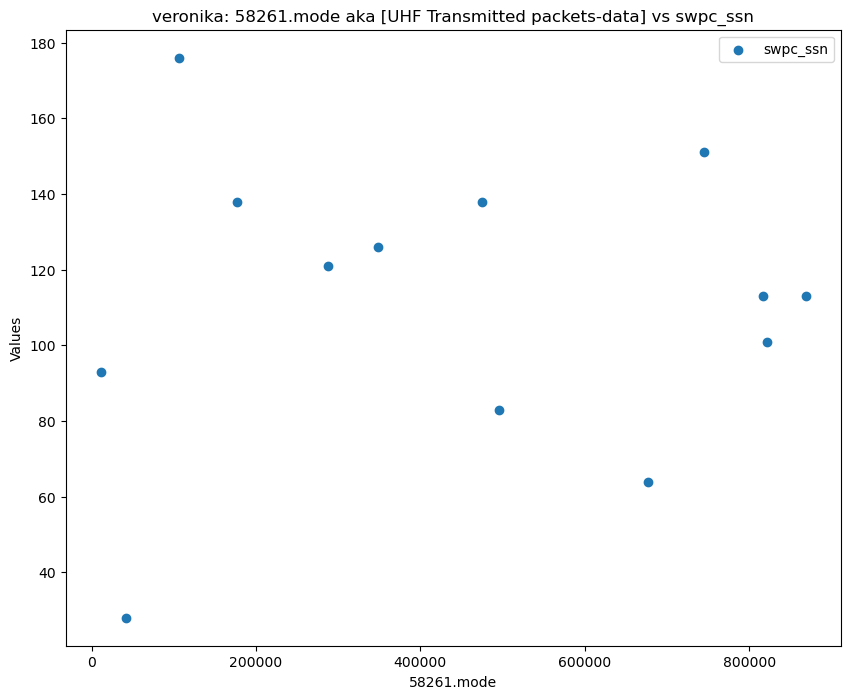

+-------+------------------+------------+
|       |       58261.mode |   swpc_ssn |
|-------+------------------+------------|
| count |     13           |    13      |
| mean  |      3.64372e+06 |   111.154  |
| std   |      2.31573e+06 |    38.6455 |
| min   | 178201           |    28      |
| 25%   |      1.73195e+06 |    93      |
| 50%   |      3.94287e+06 |   113      |
| 75%   |      5.27738e+06 |   138      |
| max   |      7.09168e+06 |   176      |
+-------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendall_tau=[-0.0519524333466131]


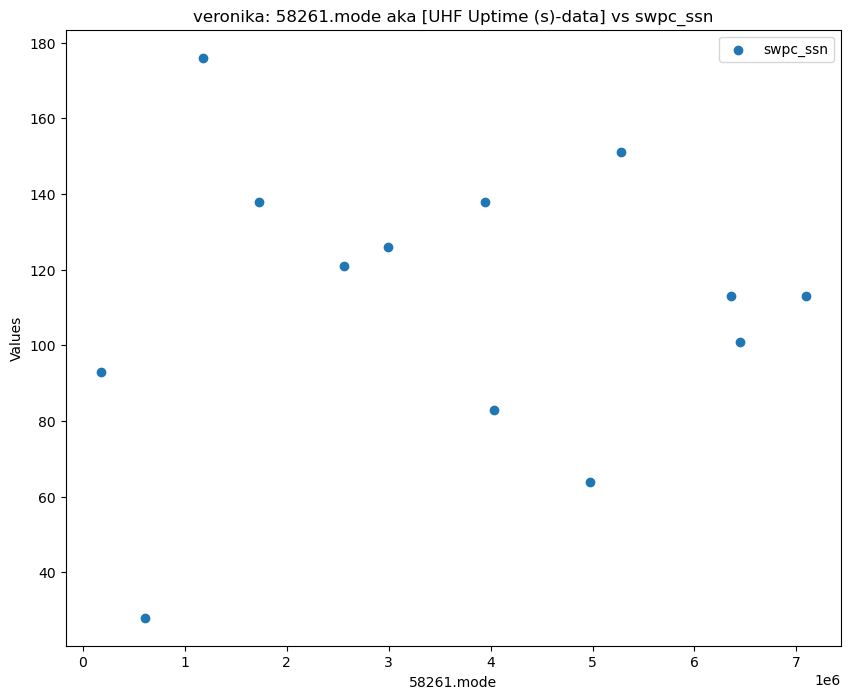

+-------+------------------+------------+
|       |       58261.mode |   swpc_ssn |
|-------+------------------+------------|
| count |     13           |    13      |
| mean  |      3.64374e+06 |   111.154  |
| std   |      2.31573e+06 |    38.6455 |
| min   | 178224           |    28      |
| 25%   |      1.73197e+06 |    93      |
| 50%   |      3.94289e+06 |   113      |
| 75%   |      5.27740e+06 |   138      |
| max   |      7.0917e+06  |   176      |
+-------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendall_tau=[-0.0519524333466131]


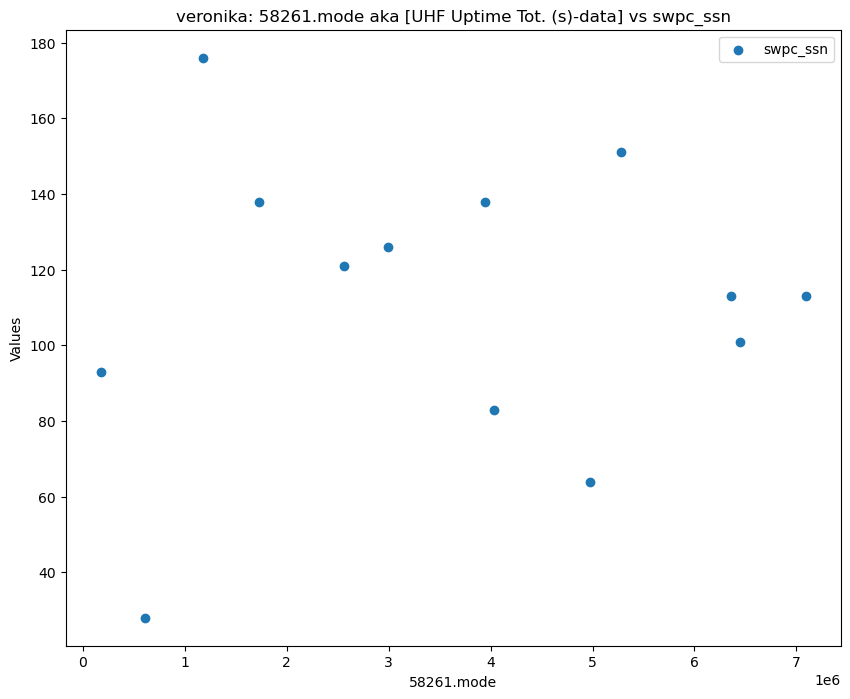

+-------+-------------------------+------------+
|       |   58261.mode week (day) |   swpc_ssn |
|-------+-------------------------+------------|
| count |                13       |    13      |
| mean  |                 6.16038 |   111.154  |
| std   |                 3.63519 |    38.6455 |
| min   |                 1.012   |    28      |
| 25%   |                 2.864   |    93      |
| 50%   |                 6.519   |   113      |
| 75%   |                 8.726   |   138      |
| max   |                11.726   |   176      |
+-------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendall_tau=[-0.0519524333466131]


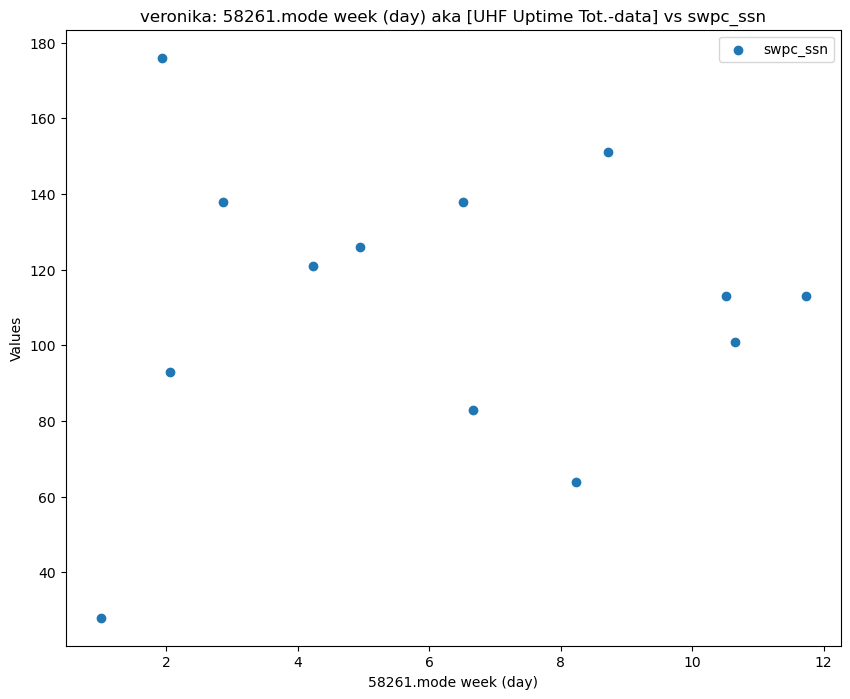

+-------+-------------------------+------------+
|       |   58261.mode week (day) |   swpc_ssn |
|-------+-------------------------+------------|
| count |                13       |    13      |
| mean  |                 6.16038 |   111.154  |
| std   |                 3.63519 |    38.6455 |
| min   |                 1.012   |    28      |
| 25%   |                 2.864   |    93      |
| 50%   |                 6.519   |   113      |
| 75%   |                 8.726   |   138      |
| max   |                11.726   |   176      |
+-------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendall_tau=[-0.0519524333466131]


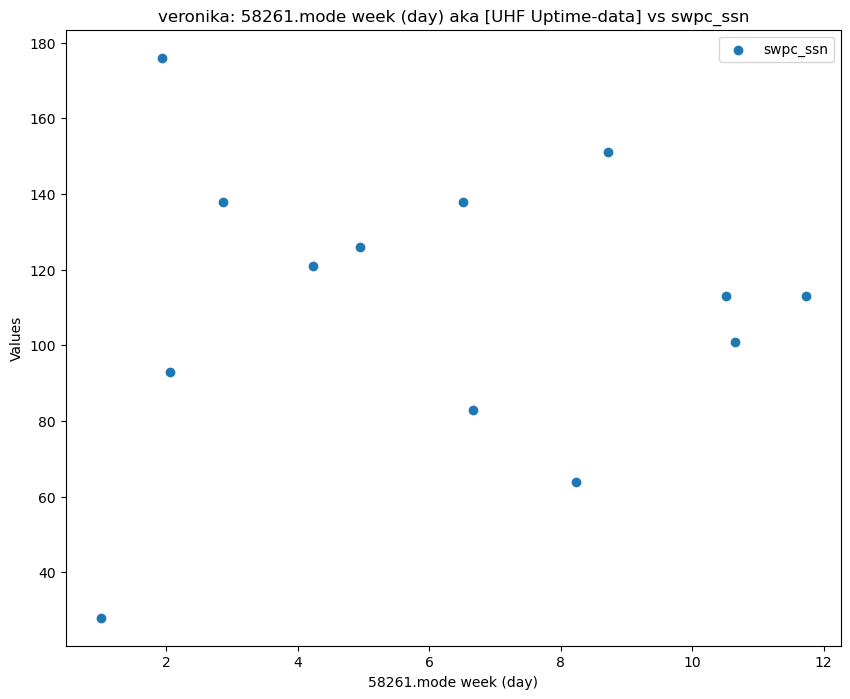

+-------+----------+------------+
|       |        X |   swpc_ssn |
|-------+----------+------------|
| count |    85    |    85      |
| mean  |  8772.72 |   117.176  |
| std   |  2854.7  |    42.2862 |
| min   | -1436    |    26      |
| 25%   |  8582    |    86      |
| 50%   |  9436    |   123      |
| 75%   | 10091    |   149      |
| max   | 17179    |   191      |
+-------+----------+------------+
Correlation [X] vs [swpc_ssn]: pearson=[0.10656617888267522], spearman=[0.07785607654783727], kendall_tau=[0.055165208946249426]


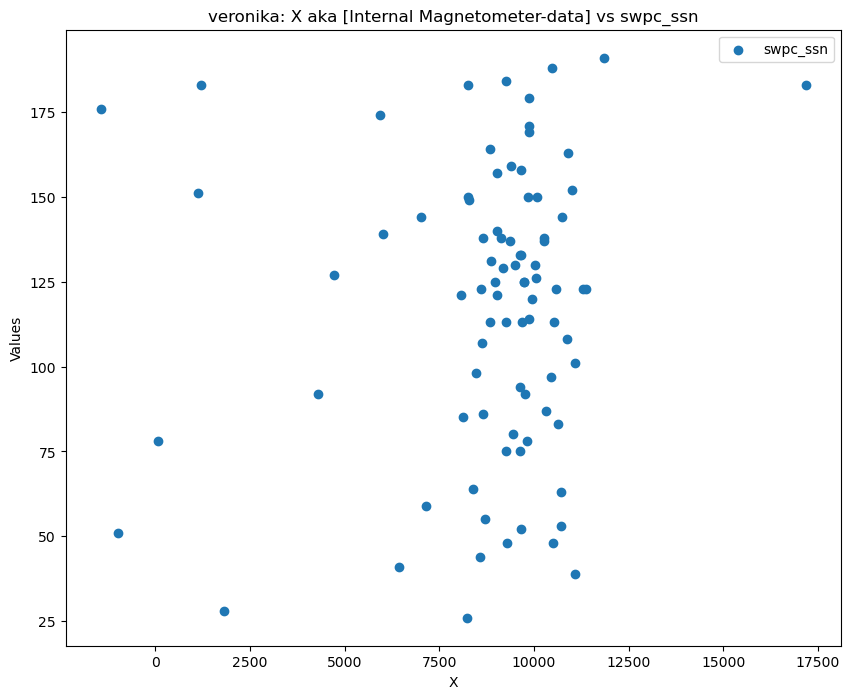

+-------+-------------------------+------------+
|       |   58261.mode week (day) |   swpc_ssn |
|-------+-------------------------+------------|
| count |                13       |    13      |
| mean  |                 6.28238 |   111.154  |
| std   |                 3.70936 |    38.6455 |
| min   |                 1.012   |    28      |
| 25%   |                 2.722   |    93      |
| 50%   |                 5.724   |   113      |
| 75%   |                 8.659   |   138      |
| max   |                12.515   |   176      |
+-------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.041200604541361034], spearman=[-0.00826449416975863], kendall_tau=[-0.02597621667330655]


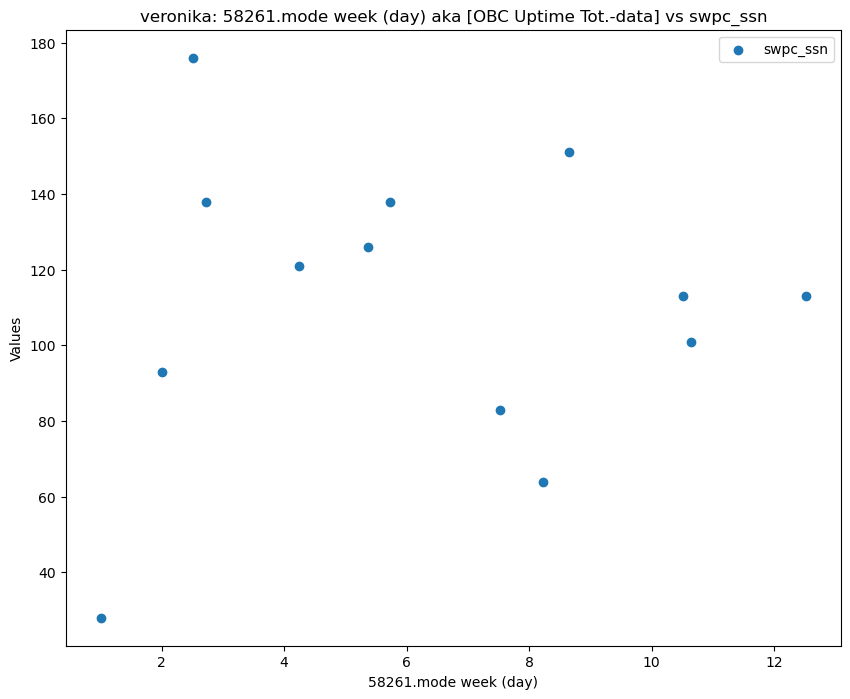

+-------+------------------+------------+
|       |   58261.mode day |   swpc_ssn |
|-------+------------------+------------|
| count |        13        |    13      |
| mean  |         3.88438  |   111.154  |
| std   |         0.253359 |    38.6455 |
| min   |         3.042    |    28      |
| 25%   |         3.958    |    93      |
| 50%   |         3.958    |   113      |
| 75%   |         3.958    |   138      |
| max   |         3.958    |   176      |
+-------+------------------+------------+
Correlation [58261.mode day] vs [swpc_ssn]: pearson=[-0.49921487354042293], spearman=[-0.2102353324910547], kendall_tau=[-0.16742770563222895]


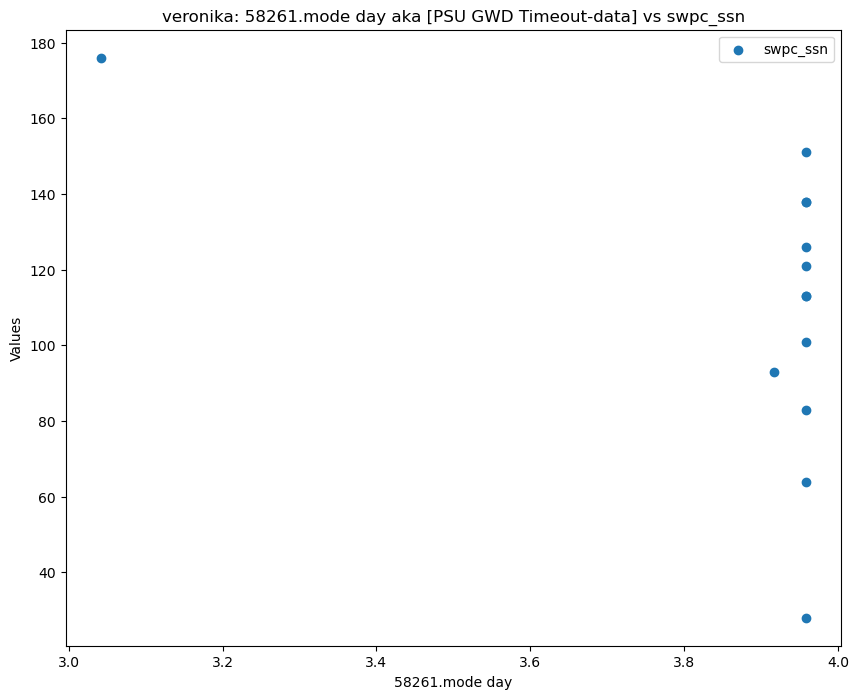

+-------+-------------------------+------------+
|       |   58261.mode week (day) |   swpc_ssn |
|-------+-------------------------+------------|
| count |                13       |    13      |
| mean  |                 6.43869 |   111.154  |
| std   |                 3.72289 |    38.6455 |
| min   |                 1.011   |    28      |
| 25%   |                 3.05    |    93      |
| 50%   |                 6.37    |   113      |
| 75%   |                 9.508   |   138      |
| max   |                12.493   |   176      |
+-------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.06972682906356296], spearman=[-0.09366426725726446], kendall_tau=[-0.07792865001991965]


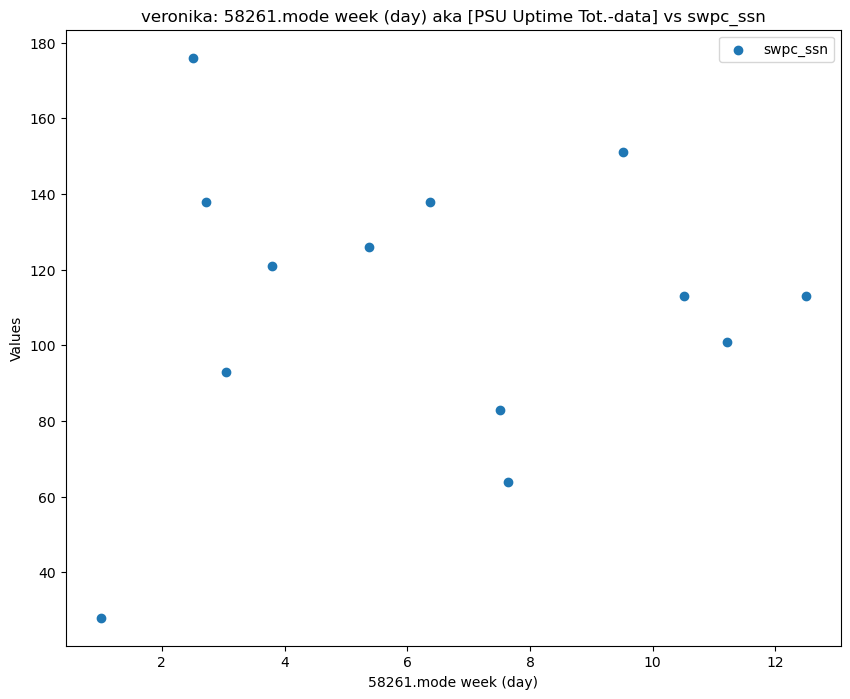

+-------+-------------------------+------------+
|       |   58261.mode week (day) |   swpc_ssn |
|-------+-------------------------+------------|
| count |                13       |    13      |
| mean  |                 6.43862 |   111.154  |
| std   |                 3.72291 |    38.6455 |
| min   |                 1.011   |    28      |
| 25%   |                 3.05    |    93      |
| 50%   |                 6.37    |   113      |
| 75%   |                 9.508   |   138      |
| max   |                12.493   |   176      |
+-------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.0697177822007228], spearman=[-0.09366426725726446], kendall_tau=[-0.07792865001991965]


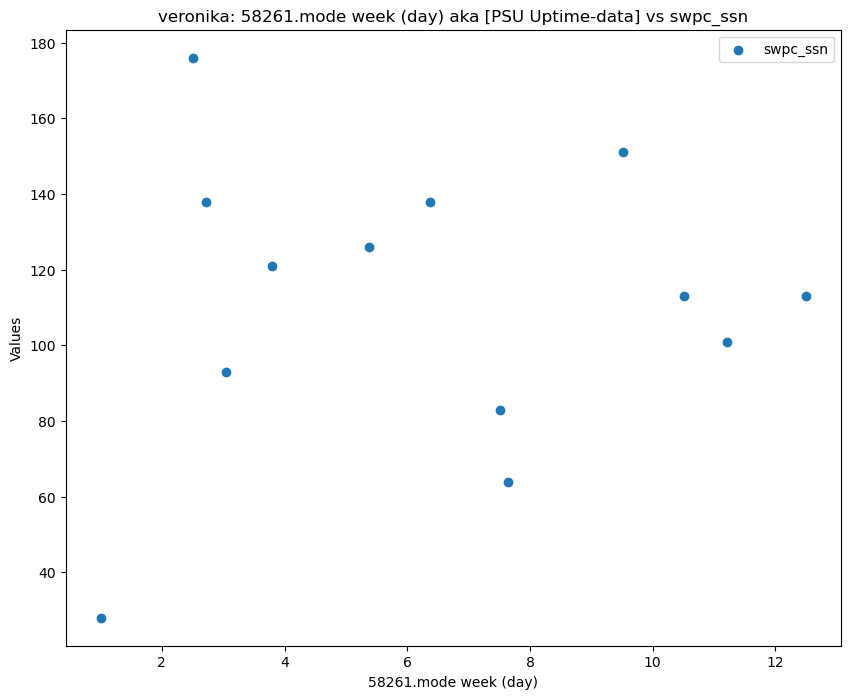

+-------+------------+------------+
|       |   MCU (°C) |   swpc_ssn |
|-------+------------+------------|
| count |   13       |    13      |
| mean  |    7.33077 |   111.154  |
| std   |    3.94575 |    38.6455 |
| min   |   -1       |    28      |
| 25%   |    5.1     |    93      |
| 50%   |    7.5     |   113      |
| 75%   |   10       |   138      |
| max   |   15       |   176      |
+-------+------------+------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.22519147552737345], spearman=[-0.40000038049994835], kendall_tau=[-0.3006600167292012]


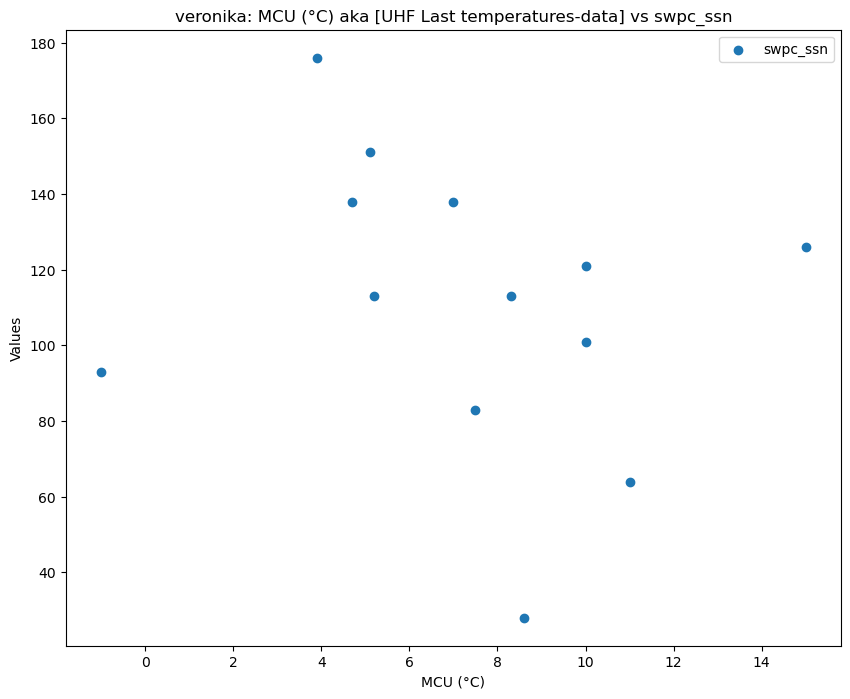

+-------+----------------+------------+
|       |   RF Chip (°C) |   swpc_ssn |
|-------+----------------+------------|
| count |       13       |    13      |
| mean  |        7.24615 |   111.154  |
| std   |        4.82141 |    38.6455 |
| min   |       -2       |    28      |
| 25%   |        4.4     |    93      |
| 50%   |        6.6     |   113      |
| 75%   |        9.7     |   138      |
| max   |       18       |   176      |
+-------+----------------+------------+
Correlation [RF Chip (°C)] vs [swpc_ssn]: pearson=[-0.2097544734859616], spearman=[-0.3365520442827152], kendall_tau=[-0.24837131816760094]


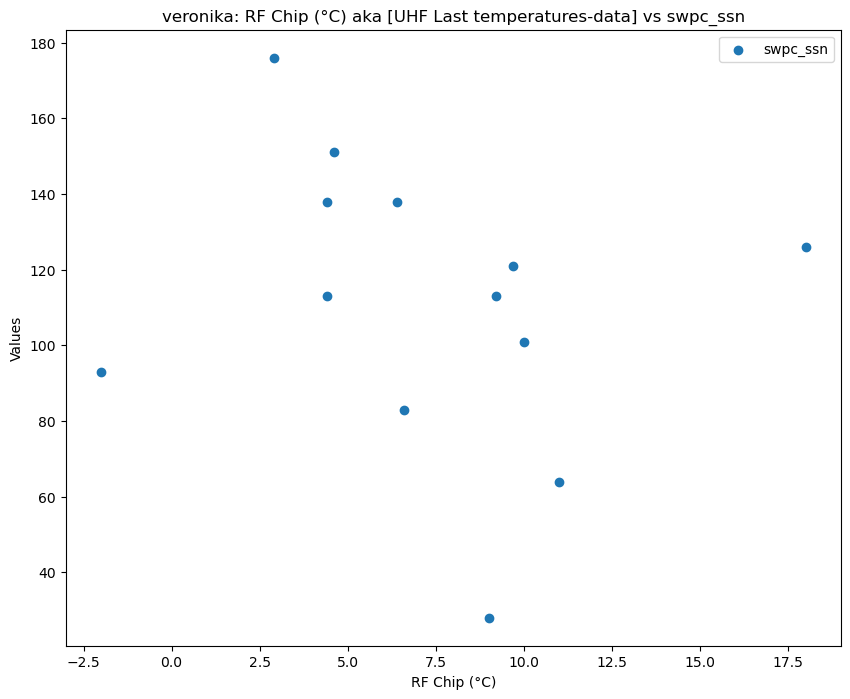

+-------+-----------+------------+
|       |   PA (°C) |   swpc_ssn |
|-------+-----------+------------|
| count |  13       |    13      |
| mean  |   8.12308 |   111.154  |
| std   |   6.86151 |    38.6455 |
| min   |  -2       |    28      |
| 25%   |   4.3     |    93      |
| 50%   |   6       |   113      |
| 75%   |  10       |   138      |
| max   |  25       |   176      |
+-------+-----------+------------+
Correlation [PA (°C)] vs [swpc_ssn]: pearson=[-0.10711711237073555], spearman=[-0.32231527262058657], kendall_tau=[-0.23378595005975894]


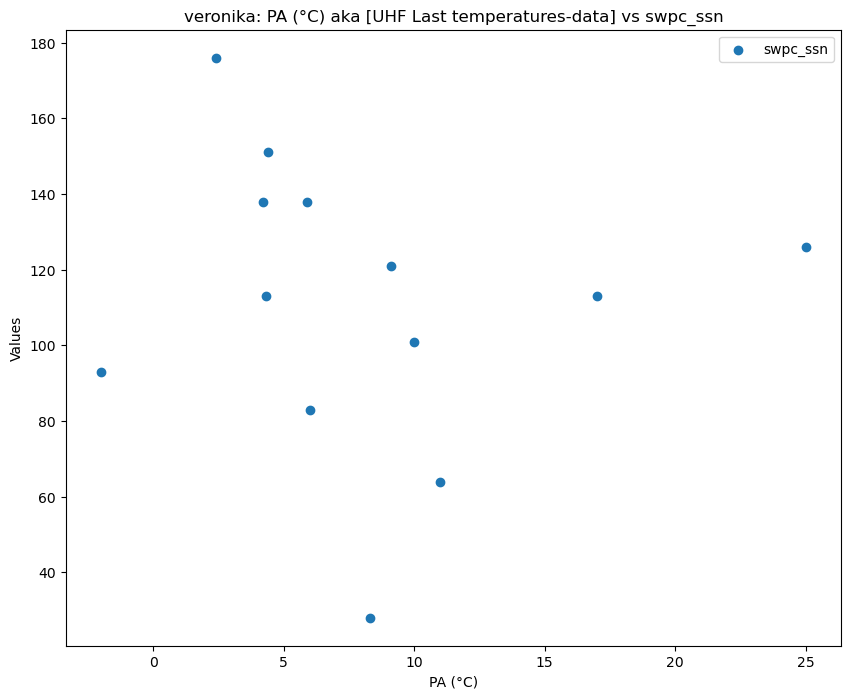

+-------+--------------+------------+
|       |   58261.mode |   swpc_ssn |
|-------+--------------+------------|
| count |       13     |    13      |
| mean  |      235.385 |   111.154  |
| std   |      107.868 |    38.6455 |
| min   |        0     |    28      |
| 25%   |      270     |    93      |
| 50%   |      293     |   113      |
| 75%   |      296     |   138      |
| max   |      299     |   176      |
+-------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.3324105676753036], spearman=[0.006915635937205746], kendall_tau=[-0.039735970711951306]


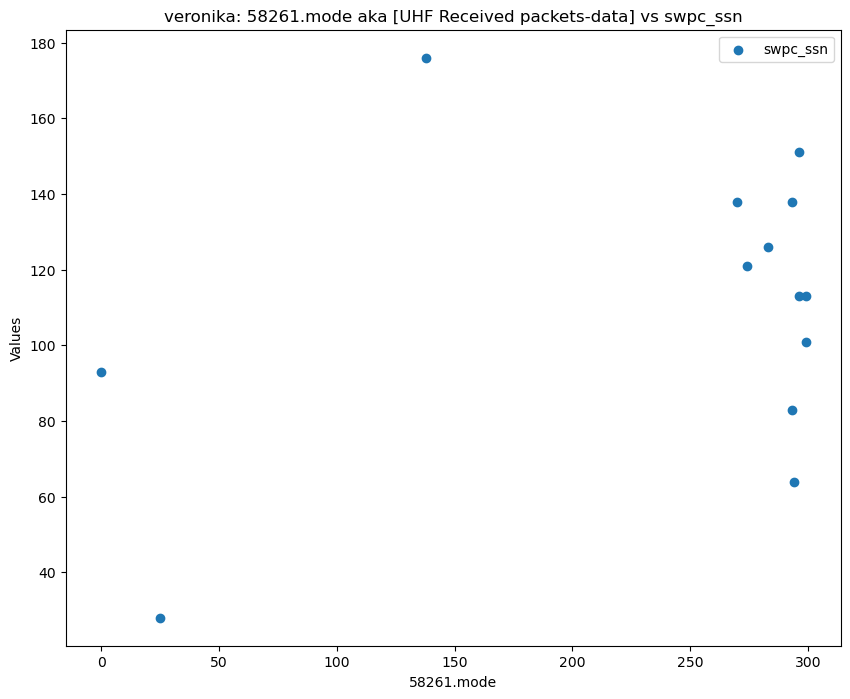

+-------+--------------+------------+
|       |   58261.mode |   swpc_ssn |
|-------+--------------+------------|
| count |           13 |    13      |
| mean  |            0 |   111.154  |
| std   |            0 |    38.6455 |
| min   |            0 |    28      |
| 25%   |            0 |    93      |
| 50%   |            0 |   113      |
| 75%   |            0 |   138      |
| max   |            0 |   176      |
+-------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendall_tau=[nan]


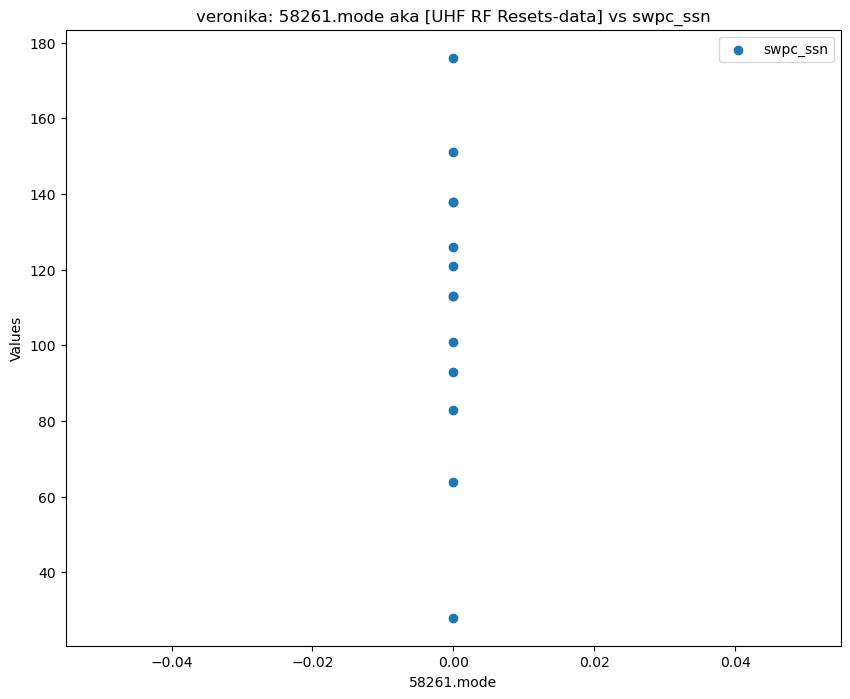

In [556]:
analyze_satellite('veronika')

+-------+-------------------+------------+
|       |   51085.last (°C) |   swpc_ssn |
|-------+-------------------+------------|
| count |         107       |   107      |
| mean  |           6.41121 |   100.037  |
| std   |           4.01637 |    38.8752 |
| min   |          -3       |    17      |
| 25%   |           3.5     |    70      |
| 50%   |           6       |   101      |
| 75%   |          10       |   132      |
| max   |          17       |   179      |
+-------+-------------------+------------+
Correlation [51085.last (°C)] vs [swpc_ssn]: pearson=[-0.02759095642049777], spearman=[-0.019451876656504323], kendall_tau=[-0.011751687937229124]


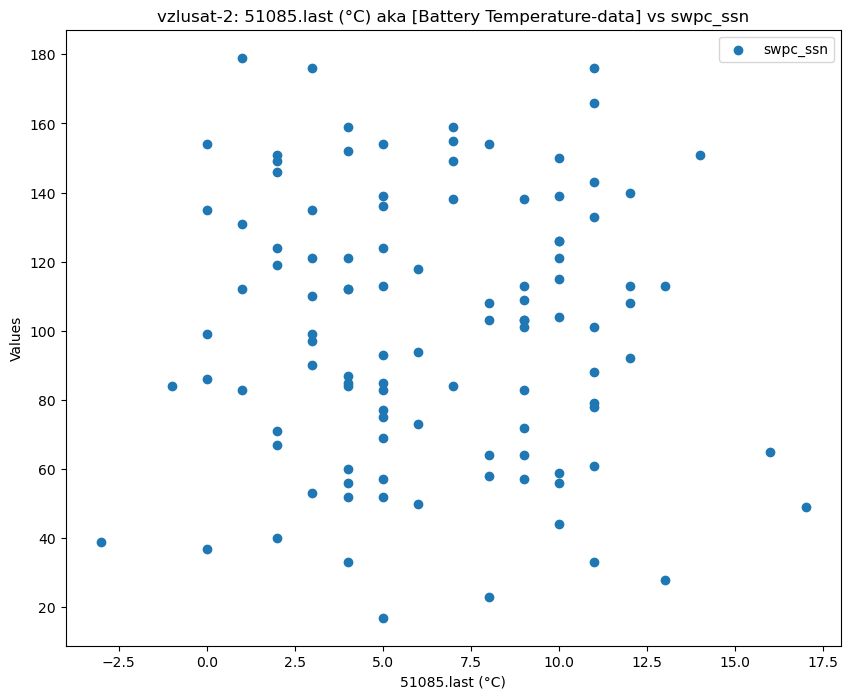

In [557]:
analyze_satellite('vzlusat-2')